# ENSO impact on river discharge using GP Regression - General Analysis

This jupyter notebook was made in the course of a Bachelor's thesis in the degree of mediainformatics at the University of Tuebingen. 
This project evolved under the supervision of Bedartha Goswami and his research group "Machine Learning in Climate Science" at the Cluster Of Excellence "Machine Learning".

The scope of this project is to investigate ENSO impact on river discharge in South America using a data-driven approach. 
The data used for this project is provided by Do et. al via the 2018 released "Global Streamflow and Metadata and Indices Archive" (GSIM). 

With the GSIM dataset and Gaussian Process Regression we inferred missing values for stations to extend the temporal and spatial coverage of our analysis.

In this Jupyter notebook the inferred data as well as the raw GSIM data is plotted to provide a general analysis of the dataset and to get a better understanding about the temporal distribution of the data as well as their different attributes.

In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import itertools
import GPy
import csv
import pickle
import random
import math

from scipy.stats import norm, percentileofscore
from scipy import stats
from datetime import datetime
from statistics import mean 
from sklearn.metrics import mean_squared_error

### Loading inferred data

In [2]:
ds = pd.read_csv("data/predictions/ds_gaussian_clean.csv")
ds = ds.drop(['Unnamed: 0'], axis=1)

In [3]:
with open('data/predictionBase.pkl', 'rb') as inp:
    predictionBase = pickle.load(inp)
    
    
with open('data/predictableTimeseries.pkl', 'rb') as inp:
    predictableTimeseries = pickle.load(inp)
    

with open('data/gsimNumbersPredictionBase.pkl', 'rb') as inp:
    gsimNumbersPredictionBase = pickle.load(inp)
       

### Loading GSIM data

In [4]:
'''
This function loads the meta data, monhtly, yearly and seasonal data from the GSIM dataset for a gsim number
To each dataframe the gsim number is added for further identification.
Colum names are cleaned and a list of all dataframes is finally returned
'''
def loadTimeseries (series_name): 
    meta = gsim_metadata.loc[gsim_metadata['gsim.no'] == series_name]
    monthly = pd.read_csv("data/GSIM_indices/TIMESERIES/monthly/"+series_name+".mon", sep=',' '\\t', skiprows=lambda x : x < 21, engine='python',)
    yearly = pd.read_csv("data/GSIM_indices/TIMESERIES/yearly/"+series_name+".year", sep=',' '\\t', skiprows=lambda x : x < 21, engine='python',)
    seasonal = pd.read_csv("data/GSIM_indices/TIMESERIES/seasonal/"+series_name+".seas", sep=',' '\\t', skiprows=lambda x : x < 21, engine='python',)
    monthly['gsim.no'] = series_name
    yearly['gsim.no'] = series_name
    seasonal['gsim.no'] = series_name
    monthly.columns, yearly.columns, seasonal.columns = monthly.columns.str.replace('"', ''), yearly.columns.str.replace('"', ''), seasonal.columns.str.replace('"', '')
    return [meta, monthly, yearly, seasonal]

In [5]:
'''
Transforms the last date of measurment for a season priveded in the gsim dataset as the feature date
As the seasonal gsim dataset stores the last date of measurement the last day of measurement of season DJF is in February, MAM in May and so on 
'''
def determimeSeason(date):
    endMonth = pd.to_datetime(date).month
    switcher = {
        2: "DJF",
        5: "MAM",
        8: "JJA",
        11: "SON"
    }
    return switcher.get(endMonth, "undefined")

In [6]:
# Loading the GSIM_metadata_Archive
gsim_metadata = pd.read_csv("data/GSIM_metadata/GSIM_catalog/GSIM_metadata.csv", sep=",")


# Selecting all the dataframes for South America by 2 Letter Country Code
southamerica2letterCC = ['AR', 'BO', 'BR', 'CL', 'CO', 'EC', 'FK', 'GF', 'GY', 'PY', 'PE', 'SR', 'UY', 'VE']

stations_of_interest = pd.Series()
for country in southamerica2letterCC: 
    stations_of_interest = stations_of_interest.append(gsim_metadata.loc[gsim_metadata['country'] == country]['gsim.no'], ignore_index=True)
        
    
# Initialisation of the empty lists where we store the dataframes: datatype: list of dataframes
df_yearly = []
df_monthly = []
df_seasonal = []
df_meta = []

# For each station in South America we load the meta, yearly, seasonal and monthly dataset
for station in stations_of_interest:
    
    series = loadTimeseries(station)
    df_meta.append(series[0])
    df_monthly.append(series[1])
    df_yearly.append(series[2])
    df_seasonal.append(series[3])

    
        
# For each dataframe in our monthly dataset we add a column that stores each the year and the month for a given measurement
for df in df_monthly: 
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['date'] = pd.to_datetime(df['date']).dt.date

    
# For each dataframe in our yearly dataset we add a column that stores the year for a given measurement
for df in df_yearly: 
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['date'] = pd.to_datetime(df['date']).dt.date


# For each dataframe in our seasonal dataset we add a column that stores the year and the season of the measurment. 
# Note that for the season DJF, the year is year of the months January and February is stored. 
for df in df_seasonal: 
    df['date'] = pd.to_datetime(df['date']).dt.date
    df['year'] = pd.to_datetime(df['date']).dt.year
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['season'] = [determimeSeason(date) for date in df['date']]
    
    
# Merge the list of metadataframes into one single dataframe, as for each station only one row of metadat exists we can merge them into one single dataframe
for index,meta in enumerate(df_meta):
    if index == 0:
        ds_meta = meta
    else: 
        ds_meta = ds_meta.append(meta, ignore_index = True)

### Temporal coverage

#### Distribution of the temporal coverage of all stations in the GSIM in South America

In [7]:
soutamerica_yearly_coverage = np.zeros((len(df_meta)))
for index, meta in enumerate(df_meta):
    soutamerica_yearly_coverage[index] =  meta['year.no']
    

 C:\Users\marku\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


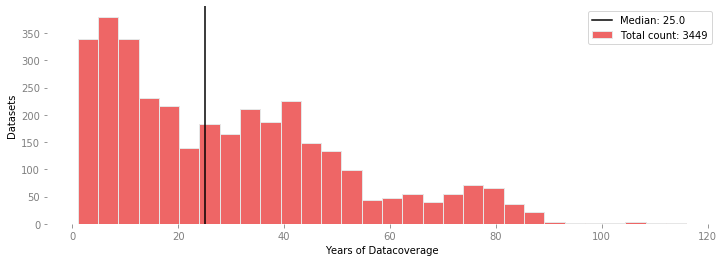

In [8]:
plt.figure(figsize=(12,4))
plt.xlabel('Years of Datacoverage')
plt.ylabel('Datasets')

# use a gray background
ax = plt.axes()
ax.set_axisbelow(True)

# draw solid white grid lines
plt.grid(color='w', linestyle='solid')

# hide axis spines
for spine in ax.spines.values():
    spine.set_visible(False)

# hide top and right ticks
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# lighten ticks and labels
ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')

# control face and edge color of histogram
ax.hist(soutamerica_yearly_coverage, edgecolor='#E6E6E6', color='#EE6666', bins=30);

unique, counts = np.unique(soutamerica_yearly_coverage, return_counts=True)
median = np.median(soutamerica_yearly_coverage)
plt.axvline(median, color="k")
plt.legend(['Median: ' + str(median), 'Total count: ' +  str(len(soutamerica_yearly_coverage))])
plt.show()

#### Plot of when staions in South America stop measuring and have their last year of active recording 

In [9]:
soutamerica_endyear = np.zeros((len(df_meta)))
for index, meta in enumerate(df_meta): 
    soutamerica_endyear[index] = meta['year.end']

 C:\Users\marku\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


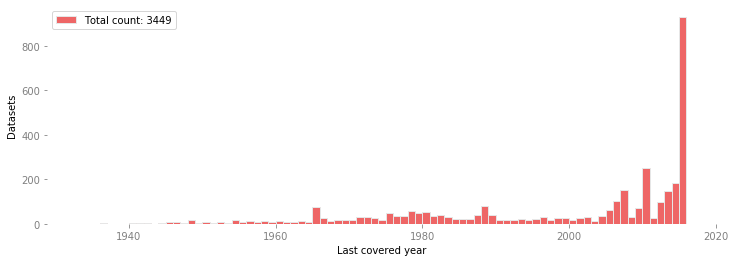

In [10]:
plt.figure(figsize=(12,4))
plt.xlabel('Last covered year')
plt.ylabel('Datasets')

ax = plt.axes()
ax.set_axisbelow(True)

# draw solid white grid lines
plt.grid(color='w', linestyle='solid')

# hide axis spines
for spine in ax.spines.values():
    spine.set_visible(False)

# hide top and right ticks
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# lighten ticks and labels
ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')

# control face and edge color of histogram
bins = int(max(soutamerica_endyear) - min(soutamerica_endyear))
ax.hist(soutamerica_endyear, edgecolor='#E6E6E6', color='#EE6666', bins=bins);
plt.legend(['Total count: ' +  str(len(soutamerica_endyear))])
plt.show()

#### Plot of the amount of stations that are actively recording per year

In [11]:
#Adding a column in the yearly dataset, where the year is stored for each row
years = []
for dataset in df_yearly:
    dataset['year'] = pd.to_datetime(dataset['date']).dt.year
    years.extend(set(dataset['year'].tolist()))

 C:\Users\marku\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


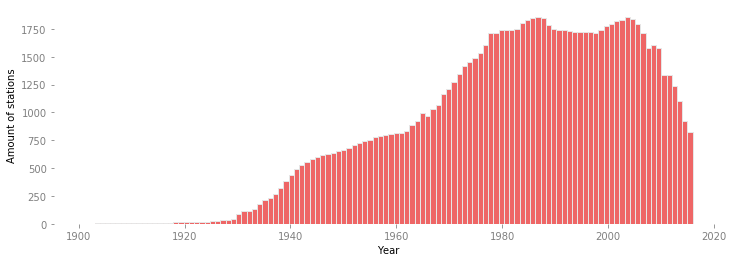

In [12]:
plt.figure(figsize=(12,4))
plt.xlabel('Year')
plt.ylabel('Amount of stations')

ax = plt.axes()
ax.set_axisbelow(True)

# draw solid white grid lines
plt.grid(color='w', linestyle='solid')

# hide axis spines
for spine in ax.spines.values():
    spine.set_visible(False)

# hide top and right ticks
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# lighten ticks and labels
ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')

# control face and edge color of histogram
ax.hist(years, edgecolor='#E6E6E6', color='#EE6666', bins=len(set(years)));
plt.show()

In [13]:
def get_range_of_years(lowerbound, upperbound):
    output = []
    for dataset in df_yearly:
        if lowerbound <= dataset.shape[0] < upperbound:
            output.extend(set(dataset['year'].tolist()))
    return output
    

In [14]:
plus60years = get_range_of_years(60,np.inf)
fourtyto59years = get_range_of_years(40,60)
twentyto39years = get_range_of_years(20,40)
lessthan20 = get_range_of_years(0,20)


In [15]:
colors = ['#264653', '#2a9d8f', '#e9c46a', '#e76f51']
allyears = np.array([plus60years,fourtyto59years, twentyto39years, lessthan20])

 C:\Users\marku\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: MatplotlibDeprecationWarning:Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


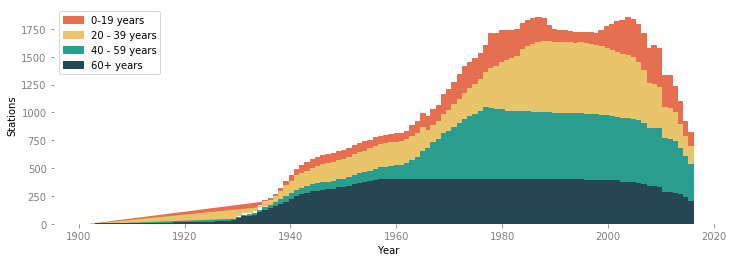

In [16]:
# Todo .. for those years that are not within one category like 1901 in 40-60 or so .. simply add 0 to them such that we can eliminate the artifact
# maybe think about another way of presenting the data. 
# like plotting multiple histograms on top of each other

plt.figure(figsize=(12,4))
plt.xlabel('Year')
plt.ylabel('Stations')

ax = plt.axes()
ax.set_axisbelow(True)

# draw solid white grid lines
plt.grid(color='w', linestyle='solid')

# hide axis spines
for spine in ax.spines.values():
    spine.set_visible(False)

# hide top and right ticks
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()

# lighten ticks and labels
ax.tick_params(colors='gray', direction='out')
for tick in ax.get_xticklabels():
    tick.set_color('gray')
for tick in ax.get_yticklabels():
    tick.set_color('gray')

# control face and edge color of histogram
bins = max(allyears.any()) - min(allyears.any())
labels = ['0-19 years', '20 - 39 years', '40 - 59 years', '60+ years']
ax.hist(allyears, color=colors, bins = bins+1,  histtype='step', stacked=True, fill=True);
plt.legend(labels, loc =2)
plt.show()

### Maximum discharge

#### Histogram of the number of stations that show their absolute maximum measured river discharge in a given year.

In [17]:
'''
@param  dataset: list of pandas dataframes
        min_years: number - minimum amount of years for e.g. a value of 20 only those time series are considered who have at least 20 years of data in their time series 
@return ndarray of the years and the amount of stations that have their absolute peak river discharge during this time
'''
def get_max_years (dataset, min_years):
    max_years = []
    for df in dataset:
        if df.shape[0] >= min_years:
            arr = df['MEAN'].to_numpy()
            arr_ = np.nan_to_num(arr, copy=True)
            maxind = np.argmax(arr_)
            if df['MEAN'].loc[maxind] == np.nan:
                raise Exception('x should not exceed 5. The value of x was: {}'.format(x))
            else:        
                max_years.append(df['year'].loc[maxind])
        else: 
            continue
    
    m = np.unique(max_years, return_counts=True)
    return m

In [18]:
'''
@param  dataset: list of pandas dataframes
        min_years: number - minimum amount of years for e.g. a value of 20 only those time series are considered who have at least 20 years of data in their time series 
@return ndarray of the years and the amount of stations that have measurements during this year
'''

def get_all_years (dataset, min_years):
    allyears = []
    for index, df in enumerate(df_yearly):
        if df.shape[0] >= min_years:
            years = df.loc[df['MEAN'].notnull()]['year'].to_numpy()
            allyears.extend(years)
        else: 
            continue
        
    a = np.unique(allyears, return_counts=True)
    return a
    

In [19]:
'''
@param  ma: ndarray - the years and the amount of stations that have their absolute maximum in the year
        al: ndarray - the amount of stations that cover a praticular year
@return ndarray - a normalized array of the stations that have maximum discharge during a year normalized by the amount of stations that cover the year
'''
def get_norm_years (ma,al):
    n = np.zeros(len(ma[0]))
    
    for idx, year in enumerate(ma[0]):
        max_discharge = ma[1][idx]
        if max_discharge != 0: 
            all_years = al[1][al[0] == year][0]
            norm = max_discharge/all_years 
            n[idx] = norm
        else: 
            n[idx] = 0
    
    return n

In [20]:
m0  = get_max_years(df_yearly, 0)
m10 = get_max_years(df_yearly, 10)
m20 = get_max_years(df_yearly, 20)
m30 = get_max_years(df_yearly, 30)
m40 = get_max_years(df_yearly, 40)
m50 = get_max_years(df_yearly, 50)
m60 = get_max_years(df_yearly, 60)
m70 = get_max_years(df_yearly, 70)

In [21]:
a0  = get_all_years(df_yearly, 0)
a10 = get_all_years(df_yearly, 10)
a20 = get_all_years(df_yearly, 20)
a30 = get_all_years(df_yearly, 30)
a40 = get_all_years(df_yearly, 40)
a50 = get_all_years(df_yearly, 50)
a60 = get_all_years(df_yearly, 60)
a70 = get_all_years(df_yearly, 70)

In [22]:
n0 = get_norm_years(m0, a0)
n10 = get_norm_years(m10, a10)
n20 = get_norm_years(m20, a20)
n30 = get_norm_years(m30, a30)
n40 = get_norm_years(m40, a40)
n50 = get_norm_years(m50, a50)
n60 = get_norm_years(m60, a60)
n70 = get_norm_years(m70, a70)

<BarContainer object of 89 artists>

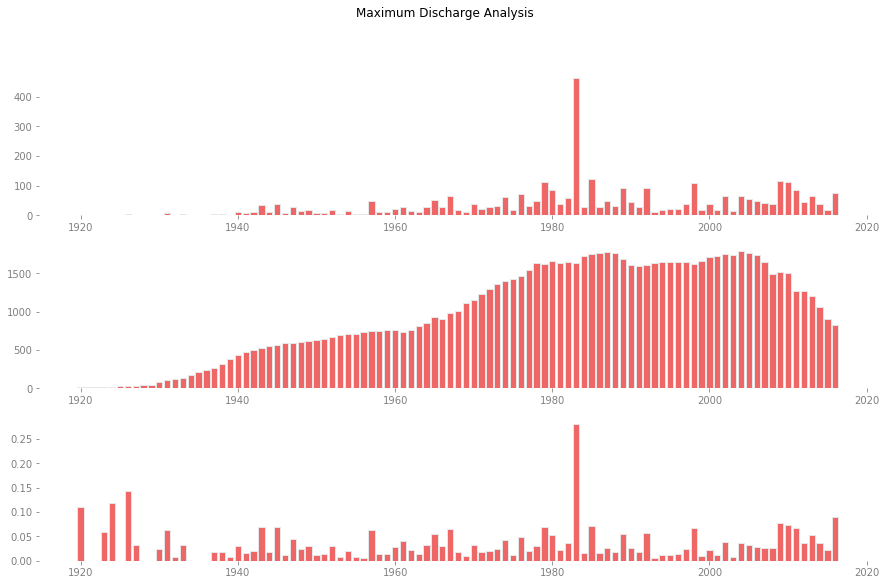

In [23]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,9))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

    
fig.suptitle('Maximum Discharge Analysis')
ax1.bar( m0[0], m0[1], edgecolor='#E6E6E6', color='#EE6666', label = 'amount of stations showing \nmaximum discharge in this year' )
ax2.bar( a0[0][19:], a0[1][19:], edgecolor='#E6E6E6', color='#EE6666', label = 'stations that cover this year' )
ax3.bar( m0[0], n0, edgecolor='#E6E6E6', color='#EE6666', label = 'percentage of stations with maximum discharge / stations that cover this year' )


<BarContainer object of 83 artists>

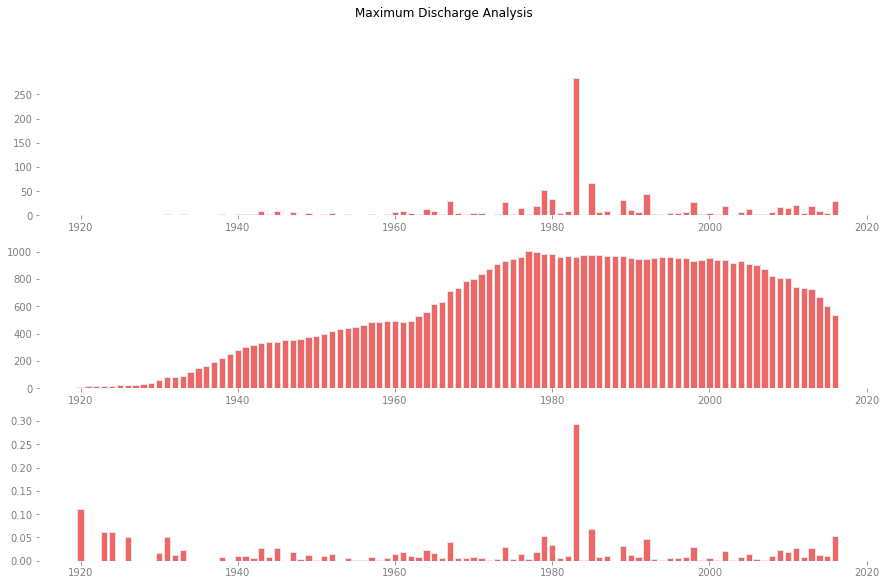

In [24]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,9))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

    
fig.suptitle('Maximum Discharge Analysis')
ax1.bar( m40[0], m40[1], edgecolor='#E6E6E6', color='#EE6666', label = 'amount of stations showing \nmaximum discharge in this year' )
ax2.bar( a40[0][19:], a40[1][19:], edgecolor='#E6E6E6', color='#EE6666', label = 'stations that cover this year' )
ax3.bar( m40[0], n40, edgecolor='#E6E6E6', color='#EE6666', label = 'percentage of stations with maximum discharge / stations that cover this year' )


### Transformation steps during Gaussian Normalisation

In [25]:
"""
Normalizes the data to a Gaussian distribution using quantiles. (function provided by Bedartha Goswami)
"""
def normalizeToGaussian(arr, mode="mean"):
    n = len(arr)
    perc = percentileofscore
    arr_ = arr.copy()[~np.isnan(arr)]
    out = np.zeros(n)
    for i in range(n):
        if not np.isnan(arr[i]):
            out[i] = norm.ppf(perc(arr_, arr[i], mode) / 100.)
        else:
            out[i] = np.nan
    return out


In [26]:
predictionBase[0]

,date,MEAN,SD,CV,IQR,MIN,MAX,MIN7,MAX7,n.missing,n.available,gsim.no,month,year
0,1960-01-31,12601.732258,1208.305023,0.095884,2113.02000,10622.020,14430.200,10128.115000,14101.840000,0,31,BR_0000078,1,1960
1,1960-02-29,14396.934138,247.026708,0.017158,235.57000,13760.620,14619.110,14032.572857,14605.572857,0,29,BR_0000078,2,1960
2,1960-03-31,13999.500968,457.025156,0.032646,450.55000,13070.770,14571.710,13253.682857,14480.744286,0,31,BR_0000078,3,1960
3,1960-04-30,12763.160667,192.896588,0.015114,359.46000,12449.090,13114.480,12533.584286,13149.421429,0,30,BR_0000078,4,1960
4,1960-05-31,12624.747419,600.664098,0.047578,937.78000,11429.330,13224.240,11686.385714,13208.531429,0,31,BR_0000078,5,1960
5,1960-06-30,8562.883800,1437.882959,0.167920,2057.45125,6653.374,11213.620,7042.049000,11580.974286,0,30,BR_0000078,6,1960
6,1960-07-31,4261.057677,1185.832583,0.278295,1717.67300,2578.497,6541.584,2857.694571,6917.213286,0,31,BR_0000078,7,1960
7,1960-08-31,1782.284677,411.052306,0.230632,700.47450,1352.604,2514.289,1381.777286,2757.707143,0,31,BR_0000078,8,1960
8,1960-09-30,1304.195933,57.677700,0.044225,87.65375,1245.255,1409.672,1245.710143,1406.333714,0,30,BR_0000078,9,1960
9,1960-10-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,31,0,BR_0000078,10,1960


In [27]:
timeseries = df_monthly[100]
tsMEAN = timeseries['MEAN'].to_numpy()
tsMEAN_toGaussian = normalizeToGaussian(tsMEAN)
tsMEAN_precentiles = norm.cdf(tsMEAN_toGaussian)

 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:invalid value encountered in greater
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:invalid value encountered in less
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1748: RuntimeWarning:invalid value encountered in greater_equal


 C:\Users\marku\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning:Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()


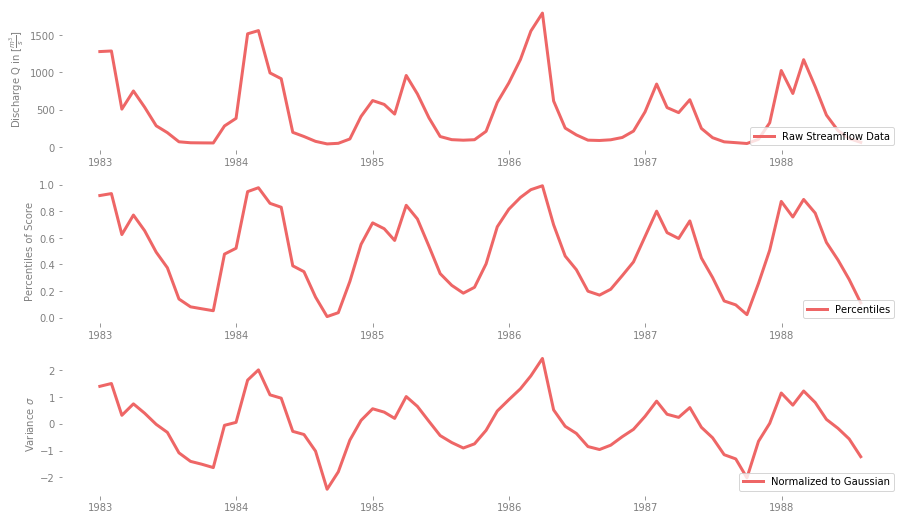

In [28]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,9))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

timespan = timeseries['date']


ax1.plot(timespan, tsMEAN, color='#EE6666', label = 'Raw Streamflow Data', linewidth=3 )
ax1.set_ylabel(r'Discharge Q in $[\frac{m^{3}}{s}]$', color='gray')
ax2.plot(timespan, tsMEAN_precentiles, color='#EE6666', label = 'Percentiles', linewidth=3 )
ax2.set_ylabel(r'Percentiles of Score',  color='gray')
ax3.plot(timespan, tsMEAN_toGaussian, color='#EE6666', label = 'Normalized to Gaussian', linewidth=3 )
ax3.set_ylabel(r'Variance $\sigma$',  color='gray')

ax1.legend(loc=4)
ax2.legend(loc=4)
ax3.legend(loc=4)

#plt.savefig('plots/TransformationSteps.svg', )

 C:\Users\marku\Anaconda3\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning:invalid value encountered in greater_equal
 C:\Users\marku\Anaconda3\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning:invalid value encountered in less_equal


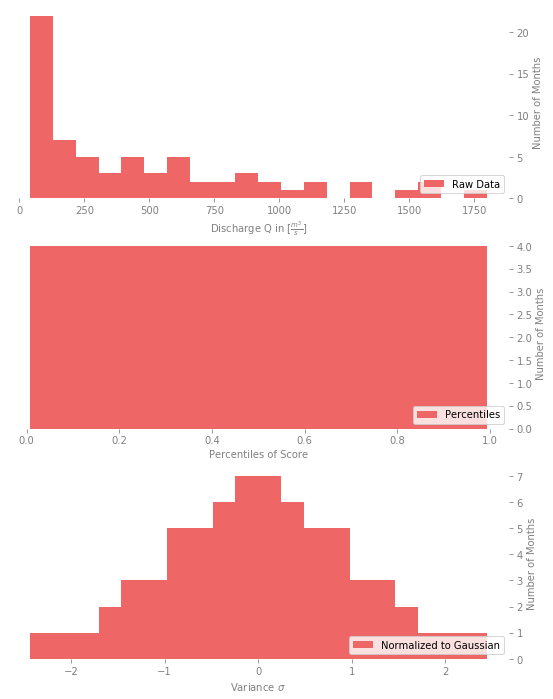

In [29]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(9,12))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)
    
ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

timespan = timeseries['date']
    

ax1.hist( tsMEAN, color='#EE6666', label = 'Raw Data', bins = 20)
ax1.set_xlabel(r'Discharge Q in $[\frac{m^{3}}{s}]$', color='gray')
ax1.set_ylabel('Number of Months', color='gray')
ax1.yaxis.set_label_position("right")
ax1.yaxis.tick_right()

ax2.hist( tsMEAN_precentiles, color='#EE6666', label = 'Percentiles', bins= 17)
ax2.set_xlabel(r'Percentiles of Score',  color='gray')
ax2.set_ylabel('Number of Months', color='gray')
ax2.yaxis.set_label_position("right")
ax2.yaxis.tick_right()

ax3.hist( tsMEAN_toGaussian, color='#EE6666', label = 'Normalized to Gaussian', bins = 20 )
ax3.set_xlabel(r'Variance $\sigma$',  color='gray')
ax3.set_ylabel('Number of Months', color='gray')
ax3.yaxis.set_label_position("right")
ax3.yaxis.tick_right()

ax1.legend(loc=4)
ax2.legend(loc=4)
ax3.legend(loc=4)

#plt.savefig('plots/Distribution.svg', )

### Check for different attributes other than monthly mean river discharge

During the analysis we focuse mainly on the monthly mean streamflow values. 

In this section we want to analyse other attributes provided by the GSIM dataset

In [30]:
def get_max_years (dataset, min_years, feature):
    max_years = []
    for df in dataset:
        if df.shape[0] >= min_years:
            arr = df[feature].to_numpy()
            arr_ = np.nan_to_num(arr, copy=True)
            maxind = np.argmax(arr_)
            if df[feature].loc[maxind] == np.nan:
                raise Exception('x should not exceed 5. The value of x was: {}'.format(x))
            else:        
                max_years.append(df['year'].loc[maxind])
        else: 
            continue
    
    m = np.unique(max_years, return_counts=True)
    return m

In [31]:
def get_all_years (dataset, min_years, feature):
    allyears = []
    for index, df in enumerate(df_yearly):
        if df.shape[0] >= min_years:
            years = df.loc[df[feature].notnull()]['year'].to_numpy()
            allyears.extend(years)
        else: 
            continue
        
    a = np.unique(allyears, return_counts=True)
    return a
    

In [32]:
def get_norm_years (ma,al):
    n = np.zeros(len(ma[0]))
    
    for idx, year in enumerate(ma[0]):
        max_discharge = ma[1][idx]
        if max_discharge != 0: 
            all_years = al[1][al[0] == year][0]
            norm = max_discharge/all_years 
            n[idx] = norm
        else: 
            n[idx] = 0
    
    return n

#### Plots for the feature MEAN

In [33]:
m0_mean = get_max_years(df_yearly, 0, 'MEAN')
a0_mean = get_all_years(df_yearly, 0, 'MEAN')
n0_mean = get_norm_years(m0_mean,a0_mean)

<BarContainer object of 89 artists>

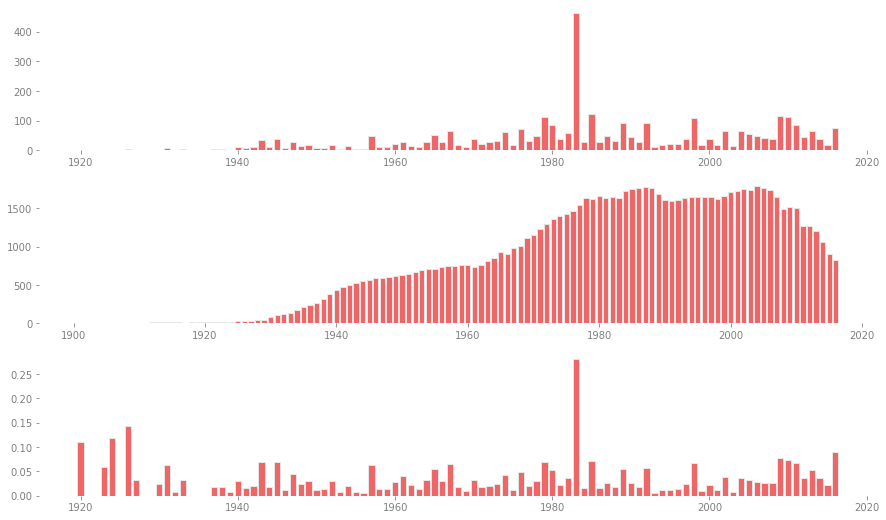

In [34]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,9))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

ax1.bar( m0_mean[0], m0_mean[1], edgecolor='#E6E6E6', color='#EE6666', label = 'amount of stations showing \nmaximum discharge in this year' )
ax2.bar( a0_mean[0], a0_mean[1], edgecolor='#E6E6E6', color='#EE6666', label = 'stations that cover this year' )
ax3.bar( m0_mean[0], n0_mean, edgecolor='#E6E6E6', color='#EE6666', label = 'percentage of stations with maximum discharge / stations that cover this year' )


#### Plots for the feature MAX

In [35]:
m0_max = get_max_years(df_yearly, 0, 'MAX')
a0_max = get_all_years(df_yearly, 0, 'MAX')
n0_max = get_norm_years(m0_max,a0_max)

<BarContainer object of 93 artists>

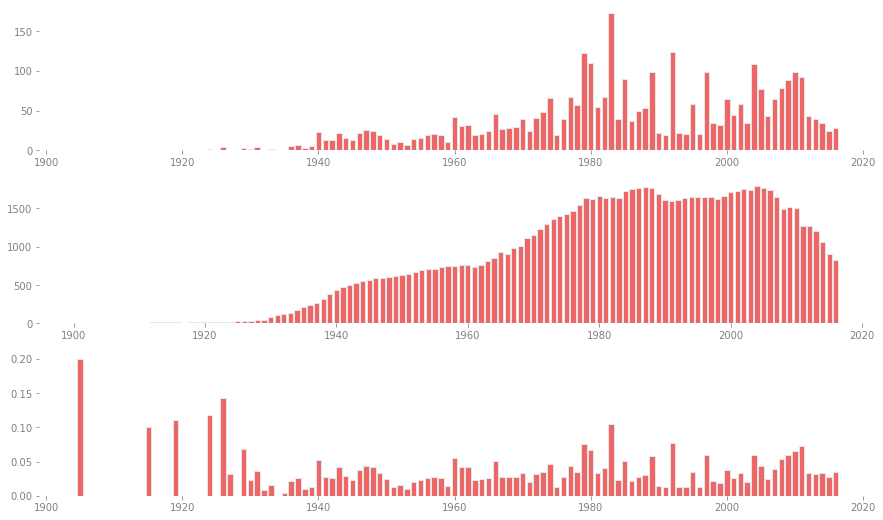

In [36]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,9))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

ax1.bar( m0_max[0], m0_max[1], edgecolor='#E6E6E6', color='#EE6666', label = 'amount of stations showing \nmaximum discharge in this year' )
ax2.bar( a0_max[0], a0_max[1], edgecolor='#E6E6E6', color='#EE6666', label = 'stations that cover this year' )
ax3.bar( m0_max[0], n0_max, edgecolor='#E6E6E6', color='#EE6666', label = 'percentage of stations with maximum discharge / stations that cover this year' )


#### Plots for the feature MAX7

In [37]:
m0_max7 = get_max_years(df_yearly, 0, 'MAX7')
a0_max7 = get_all_years(df_yearly, 0, 'MAX7')
n0_max7 = get_norm_years(m0_max7,a0_max7)

<BarContainer object of 92 artists>

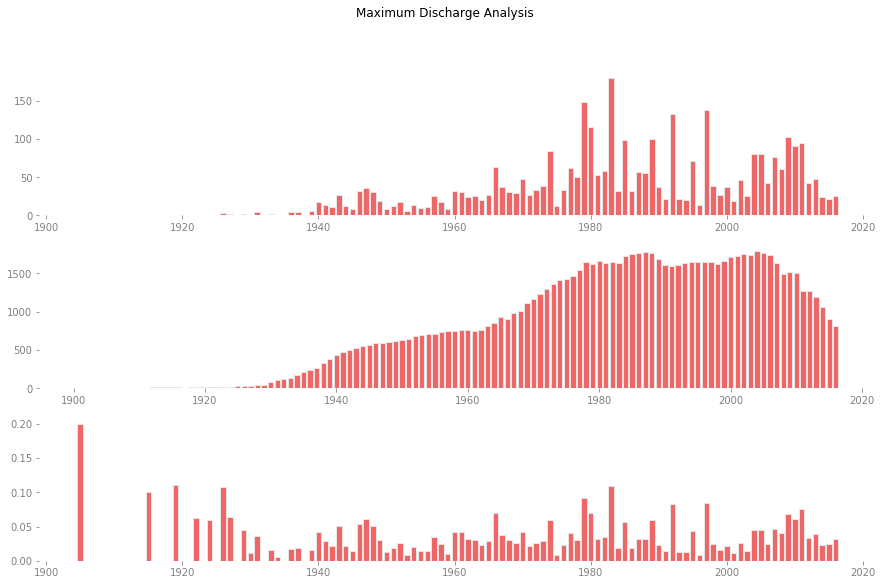

In [38]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,9))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

ax1.bar( m0_max7[0], m0_max7[1], edgecolor='#E6E6E6', color='#EE6666', label = 'amount of stations showing \nmaximum discharge in this year' )
ax2.bar( a0_max7[0], a0_max7[1], edgecolor='#E6E6E6', color='#EE6666', label = 'stations that cover this year' )
ax3.bar( m0_max7[0], n0_max7, edgecolor='#E6E6E6', color='#EE6666', label = 'percentage of stations with maximum discharge / stations that cover this year' )


#### Plots for the feature DOYMAX

In [39]:
m0_doymax = get_max_years(df_yearly, 0, 'DOYMAX')
a0_doymax = get_all_years(df_yearly, 0, 'DOYMAX')
n0_doymax = get_norm_years(m0_doymax, a0_doymax)

<BarContainer object of 95 artists>

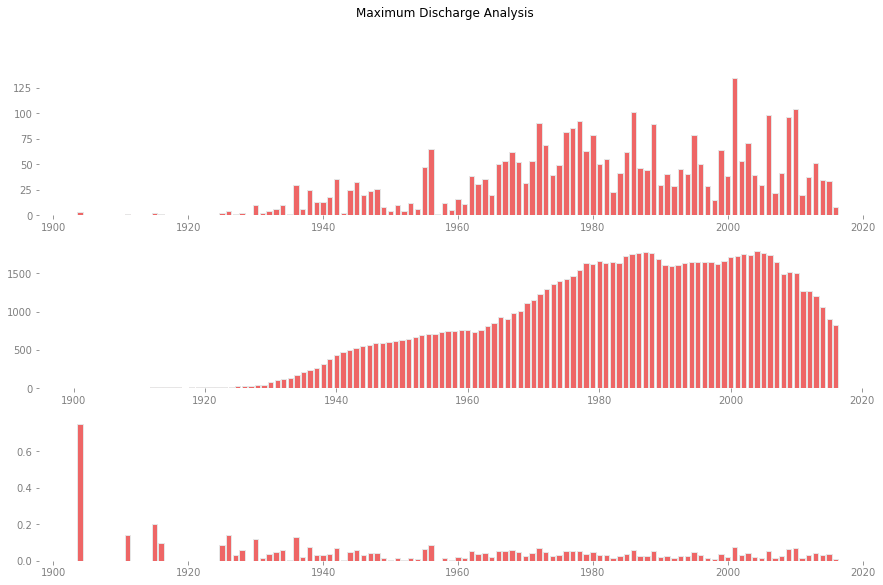

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,9))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')


ax1.bar( m0_doymax[0], m0_doymax[1], edgecolor='#E6E6E6', color='#EE6666', label = 'amount of stations showing \nmaximum discharge in this year' )
ax2.bar( a0_doymax[0], a0_doymax[1], edgecolor='#E6E6E6', color='#EE6666', label = 'stations that cover this year' )
ax3.bar( m0_doymax[0], n0_doymax, edgecolor='#E6E6E6', color='#EE6666', label = 'percentage of stations with maximum discharge / stations that cover this year' )


#### Plots for the feature DOYMAX7

In [41]:
m0_doymax = get_max_years(df_yearly, 0, 'DOYMAX7')
a0_doymax = get_all_years(df_yearly, 0, 'DOYMAX7')
n0_doymax = get_norm_years(m0_doymax, a0_doymax)

<BarContainer object of 96 artists>

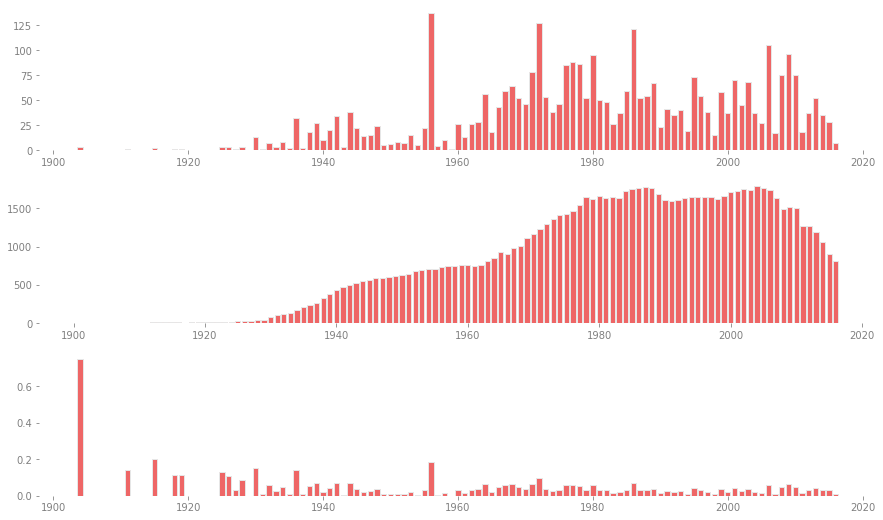

In [42]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(15,9))

for spine in ax1.spines.values():
    spine.set_visible(False)
    
for spine in ax2.spines.values():
    spine.set_visible(False)
    
for spine in ax3.spines.values():
    spine.set_visible(False)

ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')

    
ax1.bar( m0_doymax[0], m0_doymax[1], edgecolor='#E6E6E6', color='#EE6666', label = 'amount of stations showing \nmaximum discharge in this year' )
ax2.bar( a0_doymax[0], a0_doymax[1], edgecolor='#E6E6E6', color='#EE6666', label = 'stations that cover this year' )
ax3.bar( m0_doymax[0], n0_doymax, edgecolor='#E6E6E6', color='#EE6666', label = 'percentage of stations with maximum discharge / stations that cover this year' )


### RMSE analysis

In [43]:
# Warning!
# Running the RMSE analysis for all dimensions from 5 -15 takes several hours, as each dimension takes roughly 1h to compute

In [44]:
START = datetime.strptime('1960-01-01', "%Y-%m-%d").date()
END =  datetime.strptime('2016-05-31', "%Y-%m-%d").date()
NUMBER_OF_DIMENSIONS = 10
TRAIN_TEST_THRESHOLD = 0.70
SAMPLESIZE = 1000
MIN_MONTHS_OF_OVERLAP = 60
MIN_YEARS_OF_OVERLAP = 5

In [45]:
"""
Normalizes the data to a Gaussian distribution using quantiles. (function provided by Bedartha Goswami)
"""
def normalizeToGaussian(arr, mode="mean"):
    n = len(arr)
    perc = percentileofscore
    arr_ = arr.copy()[~np.isnan(arr)]
    out = np.zeros(n)
    for i in range(n):
        if not np.isnan(arr[i]):
            out[i] = norm.ppf(perc(arr_, arr[i], mode) / 100.)
        else:
            out[i] = np.nan
    return out


In [46]:
'''
In order to perform a spearmans correlation we need to truncate our predictionBase to the same timespan of our dataframe we want to process. 
This truncation happens here.
'''
def truncateBase (dataframe, base):
    start = dataframe['date'].iloc[0]
    end   = dataframe['date'].iloc[-1]
    filtered_base = [df.loc[(df['date'] >= start) & (df['date'] <= end)]  for df in base]
    
    return filtered_base

In [47]:
'''
replaces missing values in the dataframe with the mean of the month for all years from which we have data
@param dataframe
@returns dataframe
'''
def averageNaNs (df):
    mean_df = df.groupby(['month']).mean()
    averaged_mean = df['MEAN'].copy().fillna(df['month'].map({1: mean_df['MEAN'][1] , 2: mean_df['MEAN'][2], 3:mean_df['MEAN'][3],
                                                    4: mean_df['MEAN'][4] , 5: mean_df['MEAN'][5], 6:mean_df['MEAN'][6], 
                                                    7: mean_df['MEAN'][7] , 8: mean_df['MEAN'][8], 9:mean_df['MEAN'][9],
                                                    10: mean_df['MEAN'][10] , 11: mean_df['MEAN'][11], 12:mean_df['MEAN'][12]}))
    
    averaged_numpy = averaged_mean.to_numpy()
    return averaged_numpy

In [48]:
'''
Computation of Spearmas Rank Correlation
@param  target_df: a pandas.dataframe (target) for wich we want to calculate the correlation matrix 
        dataset: a list of pandas dataframes that build our base, as we check for the correlation between dataframe and each df in a dataset
@returns spearmans_matrix: a numpy.ndarray that contains the correlation value as first entry in each row and the corresponding p-value as a second element in each row. 
                            the order of the matrix is like in the dataset:
'''
def spearmansCorrelation (target_df, truncated_dataset): 
    spearmans_matrix = np.zeros((len(truncated_dataset), 2))
    for index, df in enumerate(truncated_dataset): 
        if (target_df.shape[0]!= df.shape[0]) or (df['MEAN'].isnull().all()):
            spearmans_matrix[index] = 0,100 
            continue
        else: 
            correlation, pval = stats.spearmanr(target_df['MEAN'], df['MEAN'], nan_policy='omit')
            spearmans_matrix[index] = correlation,pval    
            
    return spearmans_matrix

In [49]:
'''
Helper function to obtain the indices that show highest correlation 
@param dataframe
@returns list of correlation and p-values for each df, the indices that are above the threshold and the amount of dimensions
'''
def getIndices (spearmans_matrix, dim): 
    corr = spearmans_matrix[:,0].copy()
    indices = corr.argsort()[-dim:][::-1]
    if indices.size < dim:
        print("Less than {} timeseries while trying to get the indices".format(dim))
    
    return indices

In [50]:
'''
Based on a dataframe for which we want to fill missing values we select the most correlated timeseries of our prediction base
Then we transform and truncate the time serires so that we get input output mappings for training, and sets of input timeseries
for the time before and after the active timespan of our dataframe for which we want to infer missing data.
@param
@returns 
'''
def getDataForTrainingAndPredicting (dataframe, indices): 
    
    X_train  = []
    X_test   = []
    
    dim = indices.size
    start = dataframe['date'].iloc[0]
    end = dataframe['date'].iloc[-1]
    
    mostCorrelatedTimeseries = [predictionBase[index] for index in indices]
    
    splitind_df = int(dataframe.shape[0] * TRAIN_TEST_THRESHOLD)
    startind = max(0, mostCorrelatedTimeseries[0].loc[mostCorrelatedTimeseries[0]['date'] == start].index.values[0])
    splitind = startind + splitind_df 
    endind = min(mostCorrelatedTimeseries[0].shape[0] -1, mostCorrelatedTimeseries[0].loc[mostCorrelatedTimeseries[0]['date'] == end].index.values[0] +1)

    datesTest = mostCorrelatedTimeseries[0]['date'][splitind : endind]
    
    for ts in mostCorrelatedTimeseries: 
        tsNormalized = normalizeToGaussian(ts['MEAN'].copy().to_numpy())
        x_train = tsNormalized[startind: splitind].copy()
        
        x = normalizeToGaussian(averageNaNs(ts)).reshape(-1,1)
        x_test = x[splitind: endind].copy()
        
        X_train.append(x_train)
        X_test.append(x_test)

    X_test = np.column_stack((X_test))
    X_train = np.column_stack((X_train))
    
    Y_test = normalizeToGaussian(averageNaNs(dataframe))[splitind_df:].copy().reshape(-1,1)    
    Y_train  = normalizeToGaussian(dataframe['MEAN'].copy().to_numpy())[:splitind_df].reshape(-1,1) 
    
    
    train = np.concatenate((X_train,Y_train), axis=1)
    train_clean = train.copy()[~np.isnan(train).any(axis=1)]
    Y_train = train_clean[:,-1].reshape(-1,1)
    X_train = train_clean[:,:dim]

    return   X_train, X_test, Y_train, Y_test

In [51]:
def trainGP (X_train, Y_train, dim):
    kernel = GPy.kern.Matern32(input_dim = dim )
    model = GPy.models.GPRegression(X_train, Y_train, kernel)
    model.optimize(messages=True)
    model.optimize_restarts(num_restarts=10)    
    return model

In [52]:
randomListOfIndices =  [random.randint(0, len(predictableTimeseries)) for i in range(500)] 

In [53]:
# Warning! Running this cell takes some time
# During each iteration 500 GP models are trained such that we can compute the distribution of rmse values for this dimension

rmseList = []
for dim in range(5,16):
    rmseArray= np.zeros((len(randomListOfIndices)))
    predictionError=[]
    for counter, index in enumerate(randomListOfIndices):
        print(counter)
        df = predictableTimeseries[index]
        gsimNo = predictableTimeseries[index]['gsim.no'].any()
        truncatedBase = truncateBase (df, predictionBase)
        try:
            spearmansMatrix = spearmansCorrelation(df, truncatedBase)
        except:
            print("Could not compute spearmans matrix, for df {}".format(gsimNo))
            continue
            
        indices = getIndices(spearmansMatrix, dim)
        
        X_train, X_test, Y_train, Y_test = getDataForTrainingAndPredicting (df, indices)
        try:
            model = trainGP(X_train, Y_train, dim)
        except:
            print("could not train the model for df {}".format(gsimNo))
            continue
            
        mean, cov = model.predict(X_test)
    
        if mean.shape != Y_test.shape:
            Y_test = Y_test.copy()[:mean.shape[0]]
    
        rmseArray[counter] = math.sqrt(mean_squared_error(Y_test, mean))
        
    rmseList.append(rmseArray)
    with open ('data/predictions/rmse/rmsePredictionDim{}.pkl'.format(dim), 'wb') as outp:
        pickle.dump(rmseArray, outp, pickle.HIGHEST_PROTOCOL )
    

0


Optimization restart 1/10, f = 117.32501369980733
Optimization restart 2/10, f = 117.32501369931055
Optimization restart 3/10, f = 117.32501370378975
Optimization restart 4/10, f = 117.32501406206293
Optimization restart 5/10, f = 117.32501478764743
Optimization restart 6/10, f = 117.3250136991127
Optimization restart 7/10, f = 117.3250137046069
Optimization restart 8/10, f = 117.32501369921451
Optimization restart 9/10, f = 117.32501370328336
Optimization restart 10/10, f = 117.32501369925683
1


Optimization restart 1/10, f = 256.5921496720154
Optimization restart 2/10, f = 256.5921497052334
Optimization restart 3/10, f = 256.5921496734331
Optimization restart 4/10, f = 256.5921496940789
Optimization restart 5/10, f = 256.59214967110165
Optimization restart 6/10, f = 256.5921496718066
Optimization restart 7/10, f = 256.59214967105095
Optimization restart 8/10, f = 256.5921496719051
Optimization restart 9/10, f = 256.59214967739274
Optimization restart 10/10, f = 256.5921496736373
2


Optimization restart 1/10, f = 411.31205952967423
Optimization restart 2/10, f = 411.3120595298916
Optimization restart 3/10, f = 411.31206026220855
Optimization restart 4/10, f = 411.3120595295634
Optimization restart 5/10, f = 411.3120595296616
Optimization restart 6/10, f = 411.31205952917
Optimization restart 7/10, f = 411.31205954808513
Optimization restart 8/10, f = 411.3120595379444
Optimization restart 9/10, f = 411.31205952903156
Optimization restart 10/10, f = 411.31205952920493
3


Optimization restart 1/10, f = 37.5138795736312
Optimization restart 2/10, f = 37.97795801954624
Optimization restart 3/10, f = 37.51387957362247
Optimization restart 4/10, f = 37.97795806121917
Optimization restart 5/10, f = 37.51387957362549
Optimization restart 6/10, f = 37.51387957458431
Optimization restart 7/10, f = 37.513879573628756
Optimization restart 8/10, f = 37.51387957395247
Optimization restart 9/10, f = 37.97795805943979
Optimization restart 10/10, f = 37.51387957367696
4


Optimization restart 1/10, f = 141.24109249465036
Optimization restart 2/10, f = 141.2410924910954
Optimization restart 3/10, f = 141.2410924909596
Optimization restart 4/10, f = 141.24109249134324
Optimization restart 5/10, f = 141.2410925044071
Optimization restart 6/10, f = 141.24109249211284
Optimization restart 7/10, f = 141.24109266304626
Optimization restart 8/10, f = 141.24109249203184
Optimization restart 9/10, f = 141.24109253083913
Optimization restart 10/10, f = 141.24109249130973
5


Optimization restart 1/10, f = 284.343917441039
Optimization restart 2/10, f = 284.34391749572796
Optimization restart 3/10, f = 284.34391744966604
Optimization restart 4/10, f = 284.34391742225023
Optimization restart 5/10, f = 284.3439174059423
Optimization restart 6/10, f = 284.3439174060353
Optimization restart 7/10, f = 284.34391742838795
Optimization restart 8/10, f = 284.34391742578475
Optimization restart 9/10, f = 284.3439174130794
Optimization restart 10/10, f = 284.34391740595277
6


Optimization restart 1/10, f = 367.2833712183542
Optimization restart 2/10, f = 367.28337120791787
Optimization restart 3/10, f = 367.2833712268515
Optimization restart 4/10, f = 367.28337121532365
Optimization restart 5/10, f = 367.2833712084341
Optimization restart 6/10, f = 367.2833712120405
Optimization restart 7/10, f = 367.28337121988534
Optimization restart 8/10, f = 367.2833712092676
Optimization restart 9/10, f = 367.2833714147868
Optimization restart 10/10, f = 367.28337122924745
7


Optimization restart 1/10, f = 123.62427737988828
Optimization restart 2/10, f = 123.62427738110742
Optimization restart 3/10, f = 123.62427737991317
Optimization restart 4/10, f = 123.62427737991163
Optimization restart 5/10, f = 123.62427737993097
Optimization restart 6/10, f = 123.6242774275917
Optimization restart 7/10, f = 123.62427738114081
Optimization restart 8/10, f = 123.6242773818989
Optimization restart 9/10, f = 123.624277379942
Optimization restart 10/10, f = 123.62427738106058
8


Optimization restart 1/10, f = 35.506604764212724
Optimization restart 2/10, f = 35.506604765276336
Optimization restart 3/10, f = 35.50660476418998
Optimization restart 4/10, f = 35.50660479083799
Optimization restart 5/10, f = 35.50660476419759
Optimization restart 6/10, f = 35.50660476420353
Optimization restart 7/10, f = 35.50660476429922
Optimization restart 8/10, f = 35.506604838233045
Optimization restart 9/10, f = 35.506604783196735
Optimization restart 10/10, f = 35.506604764204326
9


Optimization restart 1/10, f = 34.014107648145725
Optimization restart 2/10, f = 34.01410764819474
Optimization restart 3/10, f = 34.01410764816674
Optimization restart 4/10, f = 34.0141076481479
Optimization restart 5/10, f = 34.01410764823153
Optimization restart 6/10, f = 34.01410764814622
Optimization restart 7/10, f = 34.014107648309505
Optimization restart 8/10, f = 34.01410764815142
Optimization restart 9/10, f = 34.014107648222264
Optimization restart 10/10, f = 34.01410764905576
10


Optimization restart 1/10, f = 210.94287256982614
Optimization restart 2/10, f = 210.94287260223325
Optimization restart 3/10, f = 210.94287257824055
Optimization restart 4/10, f = 210.9428725760209
Optimization restart 5/10, f = 210.94287257010242
Optimization restart 6/10, f = 210.94287260730817
Optimization restart 7/10, f = 210.9428725695605
Optimization restart 8/10, f = 210.94287257087103
Optimization restart 9/10, f = 210.94287256959808
Optimization restart 10/10, f = 210.94287264422638
11


Optimization restart 1/10, f = 379.2249356799369
Optimization restart 2/10, f = 379.2249356755283
Optimization restart 3/10, f = 379.22493567669153
Optimization restart 4/10, f = 379.2249357084718
Optimization restart 5/10, f = 379.22493567831225
Optimization restart 6/10, f = 379.22493567558377
Optimization restart 7/10, f = 379.22493567567915
Optimization restart 8/10, f = 379.224935749799
Optimization restart 9/10, f = 379.224935690953
Optimization restart 10/10, f = 379.2249356758522
12


Optimization restart 1/10, f = 55.68416484400308
Optimization restart 2/10, f = 55.68416478927634
Optimization restart 3/10, f = 55.68416478906012
Optimization restart 4/10, f = 55.68416478913774
Optimization restart 5/10, f = 55.68416478926103
Optimization restart 6/10, f = 55.68416478904777
Optimization restart 7/10, f = 55.684164789061924
Optimization restart 8/10, f = 55.68416478905354
Optimization restart 9/10, f = 55.684164789373625
Optimization restart 10/10, f = 55.68416478908131
13
Could not compute spearmans matrix, for df BR_0001351
14


Optimization restart 1/10, f = 172.3122834843903
Optimization restart 2/10, f = 172.31228348538116
Optimization restart 3/10, f = 172.31228349548792
Optimization restart 4/10, f = 172.31228348484893
Optimization restart 5/10, f = 172.31228350079317
Optimization restart 6/10, f = 172.31228351088703
Optimization restart 7/10, f = 172.31228379701443
Optimization restart 8/10, f = 172.31228348448855
Optimization restart 9/10, f = 172.3122834846951
Optimization restart 10/10, f = 172.31228348440078
15


Optimization restart 1/10, f = 4.625761621876755
Optimization restart 2/10, f = 4.625761076723493
Optimization restart 3/10, f = 4.625761232150122
Optimization restart 4/10, f = 4.6257613045977575
Optimization restart 5/10, f = 4.625761094831441
Optimization restart 6/10, f = 4.625761063947181
Optimization restart 7/10, f = 4.625761067253986
Optimization restart 8/10, f = 4.625762721513304
Optimization restart 9/10, f = 4.62576106394025
Optimization restart 10/10, f = 4.625761667025037
16
Could not compute spearmans matrix, for df BR_0001754
17


Optimization restart 1/10, f = 80.8261515429709
Optimization restart 2/10, f = 80.82615154256543
Optimization restart 3/10, f = 80.82615154269763
Optimization restart 4/10, f = 80.82615154185999
Optimization restart 5/10, f = 80.82615154183202
Optimization restart 6/10, f = 80.82615154174033
Optimization restart 7/10, f = 80.82615154585744
Optimization restart 8/10, f = 80.82615154184379
Optimization restart 9/10, f = 80.82615154352968
Optimization restart 10/10, f = 80.82615154177435
18
could not train the model for df BR_0001401
19


Optimization restart 1/10, f = 17.40055099914183
Optimization restart 2/10, f = 17.40055099914339
Optimization restart 3/10, f = 17.400550999140822
Optimization restart 4/10, f = 17.40055099915682
Optimization restart 5/10, f = 17.400550999147004
Optimization restart 6/10, f = 17.400550999212705
Optimization restart 7/10, f = 17.400550999147622
Optimization restart 8/10, f = 17.400550999164054
Optimization restart 9/10, f = 17.400550999174257
Optimization restart 10/10, f = 17.40055102467916
20


Optimization restart 1/10, f = 117.0471741144427
Optimization restart 2/10, f = 117.0471741135558
Optimization restart 3/10, f = 117.04717411303173
Optimization restart 4/10, f = 117.047174188974
Optimization restart 5/10, f = 117.04717411772154
Optimization restart 6/10, f = 117.04717411769218
Optimization restart 7/10, f = 117.04717411387594
Optimization restart 8/10, f = 117.04717411550416
Optimization restart 9/10, f = 117.04717412388791
Optimization restart 10/10, f = 117.04717411293569
21


Optimization restart 1/10, f = 119.55372541751504
Optimization restart 2/10, f = 119.55383514816984
Optimization restart 3/10, f = 119.55379936098922
Optimization restart 4/10, f = 119.55372541742321
Optimization restart 5/10, f = 119.55372541739547
Optimization restart 6/10, f = 119.55372544761093
Optimization restart 7/10, f = 119.55372541740451
Optimization restart 8/10, f = 119.55372541741639
Optimization restart 9/10, f = 119.55372541756614
Optimization restart 10/10, f = 119.55372541777172
22


Optimization restart 1/10, f = 45.241481629354354
Optimization restart 2/10, f = 45.24148162891461
Optimization restart 3/10, f = 45.241481628859106
Optimization restart 4/10, f = 45.24148163152421
Optimization restart 5/10, f = 45.24148163076745
Optimization restart 6/10, f = 45.24148166092988
Optimization restart 7/10, f = 45.24148162897691
Optimization restart 8/10, f = 45.241481630247506
Optimization restart 9/10, f = 45.24148174895214
Optimization restart 10/10, f = 45.24148162895739
23


Optimization restart 1/10, f = 89.31151775931521
Optimization restart 2/10, f = 89.3115177597435
Optimization restart 3/10, f = 89.311517759698
Optimization restart 4/10, f = 89.31151775903857
Optimization restart 5/10, f = 89.31151775937029
Optimization restart 6/10, f = 89.31151782075563
Optimization restart 7/10, f = 89.31151775904047
Optimization restart 8/10, f = 89.31151775904323
Optimization restart 9/10, f = 89.3115177694243
Optimization restart 10/10, f = 89.31151775904351
24
could not train the model for df BR_0002961
25
could not train the model for df BR_0002966
26


Optimization restart 1/10, f = 139.78175878717784
Optimization restart 2/10, f = 139.78175878826892
Optimization restart 3/10, f = 139.7817587871442
Optimization restart 4/10, f = 139.78175878718542
Optimization restart 5/10, f = 139.78175879124242
Optimization restart 6/10, f = 139.781758787837
Optimization restart 7/10, f = 139.78175878712972
Optimization restart 8/10, f = 139.78175878713762
Optimization restart 9/10, f = 139.7817587871317
Optimization restart 10/10, f = 139.78175878720455
27


Optimization restart 1/10, f = 60.63893590226291
Optimization restart 2/10, f = 60.63893590156272
Optimization restart 3/10, f = 60.638935901688114
Optimization restart 4/10, f = 60.63893590836331
Optimization restart 5/10, f = 60.63893590231394
Optimization restart 6/10, f = 60.63893590147238
Optimization restart 7/10, f = 60.63893590163695
Optimization restart 8/10, f = 60.63893590140535
Optimization restart 9/10, f = 60.63893590140452
Optimization restart 10/10, f = 60.638935956421605
28


Optimization restart 1/10, f = -4.219619552071187
Optimization restart 2/10, f = -4.219619559567185
Optimization restart 3/10, f = -4.219619559615673
Optimization restart 4/10, f = -4.2196195596020445
Optimization restart 5/10, f = -4.219619559623773
Optimization restart 6/10, f = -4.219619454194778
Optimization restart 7/10, f = -4.219619559436872
Optimization restart 8/10, f = -4.219619559603807
Optimization restart 9/10, f = -4.219619559593589
Optimization restart 10/10, f = -4.219619559506263
29
Could not compute spearmans matrix, for df BR_0000839
30


Optimization restart 1/10, f = 99.95385336884368
Optimization restart 2/10, f = 99.95385336874568
Optimization restart 3/10, f = 99.95385336814246
Optimization restart 4/10, f = 99.9538533691483
Optimization restart 5/10, f = 99.95385336812177
Optimization restart 6/10, f = 99.95385336920162
Optimization restart 7/10, f = 99.9538533696666
Optimization restart 8/10, f = 99.95385340699167
Optimization restart 9/10, f = 99.9538533682269
Optimization restart 10/10, f = 99.95385336813158
31
could not train the model for df BR_0000681
32
Could not compute spearmans matrix, for df BR_0000899
33
could not train the model for df BR_0001534
34


Optimization restart 1/10, f = -0.07048010589296183
Optimization restart 2/10, f = -0.07048010588462006
Optimization restart 3/10, f = -0.0704801058869009
Optimization restart 4/10, f = -0.07048010588963649
Optimization restart 5/10, f = -0.07048010589694798
Optimization restart 6/10, f = -0.07048010588911069
Optimization restart 7/10, f = -0.07048010589274156
Optimization restart 8/10, f = -0.07048010588743381
Optimization restart 9/10, f = -0.07048010589412712
Optimization restart 10/10, f = -0.07048010589087284
35


Optimization restart 1/10, f = 149.43636350270162
Optimization restart 2/10, f = 149.43636353505872
Optimization restart 3/10, f = 149.4363635026575
Optimization restart 4/10, f = 149.4363635025751
Optimization restart 5/10, f = 149.436363548589
Optimization restart 6/10, f = 149.43636350290663
Optimization restart 7/10, f = 149.43636366025447
Optimization restart 8/10, f = 149.4363635025361
Optimization restart 9/10, f = 149.4363635056214
Optimization restart 10/10, f = 149.4363635037001
36


Optimization restart 1/10, f = 14.346454126386659
Optimization restart 2/10, f = 14.346454126478697
Optimization restart 3/10, f = 14.346454126899998
Optimization restart 4/10, f = 14.346454126373029
Optimization restart 5/10, f = 14.34645412628529
Optimization restart 6/10, f = 14.346454126290084
Optimization restart 7/10, f = 14.346454126301158
Optimization restart 8/10, f = 14.346454126290933
Optimization restart 9/10, f = 14.346454130157461
Optimization restart 10/10, f = 14.346454126302174
37


Optimization restart 1/10, f = 83.13527749974696
Optimization restart 2/10, f = 83.13527749903378
Optimization restart 3/10, f = 83.13527750169351
Optimization restart 4/10, f = 83.13527761054374
Optimization restart 5/10, f = 83.13527758516341
Optimization restart 6/10, f = 83.13527750034297
Optimization restart 7/10, f = 83.13527750284877
Optimization restart 8/10, f = 83.13527749614259
Optimization restart 9/10, f = 83.13527750473516
Optimization restart 10/10, f = 83.13527749614124
38


Optimization restart 1/10, f = 145.69460400102213
Optimization restart 2/10, f = 145.69460636625215
Optimization restart 3/10, f = 145.6946066062834
Optimization restart 4/10, f = 145.69460400078475
Optimization restart 5/10, f = 145.69460401796624
Optimization restart 6/10, f = 145.69460400325704
Optimization restart 7/10, f = 145.69460400648822
Optimization restart 8/10, f = 145.69460400079527
Optimization restart 9/10, f = 145.6946040010805
Optimization restart 10/10, f = 145.69460400223525
39
could not train the model for df BR_0000285
40


Optimization restart 1/10, f = 20.482519663748743
Optimization restart 2/10, f = 20.482519663753003
Optimization restart 3/10, f = 20.482519663898717
Optimization restart 4/10, f = 20.48251966375442
Optimization restart 5/10, f = 20.482519664031383
Optimization restart 6/10, f = 20.48251966405092
Optimization restart 7/10, f = 20.482519664734603
Optimization restart 8/10, f = 20.48251966374893
Optimization restart 9/10, f = 20.48251966422355
Optimization restart 10/10, f = 20.48251966380482
41


Optimization restart 1/10, f = 209.28489432311574
Optimization restart 2/10, f = 209.2848943251686
Optimization restart 3/10, f = 209.28489432357605
Optimization restart 4/10, f = 209.28489435075764
Optimization restart 5/10, f = 209.28489441489165
Optimization restart 6/10, f = 209.2848943246666
Optimization restart 7/10, f = 209.28489432601813
Optimization restart 8/10, f = 209.28489432310658
Optimization restart 9/10, f = 209.28489432419985
Optimization restart 10/10, f = 209.28489435782808
42


Optimization restart 1/10, f = 162.89198037322956
Optimization restart 2/10, f = 162.8919803728615
Optimization restart 3/10, f = 162.89198039445293
Optimization restart 4/10, f = 162.89198037284123
Optimization restart 5/10, f = 162.89198039081995
Optimization restart 6/10, f = 162.8919803728308
Optimization restart 7/10, f = 162.8919803750636
Optimization restart 8/10, f = 162.8919803779335
Optimization restart 9/10, f = 162.8919803738729
Optimization restart 10/10, f = 162.89198037330578
43


Optimization restart 1/10, f = 291.3615594270448
Optimization restart 2/10, f = 291.36155942703164
Optimization restart 3/10, f = 291.3615594266555
Optimization restart 4/10, f = 291.3615594276156
Optimization restart 5/10, f = 291.36155988566014
Optimization restart 6/10, f = 291.361559464117
Optimization restart 7/10, f = 291.3615594265492
Optimization restart 8/10, f = 291.36155942663333
Optimization restart 9/10, f = 291.3615594265751
Optimization restart 10/10, f = 291.36155942716033
44


Optimization restart 1/10, f = 215.0538776877887
Optimization restart 2/10, f = 215.05387768782458
Optimization restart 3/10, f = 215.05387768778516
Optimization restart 4/10, f = 215.05387768789305
Optimization restart 5/10, f = 215.05387768795327
Optimization restart 6/10, f = 215.0538776922321
Optimization restart 7/10, f = 215.05387768781983
Optimization restart 8/10, f = 215.0538776880716
Optimization restart 9/10, f = 215.0538777017566
Optimization restart 10/10, f = 215.05387769416924
45


Optimization restart 1/10, f = 55.139702540950466
Optimization restart 2/10, f = 55.139702540280354
Optimization restart 3/10, f = 55.13970254037952
Optimization restart 4/10, f = 55.13970254039262
Optimization restart 5/10, f = 55.139702540308065
Optimization restart 6/10, f = 55.13970254079726
Optimization restart 7/10, f = 55.13970254027659
Optimization restart 8/10, f = 55.13970254041756
Optimization restart 9/10, f = 55.13970254130246
Optimization restart 10/10, f = 55.13970254041867
46


 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:overflow encountered in multiply
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 172.20358525307284
Optimization restart 2/10, f = 172.0803907417903
Optimization restart 3/10, f = 172.08039078670026
Optimization restart 4/10, f = 172.08040044362858
Optimization restart 5/10, f = 172.0803907421162
Optimization restart 6/10, f = 172.08039096508466
Optimization restart 7/10, f = 172.08316226344868
Optimization restart 8/10, f = 172.08040831841666
Optimization restart 9/10, f = 172.0803907439073
Optimization restart 10/10, f = 172.08039083596722
47


Optimization restart 1/10, f = 73.98707547294563
Optimization restart 2/10, f = 73.98707547253659
Optimization restart 3/10, f = 73.98707547245895
Optimization restart 4/10, f = 73.98707547189863
Optimization restart 5/10, f = 73.98707547281658
Optimization restart 6/10, f = 73.98707548559125
Optimization restart 7/10, f = 73.98707547192268
Optimization restart 8/10, f = 73.98707547188663
Optimization restart 9/10, f = 73.9870754721002
Optimization restart 10/10, f = 73.98707548333155
48


Optimization restart 1/10, f = 34.503452959613
Optimization restart 2/10, f = 34.50345295996299
Optimization restart 3/10, f = 34.50345296030558
Optimization restart 4/10, f = 34.503452959609156
Optimization restart 5/10, f = 34.50345295960832
Optimization restart 6/10, f = 34.50345295966488
Optimization restart 7/10, f = 34.50345295959801
Optimization restart 8/10, f = 34.50345295994164
Optimization restart 9/10, f = 34.50345295966182
Optimization restart 10/10, f = 34.50345296015819
49


Optimization restart 1/10, f = 152.6010425475974
Optimization restart 2/10, f = 152.60104255008508
Optimization restart 3/10, f = 152.60104254759446
Optimization restart 4/10, f = 152.60104254814487
Optimization restart 5/10, f = 152.60104254846374
Optimization restart 6/10, f = 152.60104254759122
Optimization restart 7/10, f = 152.6010425475723
Optimization restart 8/10, f = 152.60104254757482
Optimization restart 9/10, f = 152.60104254866107
Optimization restart 10/10, f = 152.6010425475878
50


Optimization restart 1/10, f = 121.56932895979124
Optimization restart 2/10, f = 121.56932896711115
Optimization restart 3/10, f = 121.56932896012906
Optimization restart 4/10, f = 121.56932897498218
Optimization restart 5/10, f = 121.56932896044817
Optimization restart 6/10, f = 121.56932895980486
Optimization restart 7/10, f = 121.56932895998284
Optimization restart 8/10, f = 121.5693289597541
Optimization restart 9/10, f = 121.5693289597823
Optimization restart 10/10, f = 121.56932896003406
51


Optimization restart 1/10, f = 210.36228106567552
Optimization restart 2/10, f = 210.36228106741834
Optimization restart 3/10, f = 210.36228107769423
Optimization restart 4/10, f = 210.36228106570954
Optimization restart 5/10, f = 210.36228107595815
Optimization restart 6/10, f = 210.36228106560588
Optimization restart 7/10, f = 210.36228106561057
Optimization restart 8/10, f = 210.3622810655874
Optimization restart 9/10, f = 210.3622810655806
Optimization restart 10/10, f = 210.3622810655828
52


Optimization restart 1/10, f = -7.415224042966429
Optimization restart 2/10, f = -7.415224042986722
Optimization restart 3/10, f = -7.415224042940906
Optimization restart 4/10, f = -7.4152240429828
Optimization restart 5/10, f = -7.415224043007555
Optimization restart 6/10, f = -7.415224043006447
Optimization restart 7/10, f = -7.4152240429803555
Optimization restart 8/10, f = -7.415224042987774
Optimization restart 9/10, f = -7.4152240393441105
Optimization restart 10/10, f = -7.415224041719114
53
could not train the model for df BR_0000413
54


Optimization restart 1/10, f = 54.36603751754
Optimization restart 2/10, f = 54.36603752120695
Optimization restart 3/10, f = 54.36603751754079
Optimization restart 4/10, f = 54.36603751767191
Optimization restart 5/10, f = 54.36603751948552
Optimization restart 6/10, f = 54.36603751777317
Optimization restart 7/10, f = 54.36603751781751
Optimization restart 8/10, f = 54.36603751754308
Optimization restart 9/10, f = 54.3660375187272
Optimization restart 10/10, f = 54.366037584591346
55


Optimization restart 1/10, f = 74.20666103230415
Optimization restart 2/10, f = 74.20666103237198
Optimization restart 3/10, f = 74.20666103424114
Optimization restart 4/10, f = 74.20666103225747
Optimization restart 5/10, f = 74.20666103259816
Optimization restart 6/10, f = 74.20666103775812
Optimization restart 7/10, f = 74.20666103225504
Optimization restart 8/10, f = 74.2066610322837
Optimization restart 9/10, f = 74.2066610324013
Optimization restart 10/10, f = 74.20666103249783
56


Optimization restart 1/10, f = 122.69731541192398
Optimization restart 2/10, f = 122.6973154120132
Optimization restart 3/10, f = 122.69731541331086
Optimization restart 4/10, f = 122.69731541191567
Optimization restart 5/10, f = 122.69731541190396
Optimization restart 6/10, f = 122.69731541189735
Optimization restart 7/10, f = 122.69731541289046
Optimization restart 8/10, f = 122.6973154121861
Optimization restart 9/10, f = 122.69731544485887
Optimization restart 10/10, f = 122.69731541201035
57


Optimization restart 1/10, f = 218.18391395723296
Optimization restart 2/10, f = 218.18391395060107
Optimization restart 3/10, f = 218.18391393663507
Optimization restart 4/10, f = 218.18391393806974
Optimization restart 5/10, f = 218.1839139366793
Optimization restart 6/10, f = 218.18391393668165
Optimization restart 7/10, f = 218.18391393658675
Optimization restart 8/10, f = 218.1839139368937
Optimization restart 9/10, f = 218.1839139365629
Optimization restart 10/10, f = 218.18391393699315
58


Optimization restart 1/10, f = 65.03105685106638
Optimization restart 2/10, f = 65.03105685140082
Optimization restart 3/10, f = 65.03105685096577
Optimization restart 4/10, f = 65.03105685103824
Optimization restart 5/10, f = 65.03105685095852
Optimization restart 6/10, f = 65.03105685103282
Optimization restart 7/10, f = 65.03105685114683
Optimization restart 8/10, f = 65.03105690547812
Optimization restart 9/10, f = 65.03105685096783
Optimization restart 10/10, f = 65.03105687238178
59


Optimization restart 1/10, f = 184.11559941482292
Optimization restart 2/10, f = 184.11559941335716
Optimization restart 3/10, f = 184.11559941338416
Optimization restart 4/10, f = 184.11559941504999
Optimization restart 5/10, f = 184.11559941586006
Optimization restart 6/10, f = 184.1155996620517
Optimization restart 7/10, f = 184.1155994359765
Optimization restart 8/10, f = 184.11559944235336
Optimization restart 9/10, f = 184.11559941344558
Optimization restart 10/10, f = 184.11559941332305
60


Optimization restart 1/10, f = 50.16079427391915
Optimization restart 2/10, f = 50.16079427420103
Optimization restart 3/10, f = 50.16079427393362
Optimization restart 4/10, f = 50.16079428098003
Optimization restart 5/10, f = 50.16079427499408
Optimization restart 6/10, f = 50.160794278847426
Optimization restart 7/10, f = 50.1607942765428
Optimization restart 8/10, f = 50.160794274932684
Optimization restart 9/10, f = 50.16079427398113
Optimization restart 10/10, f = 50.1607942739801
61


Optimization restart 1/10, f = 25.711169178466378
Optimization restart 2/10, f = 25.71116917824979
Optimization restart 3/10, f = 25.711169178252675
Optimization restart 4/10, f = 25.711169178249936
Optimization restart 5/10, f = 25.71116917831688
Optimization restart 6/10, f = 25.711169178273597
Optimization restart 7/10, f = 25.711169178377194
Optimization restart 8/10, f = 25.71116917825001
Optimization restart 9/10, f = 25.711169178314357
Optimization restart 10/10, f = 25.711169187376008
62


Optimization restart 1/10, f = 80.8261515429709
Optimization restart 2/10, f = 80.82615154188004
Optimization restart 3/10, f = 80.82615154433088
Optimization restart 4/10, f = 80.82615154183893
Optimization restart 5/10, f = 80.82615154190539
Optimization restart 6/10, f = 80.82615154178728
Optimization restart 7/10, f = 80.8261515418987
Optimization restart 8/10, f = 80.8261515418441
Optimization restart 9/10, f = 80.82615154182616
Optimization restart 10/10, f = 80.82615154183217
63


Optimization restart 1/10, f = 122.83481262303906
Optimization restart 2/10, f = 122.83481262032451
Optimization restart 3/10, f = 122.83481262295358
Optimization restart 4/10, f = 122.83481262050199
Optimization restart 5/10, f = 122.83481262036298
Optimization restart 6/10, f = 122.83481262117122
Optimization restart 7/10, f = 122.83481262032309
Optimization restart 8/10, f = 122.83481262032612
Optimization restart 9/10, f = 122.83481262100395
Optimization restart 10/10, f = 122.83481262033489
64


Optimization restart 1/10, f = 36.961790727268145
Optimization restart 2/10, f = 36.9617907311744
Optimization restart 3/10, f = 36.961790727016606
Optimization restart 4/10, f = 36.961790727149975
Optimization restart 5/10, f = 36.96179072697016
Optimization restart 6/10, f = 36.96179072711429
Optimization restart 7/10, f = 36.96179072696393
Optimization restart 8/10, f = 36.96179072732465
Optimization restart 9/10, f = 36.961790727119116
Optimization restart 10/10, f = 36.96179072697201
65


Optimization restart 1/10, f = 25.653371625337485
Optimization restart 2/10, f = 25.653371624939773
Optimization restart 3/10, f = 25.653371625210582
Optimization restart 4/10, f = 25.65337162496177
Optimization restart 5/10, f = 25.65337201111327
Optimization restart 6/10, f = 25.653371625009683
Optimization restart 7/10, f = 25.653371624940654
Optimization restart 8/10, f = 25.653371659670192
Optimization restart 9/10, f = 25.653371654574677
Optimization restart 10/10, f = 25.65337162490846
66


Optimization restart 1/10, f = 7.98342694796429
Optimization restart 2/10, f = 7.983426944379914
Optimization restart 3/10, f = 7.983426944371104
Optimization restart 4/10, f = 7.983426944368688
Optimization restart 5/10, f = 7.983426944482005
Optimization restart 6/10, f = 7.983426944380426
Optimization restart 7/10, f = 7.983426971986489
Optimization restart 8/10, f = 7.983426944370905
Optimization restart 9/10, f = 7.983426944370706
Optimization restart 10/10, f = 7.983426944372468
67


Optimization restart 1/10, f = 78.32365215654906
Optimization restart 2/10, f = 78.32365210949779
Optimization restart 3/10, f = 78.32365210849312
Optimization restart 4/10, f = 78.32365210574065
Optimization restart 5/10, f = 78.32365210583397
Optimization restart 6/10, f = 78.32365210569236
Optimization restart 7/10, f = 78.32365210574753
Optimization restart 8/10, f = 78.32365210789101
Optimization restart 9/10, f = 78.32365321347767
Optimization restart 10/10, f = 78.32365220503307
68


Optimization restart 1/10, f = 221.75996118104354


 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:overflow encountered in multiply
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:invalid value encountered in multiply


Optimization restart 2/10, f = 221.76986172678474
Optimization restart 3/10, f = 221.75996118085334
Optimization restart 4/10, f = 221.75996118097285
Optimization restart 5/10, f = 221.75996118182852
Optimization restart 6/10, f = 221.75996121403114
Optimization restart 7/10, f = 221.75996118323638
Optimization restart 8/10, f = 221.75996137888842
Optimization restart 9/10, f = 221.75996200221243
Optimization restart 10/10, f = 221.76036293404863
69


Optimization restart 1/10, f = 63.694189737669205
Optimization restart 2/10, f = 63.694189737669646
Optimization restart 3/10, f = 63.694189755151456
Optimization restart 4/10, f = 63.69418973764478
Optimization restart 5/10, f = 63.69418973922091
Optimization restart 6/10, f = 63.69418973765292
Optimization restart 7/10, f = 63.69418973847036
Optimization restart 8/10, f = 63.69418973770474
Optimization restart 9/10, f = 63.69418973864731
Optimization restart 10/10, f = 63.69418973764902
70


Optimization restart 1/10, f = 277.8556518557184
Optimization restart 2/10, f = 277.8556518779547
Optimization restart 3/10, f = 277.8556518565281
Optimization restart 4/10, f = 277.8556519358548
Optimization restart 5/10, f = 277.855651864258
Optimization restart 6/10, f = 277.8556518579494
Optimization restart 7/10, f = 277.85565194992427
Optimization restart 8/10, f = 277.8556518587303
Optimization restart 9/10, f = 277.8556518870512
Optimization restart 10/10, f = 277.8556518580379
71


Optimization restart 1/10, f = 81.96942072783976
Optimization restart 2/10, f = 81.9694207270232
Optimization restart 3/10, f = 81.96942072508504
Optimization restart 4/10, f = 81.96942072578928
Optimization restart 5/10, f = 81.96942072492567
Optimization restart 6/10, f = 81.9694207249097
Optimization restart 7/10, f = 81.96942077792832
Optimization restart 8/10, f = 81.96942072732382
Optimization restart 9/10, f = 81.96942072548163
Optimization restart 10/10, f = 81.96942072492723
72
Could not compute spearmans matrix, for df BR_0001907
73
could not train the model for df BR_0003305
74


Optimization restart 1/10, f = 51.70967139891695
Optimization restart 2/10, f = 51.709681888866214
Optimization restart 3/10, f = 51.70967143422868
Optimization restart 4/10, f = 51.709671687294446
Optimization restart 5/10, f = 51.70967140240177
Optimization restart 6/10, f = 51.70967352214808
Optimization restart 7/10, f = 51.70967158046
Optimization restart 8/10, f = 51.70967139991751
Optimization restart 9/10, f = 51.709671516272806
Optimization restart 10/10, f = 51.70967155071031
75


Optimization restart 1/10, f = 64.03561118463517
Optimization restart 2/10, f = 64.03561118524061
Optimization restart 3/10, f = 64.03561118511314
Optimization restart 4/10, f = 64.0356111855222
Optimization restart 5/10, f = 64.03561118329405
Optimization restart 6/10, f = 64.03561118321929
Optimization restart 7/10, f = 64.03561118321022
Optimization restart 8/10, f = 64.03561118320044
Optimization restart 9/10, f = 64.03561118462744
Optimization restart 10/10, f = 64.03561118319027
76


Optimization restart 1/10, f = 7.290816015571695
Optimization restart 2/10, f = 7.290816015459226
Optimization restart 3/10, f = 7.290816015455229
Optimization restart 4/10, f = 7.290816015527969
Optimization restart 5/10, f = 7.2908160154588355
Optimization restart 6/10, f = 7.290816015462568
Optimization restart 7/10, f = 7.290816015458846
Optimization restart 8/10, f = 7.290816015453221
Optimization restart 9/10, f = 7.290816015463349
Optimization restart 10/10, f = 7.290816015469899
77


Optimization restart 1/10, f = 181.96578760010087
Optimization restart 2/10, f = 181.96578760407763
Optimization restart 3/10, f = 181.96578760008555
Optimization restart 4/10, f = 181.96578760004383
Optimization restart 5/10, f = 181.96578760616097
Optimization restart 6/10, f = 181.96578760099874
Optimization restart 7/10, f = 181.96578760335882
Optimization restart 8/10, f = 181.96578760003706
Optimization restart 9/10, f = 181.9657876000744
Optimization restart 10/10, f = 181.96578761925656
78


Optimization restart 1/10, f = 87.14093323563827
Optimization restart 2/10, f = 87.14093323834555
Optimization restart 3/10, f = 87.1409332354529
Optimization restart 4/10, f = 87.14093323560442
Optimization restart 5/10, f = 87.14093324342596
Optimization restart 6/10, f = 87.1409332356424
Optimization restart 7/10, f = 87.14093325017512
Optimization restart 8/10, f = 87.14093323556222
Optimization restart 9/10, f = 87.14093332705468
Optimization restart 10/10, f = 87.14093323555727
79
could not train the model for df BR_0000051
80


Optimization restart 1/10, f = 210.94287256982614
Optimization restart 2/10, f = 210.94287258308714
Optimization restart 3/10, f = 210.94287258329996
Optimization restart 4/10, f = 210.94287257167787
Optimization restart 5/10, f = 210.94287256955653
Optimization restart 6/10, f = 210.9428725729478
Optimization restart 7/10, f = 210.94287257047804
Optimization restart 8/10, f = 210.9428725782047
Optimization restart 9/10, f = 210.9428725895116
Optimization restart 10/10, f = 210.94287257093706
81
Could not compute spearmans matrix, for df BR_0000817
82


Optimization restart 1/10, f = 56.600483417492455
Optimization restart 2/10, f = 56.60048341781304
Optimization restart 3/10, f = 56.600483417491034
Optimization restart 4/10, f = 56.60048341750392
Optimization restart 5/10, f = 56.60048341751754
Optimization restart 6/10, f = 56.60048341767382
Optimization restart 7/10, f = 56.600483417919776
Optimization restart 8/10, f = 56.60048341753152
Optimization restart 9/10, f = 56.600483417657884
Optimization restart 10/10, f = 56.600483418819394
83


Optimization restart 1/10, f = 56.00436458961043
Optimization restart 2/10, f = 56.00436458952579
Optimization restart 3/10, f = 56.004364589456344
Optimization restart 4/10, f = 56.00436458945809
Optimization restart 5/10, f = 56.00436458952696
Optimization restart 6/10, f = 56.00436458986122
Optimization restart 7/10, f = 56.00436459293425
Optimization restart 8/10, f = 56.004364611856374
Optimization restart 9/10, f = 56.0043645895466
Optimization restart 10/10, f = 56.00436458949042
84


Optimization restart 1/10, f = 141.40628086004884
Optimization restart 2/10, f = 141.40628086209125
Optimization restart 3/10, f = 141.40628086096564
Optimization restart 4/10, f = 141.4062808652832
Optimization restart 5/10, f = 141.40628086012828
Optimization restart 6/10, f = 141.40628086336838
Optimization restart 7/10, f = 141.40628086008434
Optimization restart 8/10, f = 141.40628087458524
Optimization restart 9/10, f = 141.4062808607012
Optimization restart 10/10, f = 141.4062808600422
85


Optimization restart 1/10, f = 173.2351589625571
Optimization restart 2/10, f = 173.2351588876476
Optimization restart 3/10, f = 173.2351588983451
Optimization restart 4/10, f = 173.23515892840882
Optimization restart 5/10, f = 173.23515890915195
Optimization restart 6/10, f = 173.23515889128507
Optimization restart 7/10, f = 173.23515888810974
Optimization restart 8/10, f = 173.23515888767685
Optimization restart 9/10, f = 173.23515889943542
Optimization restart 10/10, f = 173.23515891673662
86


Optimization restart 1/10, f = 58.425422228664
Optimization restart 2/10, f = 58.425422228277824
Optimization restart 3/10, f = 58.42542222859044
Optimization restart 4/10, f = 58.425422228414924
Optimization restart 5/10, f = 58.42542225198562
Optimization restart 6/10, f = 58.42542223890656
Optimization restart 7/10, f = 58.42542222830861
Optimization restart 8/10, f = 58.42542222830504
Optimization restart 9/10, f = 58.425422228263415
Optimization restart 10/10, f = 58.42542222900472
87


Optimization restart 1/10, f = 242.21933479524034
Optimization restart 2/10, f = 242.2193347934833
Optimization restart 3/10, f = 242.21933480207392
Optimization restart 4/10, f = 242.2193347934451
Optimization restart 5/10, f = 242.21933482065205
Optimization restart 6/10, f = 242.21933479346708
Optimization restart 7/10, f = 242.21933480281353
Optimization restart 8/10, f = 242.21933479548642
Optimization restart 9/10, f = 242.21933481486627
Optimization restart 10/10, f = 242.2193347972285
88


 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\mstats_basic.py:509: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:invalid value encountered in greater
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:invalid value encountered in less
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning:invalid value encountered in less_equal


Optimization restart 1/10, f = 91.688064578178
Optimization restart 2/10, f = 91.68806458410111
Optimization restart 3/10, f = 91.68806457990783
Optimization restart 4/10, f = 91.68806457704765
Optimization restart 5/10, f = 91.68806457732052
Optimization restart 6/10, f = 91.6880645771619
Optimization restart 7/10, f = 91.68806457778867
Optimization restart 8/10, f = 91.6880645793744
Optimization restart 9/10, f = 91.68806457709614
Optimization restart 10/10, f = 91.68806458697811
89


Optimization restart 1/10, f = 89.14942204908658
Optimization restart 2/10, f = 89.14942204946979
Optimization restart 3/10, f = 89.14942204909786
Optimization restart 4/10, f = 89.1494220494177
Optimization restart 5/10, f = 89.14942204912379
Optimization restart 6/10, f = 89.14942204910167
Optimization restart 7/10, f = 89.14942204910668
Optimization restart 8/10, f = 89.1494220491384
Optimization restart 9/10, f = 89.14942211603048
Optimization restart 10/10, f = 89.14942204932545
90


Optimization restart 1/10, f = 100.9703572695559
Optimization restart 2/10, f = 100.97035726955563
Optimization restart 3/10, f = 100.97035726956923
Optimization restart 4/10, f = 100.9703572695766
Optimization restart 5/10, f = 100.97035726959442
Optimization restart 6/10, f = 100.97035728994605
Optimization restart 7/10, f = 100.97035730247941
Optimization restart 8/10, f = 100.97035726956176
Optimization restart 9/10, f = 100.97035726981827
Optimization restart 10/10, f = 100.97035726957472
91


Optimization restart 1/10, f = 25.450350616270704
Optimization restart 2/10, f = 25.45035032234199
Optimization restart 3/10, f = 25.45035034848631
Optimization restart 4/10, f = 25.45035032232437
Optimization restart 5/10, f = 25.450350322425862
Optimization restart 6/10, f = 25.450350324099574
Optimization restart 7/10, f = 25.450350322335623
Optimization restart 8/10, f = 25.450350322568546
Optimization restart 9/10, f = 25.450350329994954
Optimization restart 10/10, f = 25.45035032347519
92


Optimization restart 1/10, f = -44.94493981929898
Optimization restart 2/10, f = -44.944939818944675
Optimization restart 3/10, f = -44.944939818526166
Optimization restart 4/10, f = -44.944939819318066
Optimization restart 5/10, f = -44.944939819321434
Optimization restart 6/10, f = -44.94493981931039
Optimization restart 7/10, f = -44.94493981931171
Optimization restart 8/10, f = -44.944939819304636
Optimization restart 9/10, f = -44.94493981931407
Optimization restart 10/10, f = -44.9449398124452
93


Optimization restart 1/10, f = 145.2066411447267
Optimization restart 2/10, f = 145.2066411602753
Optimization restart 3/10, f = 145.20664114598898
Optimization restart 4/10, f = 145.20664121741413
Optimization restart 5/10, f = 145.2066411454257
Optimization restart 6/10, f = 145.20664114465046
Optimization restart 7/10, f = 145.20664115298547
Optimization restart 8/10, f = 145.2066412136273
Optimization restart 9/10, f = 145.20664114464898
Optimization restart 10/10, f = 145.2066411446687
94


Optimization restart 1/10, f = 156.79776947153795
Optimization restart 2/10, f = 156.7977694734852
Optimization restart 3/10, f = 156.7977694767054
Optimization restart 4/10, f = 156.79776951589616
Optimization restart 5/10, f = 156.7977716995645
Optimization restart 6/10, f = 156.79776947149503
Optimization restart 7/10, f = 156.79776947153815
Optimization restart 8/10, f = 156.79776947185252
Optimization restart 9/10, f = 156.7977694714888
Optimization restart 10/10, f = 156.79776947151805
95


Optimization restart 1/10, f = -178.95582820567813
Optimization restart 2/10, f = -178.95582821064323
Optimization restart 3/10, f = -178.95582821073782
Optimization restart 4/10, f = -178.95582821083985
Optimization restart 5/10, f = -178.9558280028732
Optimization restart 6/10, f = -178.95582821091102
Optimization restart 7/10, f = -178.95582820999772
Optimization restart 8/10, f = -178.95582819249518
Optimization restart 9/10, f = -178.95582735559412
Optimization restart 10/10, f = -178.9558282097565
96


Optimization restart 1/10, f = 46.02484107737623
Optimization restart 2/10, f = 46.024841071029776
Optimization restart 3/10, f = 46.02484106589286
Optimization restart 4/10, f = 46.02484106388691
Optimization restart 5/10, f = 46.02484106677006
Optimization restart 6/10, f = 46.024841063971735
Optimization restart 7/10, f = 46.02484106490964
Optimization restart 8/10, f = 46.024841063899046
Optimization restart 9/10, f = 46.02484106388194
Optimization restart 10/10, f = 46.02484106405459
97


Optimization restart 1/10, f = 18.37887773568273
Optimization restart 2/10, f = 18.378877628178518
Optimization restart 3/10, f = 18.378877628177122
Optimization restart 4/10, f = 18.37887762817538
Optimization restart 5/10, f = 18.37887762820653
Optimization restart 6/10, f = 18.378877628481515
Optimization restart 7/10, f = 18.378877634740473
Optimization restart 8/10, f = 18.37887762823341
Optimization restart 9/10, f = 18.378877628468736
Optimization restart 10/10, f = 18.37887763088543
98


Optimization restart 1/10, f = 36.24258808435125
Optimization restart 2/10, f = 36.24258808424559
Optimization restart 3/10, f = 36.24258808457363
Optimization restart 4/10, f = 36.24258808459087
Optimization restart 5/10, f = 36.24258808424286
Optimization restart 6/10, f = 36.24258808519299
Optimization restart 7/10, f = 36.24258808474479
Optimization restart 8/10, f = 36.242588084785936
Optimization restart 9/10, f = 36.24258808425429
Optimization restart 10/10, f = 36.24258808443935
99


Optimization restart 1/10, f = 182.21484194478006
Optimization restart 2/10, f = 182.2148419437328
Optimization restart 3/10, f = 182.21484194582706
Optimization restart 4/10, f = 182.21484251267174
Optimization restart 5/10, f = 182.21484194407319
Optimization restart 6/10, f = 182.21484194401705
Optimization restart 7/10, f = 182.21484194373306
Optimization restart 8/10, f = 182.21484198063084
Optimization restart 9/10, f = 182.21484194788206
Optimization restart 10/10, f = 182.21484198854958
100


Optimization restart 1/10, f = 54.36603751754
Optimization restart 2/10, f = 54.366037517822114
Optimization restart 3/10, f = 54.366037518669245
Optimization restart 4/10, f = 54.36603751757123
Optimization restart 5/10, f = 54.36603751782368
Optimization restart 6/10, f = 54.366037517555704
Optimization restart 7/10, f = 54.36603751756672
Optimization restart 8/10, f = 54.366037517556805
Optimization restart 9/10, f = 54.36603751763344
Optimization restart 10/10, f = 54.36603751754667
101


Optimization restart 1/10, f = 216.88456146481062
Optimization restart 2/10, f = 216.88456146539886
Optimization restart 3/10, f = 216.8845614667449
Optimization restart 4/10, f = 216.88456146953015
Optimization restart 5/10, f = 216.88456146489085
Optimization restart 6/10, f = 216.8845614717282
Optimization restart 7/10, f = 216.8845614648192
Optimization restart 8/10, f = 216.8845614863917
Optimization restart 9/10, f = 216.88456147744603
Optimization restart 10/10, f = 216.88456146604045
102


Optimization restart 1/10, f = 45.5356364086763
Optimization restart 2/10, f = 45.53563640665021
Optimization restart 3/10, f = 45.535636406481636
Optimization restart 4/10, f = 45.53563640718999
Optimization restart 5/10, f = 45.53563640583625
Optimization restart 6/10, f = 45.53563640674941
Optimization restart 7/10, f = 45.53563640577815
Optimization restart 8/10, f = 45.53563640578332
Optimization restart 9/10, f = 45.53563640581152
Optimization restart 10/10, f = 45.53563640662351
103


Optimization restart 1/10, f = 49.653234853995784
Optimization restart 2/10, f = 49.653234850888936
Optimization restart 3/10, f = 49.65323485095552
Optimization restart 4/10, f = 49.65323485086806
Optimization restart 5/10, f = 49.65323485386726
Optimization restart 6/10, f = 49.653234869880336
Optimization restart 7/10, f = 49.653234851120615
Optimization restart 8/10, f = 49.65323485719358
Optimization restart 9/10, f = 49.653234851242644
Optimization restart 10/10, f = 49.65323485088314
104


Optimization restart 1/10, f = 23.730693044349273
Optimization restart 2/10, f = 23.730693119816088
Optimization restart 3/10, f = 23.73069304417306
Optimization restart 4/10, f = 23.73069304523778
Optimization restart 5/10, f = 23.730693044140978
Optimization restart 6/10, f = 23.73069304413552
Optimization restart 7/10, f = 23.730693046467096
Optimization restart 8/10, f = 23.730693044148722
Optimization restart 9/10, f = 23.73069304435586
Optimization restart 10/10, f = 23.730693044170344
105


Optimization restart 1/10, f = 30.966399656632802
Optimization restart 2/10, f = 30.96639965670312
Optimization restart 3/10, f = 30.96639966853808
Optimization restart 4/10, f = 30.966399656911538
Optimization restart 5/10, f = 30.966399657105473
Optimization restart 6/10, f = 30.966399656647084
Optimization restart 7/10, f = 30.966399667099203
Optimization restart 8/10, f = 30.966399660353854
Optimization restart 9/10, f = 30.966399656620073
Optimization restart 10/10, f = 30.966399662255732
106


Optimization restart 1/10, f = 44.11152053407585
Optimization restart 2/10, f = 44.111520533380975
Optimization restart 3/10, f = 44.111520533290275
Optimization restart 4/10, f = 44.111520533288946
Optimization restart 5/10, f = 44.111520533288505
Optimization restart 6/10, f = 44.111520533293366
Optimization restart 7/10, f = 44.11152056292336
Optimization restart 8/10, f = 44.11152053330115
Optimization restart 9/10, f = 44.11152053335066
Optimization restart 10/10, f = 44.11152053670181
107


Optimization restart 1/10, f = 204.78707130703077
Optimization restart 2/10, f = 204.78707130709392
Optimization restart 3/10, f = 204.78707132758484
Optimization restart 4/10, f = 204.78707130697234
Optimization restart 5/10, f = 204.7870713087626
Optimization restart 6/10, f = 204.78707138815284
Optimization restart 7/10, f = 204.78707130770727
Optimization restart 8/10, f = 204.78707130697376
Optimization restart 9/10, f = 204.78707130701085
Optimization restart 10/10, f = 204.78707130697174
108


Optimization restart 1/10, f = 74.20666103230415
Optimization restart 2/10, f = 74.2066610387785
Optimization restart 3/10, f = 74.20666103384474
Optimization restart 4/10, f = 74.20666103365619
Optimization restart 5/10, f = 74.2066612097506
Optimization restart 6/10, f = 74.20666103225717
Optimization restart 7/10, f = 74.20666103275623
Optimization restart 8/10, f = 74.20666103239628
Optimization restart 9/10, f = 74.2066610340733
Optimization restart 10/10, f = 74.20666105104308
109


Optimization restart 1/10, f = 152.94222570680665
Optimization restart 2/10, f = 152.9422257157466
Optimization restart 3/10, f = 152.94222569582172
Optimization restart 4/10, f = 152.94222569689896
Optimization restart 5/10, f = 152.9422256962073
Optimization restart 6/10, f = 152.94222570891685
Optimization restart 7/10, f = 152.94222570286928
Optimization restart 8/10, f = 152.94222569822878
Optimization restart 9/10, f = 152.94222569759035
Optimization restart 10/10, f = 152.9422256974323
110


Optimization restart 1/10, f = 95.27636381876954
Optimization restart 2/10, f = 95.27636381882158
Optimization restart 3/10, f = 95.27636381902664
Optimization restart 4/10, f = 95.27636382094654
Optimization restart 5/10, f = 95.27636384325349
Optimization restart 6/10, f = 95.27636381943881
Optimization restart 7/10, f = 95.27636383040443
Optimization restart 8/10, f = 95.27636381944224
Optimization restart 9/10, f = 95.27636381877386
Optimization restart 10/10, f = 95.27636381940823
111


Optimization restart 1/10, f = 31.98354688413538
Optimization restart 2/10, f = 31.983546879482123
Optimization restart 3/10, f = 31.983546880352524
Optimization restart 4/10, f = 31.983546889345664
Optimization restart 5/10, f = 31.98354688606857
Optimization restart 6/10, f = 31.983546937306347
Optimization restart 7/10, f = 31.983546879472964
Optimization restart 8/10, f = 31.983546950492464
Optimization restart 9/10, f = 31.983546883992652
Optimization restart 10/10, f = 31.983546879531637
112


Optimization restart 1/10, f = 30.294407991610235
Optimization restart 2/10, f = 30.294407991538527
Optimization restart 3/10, f = 30.294407991548162
Optimization restart 4/10, f = 30.294407991893593
Optimization restart 5/10, f = 30.294407992159222
Optimization restart 6/10, f = 30.294407991780943
Optimization restart 7/10, f = 30.29440799195197
Optimization restart 8/10, f = 30.294407992049102
Optimization restart 9/10, f = 30.29440799154628
Optimization restart 10/10, f = 30.294407997800114
113


Optimization restart 1/10, f = 90.58798309448561
Optimization restart 2/10, f = 90.58798309442253
Optimization restart 3/10, f = 90.58798309615473
Optimization restart 4/10, f = 90.5879830944088
Optimization restart 5/10, f = 90.58798309440816
Optimization restart 6/10, f = 90.58798309836865
Optimization restart 7/10, f = 90.58798309440743
Optimization restart 8/10, f = 90.5879830954739
Optimization restart 9/10, f = 90.58798309461908
Optimization restart 10/10, f = 90.5879830944032
114


Optimization restart 1/10, f = 263.9058718612589
Optimization restart 2/10, f = 263.90587186118154
Optimization restart 3/10, f = 263.9058718621305
Optimization restart 4/10, f = 263.9058718671989
Optimization restart 5/10, f = 263.90587186203055
Optimization restart 6/10, f = 263.90587186297466
Optimization restart 7/10, f = 263.905871870922
Optimization restart 8/10, f = 263.90587186217294
Optimization restart 9/10, f = 263.9058718611298
Optimization restart 10/10, f = 263.9058719130026
115


Optimization restart 1/10, f = 287.18653276418047
Optimization restart 2/10, f = 287.18653276627447
Optimization restart 3/10, f = 287.1865327629855
Optimization restart 4/10, f = 287.186532762959
Optimization restart 5/10, f = 287.1865327672248
Optimization restart 6/10, f = 287.1865329395363
Optimization restart 7/10, f = 287.1865327634861
Optimization restart 8/10, f = 287.1865327629431
Optimization restart 9/10, f = 287.18653276745056
Optimization restart 10/10, f = 287.186532765023
116


Optimization restart 1/10, f = 111.37830322371414
Optimization restart 2/10, f = 111.37830322574032
Optimization restart 3/10, f = 111.37830322408611
Optimization restart 4/10, f = 111.37830322402135
Optimization restart 5/10, f = 111.3783032236833
Optimization restart 6/10, f = 111.37830322373229
Optimization restart 7/10, f = 111.37830322462156
Optimization restart 8/10, f = 111.378303226042
Optimization restart 9/10, f = 111.37830322387379
Optimization restart 10/10, f = 111.37830322503075
117


Optimization restart 1/10, f = 2.699824411770949
Optimization restart 2/10, f = 2.6998232269523137
Optimization restart 3/10, f = 2.6998235620957884
Optimization restart 4/10, f = 2.69982323387439
Optimization restart 5/10, f = 2.6998232946235916
Optimization restart 6/10, f = 2.6998241530955216
Optimization restart 7/10, f = 2.6998247050005877
Optimization restart 8/10, f = 2.699823245000083
Optimization restart 9/10, f = 2.699823360482685
Optimization restart 10/10, f = 2.699823229961403
118


Optimization restart 1/10, f = 134.68242188067845
Optimization restart 2/10, f = 134.68242188065506
Optimization restart 3/10, f = 134.68242188121633
Optimization restart 4/10, f = 134.68242188114368
Optimization restart 5/10, f = 134.6824218807197
Optimization restart 6/10, f = 134.68242188070263
Optimization restart 7/10, f = 134.68242188062973
Optimization restart 8/10, f = 134.68242188063306
Optimization restart 9/10, f = 134.68242188248013
Optimization restart 10/10, f = 134.6824218806314
119


Optimization restart 1/10, f = 39.387443860109684
Optimization restart 2/10, f = 39.387443859887405
Optimization restart 3/10, f = 39.387443859871624
Optimization restart 4/10, f = 39.38744386129022
Optimization restart 5/10, f = 39.38744386021837
Optimization restart 6/10, f = 39.3874438601045
Optimization restart 7/10, f = 39.387443859909666
Optimization restart 8/10, f = 39.38744386131938
Optimization restart 9/10, f = 39.387443859999806
Optimization restart 10/10, f = 39.38744386022623
120


Optimization restart 1/10, f = 208.64547225424434
Optimization restart 2/10, f = 208.64547225360164
Optimization restart 3/10, f = 208.64547227294622
Optimization restart 4/10, f = 208.64547225477392
Optimization restart 5/10, f = 208.64547226648287
Optimization restart 6/10, f = 208.64547225361903
Optimization restart 7/10, f = 208.64547225543097
Optimization restart 8/10, f = 208.6454722537676
Optimization restart 9/10, f = 208.64547225558982
Optimization restart 10/10, f = 208.6454722566658
121


Optimization restart 1/10, f = 291.3615594270448
Optimization restart 2/10, f = 291.3615594411263
Optimization restart 3/10, f = 291.36155944410564
Optimization restart 4/10, f = 291.3615594275504
Optimization restart 5/10, f = 291.361559452154
Optimization restart 6/10, f = 291.3615594268597
Optimization restart 7/10, f = 291.36155942663663
Optimization restart 8/10, f = 291.361559427955
Optimization restart 9/10, f = 291.3615594500699
Optimization restart 10/10, f = 291.36155943613005
122


Optimization restart 1/10, f = 80.40047732995421
Optimization restart 2/10, f = 80.4004773300712
Optimization restart 3/10, f = 80.40047771691036
Optimization restart 4/10, f = 80.4004773299531
Optimization restart 5/10, f = 80.4004773299525
Optimization restart 6/10, f = 80.40047733001892
Optimization restart 7/10, f = 80.40047732994881
Optimization restart 8/10, f = 80.40047732995572
Optimization restart 9/10, f = 80.40047733059711
Optimization restart 10/10, f = 80.40047733039412
123
Could not compute spearmans matrix, for df BR_0001636
124


Optimization restart 1/10, f = 52.17939469558215
Optimization restart 2/10, f = 52.81056851386822
Optimization restart 3/10, f = 52.810577099879495
Optimization restart 4/10, f = 52.810568375310154
Optimization restart 5/10, f = 52.17939469604586
Optimization restart 6/10, f = 52.81056838991664
Optimization restart 7/10, f = 52.179394695552844
Optimization restart 8/10, f = 52.81056886265748
Optimization restart 9/10, f = 52.179394697061376
Optimization restart 10/10, f = 52.17939469556771
125
Could not compute spearmans matrix, for df BR_0000881
126


Optimization restart 1/10, f = 12.585715884520859
Optimization restart 2/10, f = 12.585715884182022
Optimization restart 3/10, f = 12.585715884429053
Optimization restart 4/10, f = 12.585715884439932
Optimization restart 5/10, f = 12.58571588418194
Optimization restart 6/10, f = 12.58571588494714
Optimization restart 7/10, f = 12.585715884226378
Optimization restart 8/10, f = 12.585715884290238
Optimization restart 9/10, f = 12.585715885802832
Optimization restart 10/10, f = 12.585715884353206
127


Optimization restart 1/10, f = 60.63893590226291
Optimization restart 2/10, f = 60.638935907747495
Optimization restart 3/10, f = 60.63893590141429
Optimization restart 4/10, f = 60.63893590175956
Optimization restart 5/10, f = 60.6389359021076
Optimization restart 6/10, f = 60.63893590140539
Optimization restart 7/10, f = 60.63893590142362
Optimization restart 8/10, f = 60.638935903066205
Optimization restart 9/10, f = 60.63893590140751
Optimization restart 10/10, f = 60.63893591379849
128


Optimization restart 1/10, f = 176.0682352568602
Optimization restart 2/10, f = 176.06823520425894
Optimization restart 3/10, f = 176.0682352080526
Optimization restart 4/10, f = 176.06823520397563
Optimization restart 5/10, f = 176.0682352039753
Optimization restart 6/10, f = 176.06823520535391
Optimization restart 7/10, f = 231.5963038126647
Optimization restart 8/10, f = 176.06823520515255
Optimization restart 9/10, f = 176.06823520419206
Optimization restart 10/10, f = 176.06823520400636
129


Optimization restart 1/10, f = 128.18527432417815
Optimization restart 2/10, f = 128.18527432399296
Optimization restart 3/10, f = 128.18527432498297
Optimization restart 4/10, f = 128.1852743235702
Optimization restart 5/10, f = 128.18527432355296
Optimization restart 6/10, f = 128.18527432357848
Optimization restart 7/10, f = 128.1852743235791
Optimization restart 8/10, f = 128.18527432354153
Optimization restart 9/10, f = 128.18527432442252
Optimization restart 10/10, f = 128.1852743252854
130


Optimization restart 1/10, f = 15.56073698285324
Optimization restart 2/10, f = 15.560736983223375
Optimization restart 3/10, f = 15.560736982651669
Optimization restart 4/10, f = 15.560736983122993
Optimization restart 5/10, f = 15.560736982564102
Optimization restart 6/10, f = 15.560736982546747
Optimization restart 7/10, f = 15.560736982574525
Optimization restart 8/10, f = 15.560736982540153
Optimization restart 9/10, f = 15.560736982554708
Optimization restart 10/10, f = 15.560736982726024
131


Optimization restart 1/10, f = 4.97316789446127
Optimization restart 2/10, f = 4.973167822550352
Optimization restart 3/10, f = 4.973167948995657
Optimization restart 4/10, f = 4.9731678437373805
Optimization restart 5/10, f = 4.973167945459454
Optimization restart 6/10, f = 4.97316784567599
Optimization restart 7/10, f = 4.973167959286931
Optimization restart 8/10, f = 4.973167937175257
Optimization restart 9/10, f = 4.973167959483364
Optimization restart 10/10, f = 4.973167922620269
132


Optimization restart 1/10, f = 61.70699093689547
Optimization restart 2/10, f = 61.7069909366483
Optimization restart 3/10, f = 61.70699093641538
Optimization restart 4/10, f = 61.70699093648892
Optimization restart 5/10, f = 61.706990981020134
Optimization restart 6/10, f = 61.70699094315119
Optimization restart 7/10, f = 61.70699093699432
Optimization restart 8/10, f = 61.70699093787164
Optimization restart 9/10, f = 61.706990948075514
Optimization restart 10/10, f = 61.70699094058975
133


Optimization restart 1/10, f = 80.35361150943149
Optimization restart 2/10, f = 80.35361150867942
Optimization restart 3/10, f = 80.35361150888369
Optimization restart 4/10, f = 80.35361150856994
Optimization restart 5/10, f = 80.35361150858142
Optimization restart 6/10, f = 80.35361150857723
Optimization restart 7/10, f = 80.35361152181815
Optimization restart 8/10, f = 80.35361150856426
Optimization restart 9/10, f = 80.3536115085939
Optimization restart 10/10, f = 80.35361150855029
134


Optimization restart 1/10, f = -35.47731151352443
Optimization restart 2/10, f = -35.47731152130868
Optimization restart 3/10, f = -35.4773115216656
Optimization restart 4/10, f = -35.47731152166175
Optimization restart 5/10, f = -35.47731152138701
Optimization restart 6/10, f = -35.47731152211384
Optimization restart 7/10, f = -35.477311472942915
Optimization restart 8/10, f = -35.47731152199543
Optimization restart 9/10, f = -35.477311521669606
Optimization restart 10/10, f = -35.477311521335196
135


Optimization restart 1/10, f = 13.109136654627463
Optimization restart 2/10, f = 13.109136654629339
Optimization restart 3/10, f = 13.109136654624464
Optimization restart 4/10, f = 13.109136654628514
Optimization restart 5/10, f = 13.109136654671573
Optimization restart 6/10, f = 13.10913665462445
Optimization restart 7/10, f = 13.109136655334481
Optimization restart 8/10, f = 13.109136654670223
Optimization restart 9/10, f = 13.109136655586667
Optimization restart 10/10, f = 13.109136654624763
136


Optimization restart 1/10, f = 162.33934453318568
Optimization restart 2/10, f = 162.3393444374101
Optimization restart 3/10, f = 162.3393445550095
Optimization restart 4/10, f = 162.33934444205858
Optimization restart 5/10, f = 162.33934443756064
Optimization restart 6/10, f = 162.3393444383309
Optimization restart 7/10, f = 162.3393445261424
Optimization restart 8/10, f = 162.33934443742555
Optimization restart 9/10, f = 162.33934443850325
Optimization restart 10/10, f = 162.33934444428678
137


Optimization restart 1/10, f = -178.95582820567813
Optimization restart 2/10, f = -178.9558282105292
Optimization restart 3/10, f = -178.9558282108051
Optimization restart 4/10, f = -178.9558282107272
Optimization restart 5/10, f = -178.95581666298938
Optimization restart 6/10, f = -178.95582819366822
Optimization restart 7/10, f = -178.9558281794815
Optimization restart 8/10, f = -178.95582821090542
Optimization restart 9/10, f = -178.95582820834335
Optimization restart 10/10, f = -178.95582820927345
138


Optimization restart 1/10, f = 3.2724417567588793
Optimization restart 2/10, f = 3.272441756825035
Optimization restart 3/10, f = 3.272441756979244
Optimization restart 4/10, f = 3.2724417567593003
Optimization restart 5/10, f = 3.2724417568321313
Optimization restart 6/10, f = 3.272441756765314
Optimization restart 7/10, f = 3.2724417567644304
Optimization restart 8/10, f = 3.2724417567597692
Optimization restart 9/10, f = 3.2724417567701236
Optimization restart 10/10, f = 3.2724417567820865
139


Optimization restart 1/10, f = 35.31315608202661
Optimization restart 2/10, f = 35.31315608202897
Optimization restart 3/10, f = 35.31315608285916
Optimization restart 4/10, f = 35.31315608202536
Optimization restart 5/10, f = 35.3131560824564
Optimization restart 6/10, f = 35.31315608214787
Optimization restart 7/10, f = 35.313156085814626
Optimization restart 8/10, f = 35.313156082166024
Optimization restart 9/10, f = 35.31315608249403
Optimization restart 10/10, f = 35.313156082027625
140


Optimization restart 1/10, f = 224.30963377781418
Optimization restart 2/10, f = 224.3096337792572
Optimization restart 3/10, f = 224.3096340897937
Optimization restart 4/10, f = 224.30963378607208
Optimization restart 5/10, f = 224.30963377557228
Optimization restart 6/10, f = 224.30963377544086
Optimization restart 7/10, f = 224.3096337739913
Optimization restart 8/10, f = 224.30963377272968
Optimization restart 9/10, f = 224.3096337727287
Optimization restart 10/10, f = 224.30963377296635
141


Optimization restart 1/10, f = 80.6590598845099
Optimization restart 2/10, f = 80.65905988362684
Optimization restart 3/10, f = 80.6590598838247
Optimization restart 4/10, f = 80.65905988362765
Optimization restart 5/10, f = 80.65905988423859
Optimization restart 6/10, f = 80.65905988364264
Optimization restart 7/10, f = 80.65905991838571
Optimization restart 8/10, f = 80.65905988395467
Optimization restart 9/10, f = 80.65905988378177
Optimization restart 10/10, f = 80.6590598907099
142


Optimization restart 1/10, f = 53.67402623365395
Optimization restart 2/10, f = 53.67402623718068
Optimization restart 3/10, f = 53.674026232997434
Optimization restart 4/10, f = 53.674026233119676
Optimization restart 5/10, f = 53.674026233862044
Optimization restart 6/10, f = 53.67402624103498
Optimization restart 7/10, f = 53.67402623465344
Optimization restart 8/10, f = 53.67402623299945
Optimization restart 9/10, f = 53.67402623378564
Optimization restart 10/10, f = 53.674026236915076
143


Optimization restart 1/10, f = 112.66070010989932
Optimization restart 2/10, f = 112.6607001012054
Optimization restart 3/10, f = 112.66070009146046
Optimization restart 4/10, f = 112.66070009225837
Optimization restart 5/10, f = 112.66070009148103
Optimization restart 6/10, f = 112.66070009144335
Optimization restart 7/10, f = 112.66070009142675
Optimization restart 8/10, f = 112.66070009197239
Optimization restart 9/10, f = 112.66070015505784
Optimization restart 10/10, f = 112.660700091748
144
Could not compute spearmans matrix, for df BR_0001351
145


Optimization restart 1/10, f = 116.50759350194278
Optimization restart 2/10, f = 116.50759350395384
Optimization restart 3/10, f = 116.50759350196432
Optimization restart 4/10, f = 116.50759350193789
Optimization restart 5/10, f = 116.50759350832925
Optimization restart 6/10, f = 116.50759350222529
Optimization restart 7/10, f = 116.50759350728816
Optimization restart 8/10, f = 116.50759350243922
Optimization restart 9/10, f = 116.50759350198973
Optimization restart 10/10, f = 116.50759350198408
146


Optimization restart 1/10, f = 74.20666103230415
Optimization restart 2/10, f = 74.20666103234313
Optimization restart 3/10, f = 74.20666103230117
Optimization restart 4/10, f = 74.20666103233299
Optimization restart 5/10, f = 74.20666103226293
Optimization restart 6/10, f = 74.20666104353145
Optimization restart 7/10, f = 74.20666103226571
Optimization restart 8/10, f = 74.20666103399404
Optimization restart 9/10, f = 74.20666103268411
Optimization restart 10/10, f = 74.20666108405472
147


Optimization restart 1/10, f = 34.478567807211064
Optimization restart 2/10, f = 34.478567808080015
Optimization restart 3/10, f = 34.478567806822426
Optimization restart 4/10, f = 34.47856780682608
Optimization restart 5/10, f = 34.47856780915914
Optimization restart 6/10, f = 34.47856780682439
Optimization restart 7/10, f = 34.478567806934635
Optimization restart 8/10, f = 34.478567807434004
Optimization restart 9/10, f = 34.47856780683282
Optimization restart 10/10, f = 34.47856780682675
148


Optimization restart 1/10, f = 81.21756573467718
Optimization restart 2/10, f = 81.21756573470748
Optimization restart 3/10, f = 81.21756573467724
Optimization restart 4/10, f = 81.21756573479917
Optimization restart 5/10, f = 81.21756574456955
Optimization restart 6/10, f = 81.21756573470984
Optimization restart 7/10, f = 81.21756573467724
Optimization restart 8/10, f = 81.21756573468014
Optimization restart 9/10, f = 81.21756573573376
Optimization restart 10/10, f = 81.21756573692707
149


Optimization restart 1/10, f = 379.2249356799369
Optimization restart 2/10, f = 379.2249356788124
Optimization restart 3/10, f = 379.2249356996085
Optimization restart 4/10, f = 379.22493577595264
Optimization restart 5/10, f = 379.22493567878576
Optimization restart 6/10, f = 379.2249356848097
Optimization restart 7/10, f = 379.224935688159
Optimization restart 8/10, f = 379.22493567600327
Optimization restart 9/10, f = 379.2249356810237
Optimization restart 10/10, f = 379.22493569146405
150


Optimization restart 1/10, f = 30.696655146457545
Optimization restart 2/10, f = 30.696655148652052
Optimization restart 3/10, f = 30.696655160383408
Optimization restart 4/10, f = 30.696655146806158
Optimization restart 5/10, f = 30.696655147293843
Optimization restart 6/10, f = 30.69665514654313
Optimization restart 7/10, f = 30.696655147863947
Optimization restart 8/10, f = 30.69665514644055
Optimization restart 9/10, f = 30.696655146409714
Optimization restart 10/10, f = 30.696655148459524
151


Optimization restart 1/10, f = 148.13815648169418
Optimization restart 2/10, f = 148.13815648174096
Optimization restart 3/10, f = 148.1381564827963
Optimization restart 4/10, f = 148.13815648242925
Optimization restart 5/10, f = 148.1381565019655
Optimization restart 6/10, f = 148.1381564818238
Optimization restart 7/10, f = 148.13815648167113
Optimization restart 8/10, f = 148.1381564822401
Optimization restart 9/10, f = 148.13815648347676
Optimization restart 10/10, f = 148.1381564821199
152
could not train the model for df BR_0001748
153


Optimization restart 1/10, f = 23.74637211291449
Optimization restart 2/10, f = 23.7463721127758
Optimization restart 3/10, f = 23.746372112777976
Optimization restart 4/10, f = 23.7463721127835
Optimization restart 5/10, f = 23.74637211277581
Optimization restart 6/10, f = 23.7463721131426
Optimization restart 7/10, f = 23.74637211277401
Optimization restart 8/10, f = 23.74637211313869
Optimization restart 9/10, f = 23.746372112797697
Optimization restart 10/10, f = 23.746372116035122
154


Optimization restart 1/10, f = 47.421208657172286
Optimization restart 2/10, f = 47.421208656563
Optimization restart 3/10, f = 47.42120865761044
Optimization restart 4/10, f = 47.42120865669497
Optimization restart 5/10, f = 47.421208656724275
Optimization restart 6/10, f = 47.4212086568647
Optimization restart 7/10, f = 47.421208656975786
Optimization restart 8/10, f = 47.42120865919971
Optimization restart 9/10, f = 47.421208656604456
Optimization restart 10/10, f = 47.42120865754216
155


Optimization restart 1/10, f = 91.5407782441564
Optimization restart 2/10, f = 91.54077824345094
Optimization restart 3/10, f = 91.54077824343915
Optimization restart 4/10, f = 91.5407782464783
Optimization restart 5/10, f = 91.5407782434402
Optimization restart 6/10, f = 91.54077824360996
Optimization restart 7/10, f = 91.54077824351401
Optimization restart 8/10, f = 91.5407782436082
Optimization restart 9/10, f = 91.54077824342224
Optimization restart 10/10, f = 91.54077833591307
156


Optimization restart 1/10, f = 102.38057762887888
Optimization restart 2/10, f = 102.38057758650616
Optimization restart 3/10, f = 102.38057766636122
Optimization restart 4/10, f = 102.38057760208495
Optimization restart 5/10, f = 102.38057758690168
Optimization restart 6/10, f = 102.38057758506218
Optimization restart 7/10, f = 102.38057758616287
Optimization restart 8/10, f = 102.38057799388383
Optimization restart 9/10, f = 102.38057758508393
Optimization restart 10/10, f = 102.38057758522129
157


Optimization restart 1/10, f = 220.46526413581728
Optimization restart 2/10, f = 220.46526413567037
Optimization restart 3/10, f = 220.46526413889362
Optimization restart 4/10, f = 220.465264136936
Optimization restart 5/10, f = 220.46526413566946
Optimization restart 6/10, f = 220.46526413666396
Optimization restart 7/10, f = 220.46526416607816
Optimization restart 8/10, f = 220.46526418599686
Optimization restart 9/10, f = 220.46526414688194
Optimization restart 10/10, f = 220.46526413601418
158


Optimization restart 1/10, f = 123.44265857650302
Optimization restart 2/10, f = 123.4426584613125
Optimization restart 3/10, f = 123.44265845674356
Optimization restart 4/10, f = 165.1689152235487
Optimization restart 5/10, f = 123.44265845528052
Optimization restart 6/10, f = 123.4426584804533
Optimization restart 7/10, f = 123.44265846489225
Optimization restart 8/10, f = 123.44265845539812
Optimization restart 9/10, f = 123.44265845532901
Optimization restart 10/10, f = 123.44265852722933
159


Optimization restart 1/10, f = 4.57135477900393
Optimization restart 2/10, f = 4.571354779418324
Optimization restart 3/10, f = 4.571354779991517
Optimization restart 4/10, f = 4.571354778981061
Optimization restart 5/10, f = 4.571354779469061
Optimization restart 6/10, f = 4.571354778975296
Optimization restart 7/10, f = 4.571354778975882
Optimization restart 8/10, f = 4.571354779315639
Optimization restart 9/10, f = 4.571354778972129
Optimization restart 10/10, f = 4.571354778973461
160


Optimization restart 1/10, f = 21.974639384462595
Optimization restart 2/10, f = 21.97463940333517
Optimization restart 3/10, f = 21.97463938445305
Optimization restart 4/10, f = 21.974639384481748
Optimization restart 5/10, f = 21.974639384479282
Optimization restart 6/10, f = 21.974639384471686
Optimization restart 7/10, f = 21.974639384453013
Optimization restart 8/10, f = 21.97463938470712
Optimization restart 9/10, f = 21.9746393863854
Optimization restart 10/10, f = 21.974639385845542
161


Optimization restart 1/10, f = 150.54959364626188
Optimization restart 2/10, f = 150.5495936550725
Optimization restart 3/10, f = 150.5495936459938
Optimization restart 4/10, f = 150.54959365774184
Optimization restart 5/10, f = 150.54959388762342
Optimization restart 6/10, f = 150.54959392381912
Optimization restart 7/10, f = 150.54959364839092
Optimization restart 8/10, f = 150.54959364709964
Optimization restart 9/10, f = 150.5495936461311
Optimization restart 10/10, f = 150.54959367830585
162


Optimization restart 1/10, f = 50.264445487003094
Optimization restart 2/10, f = 50.264445486507356
Optimization restart 3/10, f = 50.26444553863856
Optimization restart 4/10, f = 50.264445490005784
Optimization restart 5/10, f = 50.26444548688327
Optimization restart 6/10, f = 50.26444548669047
Optimization restart 7/10, f = 50.26444548647947
Optimization restart 8/10, f = 50.2644454864498
Optimization restart 9/10, f = 50.26444548670457
Optimization restart 10/10, f = 50.26444548731325
163


Optimization restart 1/10, f = 33.03495650510512
Optimization restart 2/10, f = 33.034956505996156
Optimization restart 3/10, f = 33.03495650818015
Optimization restart 4/10, f = 33.03495650505654
Optimization restart 5/10, f = 33.03495650966679
Optimization restart 6/10, f = 33.034956505150106
Optimization restart 7/10, f = 33.03495650509713
Optimization restart 8/10, f = 33.03495650516476
Optimization restart 9/10, f = 33.034956505062766
Optimization restart 10/10, f = 33.034956505070596
164


Optimization restart 1/10, f = 74.33046566501051
Optimization restart 2/10, f = 74.33046566569699
Optimization restart 3/10, f = 74.33046569521434
Optimization restart 4/10, f = 74.33046566466565
Optimization restart 5/10, f = 74.33046566478941
Optimization restart 6/10, f = 74.3304656648582
Optimization restart 7/10, f = 74.33046566565653
Optimization restart 8/10, f = 74.33046566466734
Optimization restart 9/10, f = 74.33046566539352
Optimization restart 10/10, f = 74.3304656647133
165


Optimization restart 1/10, f = 143.95022146451785
Optimization restart 2/10, f = 143.95022146442545
Optimization restart 3/10, f = 143.95022146440368
Optimization restart 4/10, f = 143.95022146466027
Optimization restart 5/10, f = 143.95022147136604
Optimization restart 6/10, f = 143.95022146460323
Optimization restart 7/10, f = 143.95022273260736
Optimization restart 8/10, f = 143.950221465514
Optimization restart 9/10, f = 143.95022330497653
Optimization restart 10/10, f = 143.9502214644825
166


Optimization restart 1/10, f = 51.70967139891695
Optimization restart 2/10, f = 51.70967139900739
Optimization restart 3/10, f = 51.70967139919361
Optimization restart 4/10, f = 51.709671401138166
Optimization restart 5/10, f = 51.70967139878769
Optimization restart 6/10, f = 51.709671402322044


 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:overflow encountered in multiply
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:invalid value encountered in multiply


Optimization restart 7/10, f = 51.75245694699069
Optimization restart 8/10, f = 51.70967139919583
Optimization restart 9/10, f = 51.70967145937402
Optimization restart 10/10, f = 51.70967139950278
167


Optimization restart 1/10, f = 23.478513395559787
Optimization restart 2/10, f = 23.47851339500255
Optimization restart 3/10, f = 23.47851339521091
Optimization restart 4/10, f = 23.478513394982144
Optimization restart 5/10, f = 23.478513395006203
Optimization restart 6/10, f = 23.47851339501665
Optimization restart 7/10, f = 23.47851339500295
Optimization restart 8/10, f = 23.478513397058563
Optimization restart 9/10, f = 23.478513395068447
Optimization restart 10/10, f = 23.478513395046534
168


Optimization restart 1/10, f = 179.11721507053753
Optimization restart 2/10, f = 179.11721507086963
Optimization restart 3/10, f = 179.11721507159422
Optimization restart 4/10, f = 179.1172150722964
Optimization restart 5/10, f = 179.11721507022196
Optimization restart 6/10, f = 179.11721507107643
Optimization restart 7/10, f = 179.11721507047366
Optimization restart 8/10, f = 179.1172151042538
Optimization restart 9/10, f = 179.11721507036444
Optimization restart 10/10, f = 179.1172150703262
169


Optimization restart 1/10, f = 27.175141762434446
Optimization restart 2/10, f = 27.175141762337457
Optimization restart 3/10, f = 27.17514176233431
Optimization restart 4/10, f = 27.175141762717363
Optimization restart 5/10, f = 27.1751417638908
Optimization restart 6/10, f = 27.175141762421106
Optimization restart 7/10, f = 27.175141762335493
Optimization restart 8/10, f = 27.175141763256953
Optimization restart 9/10, f = 27.175141762431725
Optimization restart 10/10, f = 27.17514176244464
170


Optimization restart 1/10, f = 0.3202655143702664
Optimization restart 2/10, f = 0.3202655144072075
Optimization restart 3/10, f = 0.32026551431312456
Optimization restart 4/10, f = 0.320265514432009
Optimization restart 5/10, f = 0.32026551433093786
Optimization restart 6/10, f = 0.32026551437845896
Optimization restart 7/10, f = 0.3202655143069961
Optimization restart 8/10, f = 0.3202655148403899
Optimization restart 9/10, f = 0.3202655143399511
Optimization restart 10/10, f = 0.3202655143749489
171


Optimization restart 1/10, f = 227.64605543061361
Optimization restart 2/10, f = 227.6460554321941
Optimization restart 3/10, f = 227.6460554731832
Optimization restart 4/10, f = 227.64605566991656
Optimization restart 5/10, f = 227.64605543024322
Optimization restart 6/10, f = 227.64605543042092
Optimization restart 7/10, f = 227.6460554307938
Optimization restart 8/10, f = 227.64605568563917
Optimization restart 9/10, f = 227.64605566100244
Optimization restart 10/10, f = 227.64605543024172
172


Optimization restart 1/10, f = 100.40593464138192
Optimization restart 2/10, f = 100.40593464140713
Optimization restart 3/10, f = 100.40593464085435
Optimization restart 4/10, f = 100.40593464085677
Optimization restart 5/10, f = 100.40593464065331
Optimization restart 6/10, f = 100.40593464113017
Optimization restart 7/10, f = 100.40593464154327
Optimization restart 8/10, f = 100.4059346442798
Optimization restart 9/10, f = 100.40593464110489
Optimization restart 10/10, f = 100.40593464511903
173


Optimization restart 1/10, f = 291.46088740672
Optimization restart 2/10, f = 291.46088746977176
Optimization restart 3/10, f = 291.460887408167
Optimization restart 4/10, f = 291.46088740656705
Optimization restart 5/10, f = 291.46088740679124
Optimization restart 6/10, f = 291.46088740656285
Optimization restart 7/10, f = 291.4608874102695
Optimization restart 8/10, f = 291.46088741003695
Optimization restart 9/10, f = 291.4608874954538
Optimization restart 10/10, f = 291.46088740665743
174


Optimization restart 1/10, f = 2.9556470635393506
Optimization restart 2/10, f = 2.9556470034413995
Optimization restart 3/10, f = 2.955647157311033
Optimization restart 4/10, f = 2.9556508140667037
Optimization restart 5/10, f = 2.9556469825797156
Optimization restart 6/10, f = 2.955646990921095
Optimization restart 7/10, f = 2.9556474892886557
Optimization restart 8/10, f = 2.955648855746343
Optimization restart 9/10, f = 2.9556469798662377
Optimization restart 10/10, f = 2.955646988947652
175


Optimization restart 1/10, f = 88.99205985921276
Optimization restart 2/10, f = 88.99205985937846
Optimization restart 3/10, f = 88.99205986024816
Optimization restart 4/10, f = 88.99205985916853
Optimization restart 5/10, f = 88.9920598592359
Optimization restart 6/10, f = 88.99205985917649
Optimization restart 7/10, f = 88.99205985923231
Optimization restart 8/10, f = 88.99205985934299
Optimization restart 9/10, f = 88.99205986447231
Optimization restart 10/10, f = 88.9920598595995
176
Could not compute spearmans matrix, for df BR_0001149
177


Optimization restart 1/10, f = 149.59495196228045
Optimization restart 2/10, f = 149.59495215001616
Optimization restart 3/10, f = 149.59495197402586
Optimization restart 4/10, f = 149.59495196178312
Optimization restart 5/10, f = 149.59495196176132
Optimization restart 6/10, f = 149.59495196316647
Optimization restart 7/10, f = 149.59495196195795
Optimization restart 8/10, f = 149.59495196179145
Optimization restart 9/10, f = 149.59495196184457
Optimization restart 10/10, f = 149.5949519618794
178


Optimization restart 1/10, f = 130.7487520207093
Optimization restart 2/10, f = 130.74875203529768
Optimization restart 3/10, f = 130.7487520206773
Optimization restart 4/10, f = 130.7487520747216
Optimization restart 5/10, f = 130.74875202106594
Optimization restart 6/10, f = 130.74875202081023
Optimization restart 7/10, f = 130.74875202184242
Optimization restart 8/10, f = 130.74875202395293
Optimization restart 9/10, f = 130.7487520206014
Optimization restart 10/10, f = 130.74875202061276
179


Optimization restart 1/10, f = 80.0375173506066
Optimization restart 2/10, f = 80.0375173514606
Optimization restart 3/10, f = 80.03751736571732
Optimization restart 4/10, f = 80.03751735057186
Optimization restart 5/10, f = 80.0375173513635
Optimization restart 6/10, f = 80.03751735085815
Optimization restart 7/10, f = 80.0375173505945
Optimization restart 8/10, f = 80.03751735060797
Optimization restart 9/10, f = 80.03751735070466
Optimization restart 10/10, f = 80.03751735468455
180


Optimization restart 1/10, f = 89.40205663958226
Optimization restart 2/10, f = 89.40205663393263
Optimization restart 3/10, f = 89.40205663822618
Optimization restart 4/10, f = 89.40205663794842
Optimization restart 5/10, f = 89.40205663153077
Optimization restart 6/10, f = 89.40205663220824
Optimization restart 7/10, f = 89.40205663155305
Optimization restart 8/10, f = 89.40205663154802
Optimization restart 9/10, f = 89.40205663174746
Optimization restart 10/10, f = 89.40205663348993
181


Optimization restart 1/10, f = 393.52979576465907
Optimization restart 2/10, f = 393.5297957943958
Optimization restart 3/10, f = 393.52979576379835
Optimization restart 4/10, f = 393.52979576377896
Optimization restart 5/10, f = 393.5297957732367
Optimization restart 6/10, f = 393.5297957831584
Optimization restart 7/10, f = 393.5297958027728
Optimization restart 8/10, f = 393.52979576396604
Optimization restart 9/10, f = 393.5297957637681
Optimization restart 10/10, f = 393.52979578994655
182


Optimization restart 1/10, f = 13.507461588365658
Optimization restart 2/10, f = 13.507461586871912
Optimization restart 3/10, f = 13.507461586809548
Optimization restart 4/10, f = 13.507465906790664
Optimization restart 5/10, f = 13.507461587049576
Optimization restart 6/10, f = 13.507461624739463
Optimization restart 7/10, f = 13.507461596468936
Optimization restart 8/10, f = 13.5074615868836
Optimization restart 9/10, f = 13.507461586793681
Optimization restart 10/10, f = 13.507461586807551
183


Optimization restart 1/10, f = 325.62941383176377
Optimization restart 2/10, f = 325.629402498496
Optimization restart 3/10, f = 325.62940253873353
Optimization restart 4/10, f = 325.62940251900307
Optimization restart 5/10, f = 325.6294032324339
Optimization restart 6/10, f = 325.62940250187864
Optimization restart 7/10, f = 325.62940249851283
Optimization restart 8/10, f = 325.6294024984968
Optimization restart 9/10, f = 325.629403439178
Optimization restart 10/10, f = 325.62940249947303
184


Optimization restart 1/10, f = 88.83994007853302
Optimization restart 2/10, f = 88.83994007855551
Optimization restart 3/10, f = 88.83994007885255
Optimization restart 4/10, f = 88.83994007844409
Optimization restart 5/10, f = 88.83994007843296
Optimization restart 6/10, f = 88.83994007852648
Optimization restart 7/10, f = 88.83994007839533
Optimization restart 8/10, f = 88.83994007877754
Optimization restart 9/10, f = 88.83994007839948
Optimization restart 10/10, f = 88.83994007850859
185


Optimization restart 1/10, f = 194.44610006729414
Optimization restart 2/10, f = 194.44610006726884
Optimization restart 3/10, f = 194.44610006793428
Optimization restart 4/10, f = 194.44610006726884
Optimization restart 5/10, f = 194.44610007773818
Optimization restart 6/10, f = 194.44610006748886
Optimization restart 7/10, f = 194.4461000672751
Optimization restart 8/10, f = 194.44610006729422
Optimization restart 9/10, f = 194.44610006772697
Optimization restart 10/10, f = 194.44610008355065
186


Optimization restart 1/10, f = 1.7520036874589868
Optimization restart 2/10, f = 1.7520036266133818
Optimization restart 3/10, f = 1.7520036344495153
Optimization restart 4/10, f = 1.7520036327599926
Optimization restart 5/10, f = 1.7520036594052981
Optimization restart 6/10, f = 1.7520036266700467
Optimization restart 7/10, f = 1.7520036260470664
Optimization restart 8/10, f = 1.752003660123143
Optimization restart 9/10, f = 1.752003627872444
Optimization restart 10/10, f = 1.7520036261866596
187


Optimization restart 1/10, f = 228.82079444532383
Optimization restart 2/10, f = 228.8207945939493
Optimization restart 3/10, f = 228.82079444448462
Optimization restart 4/10, f = 228.82079456047154
Optimization restart 5/10, f = 228.82079444453015
Optimization restart 6/10, f = 228.82079446600466
Optimization restart 7/10, f = 228.8207944449044
Optimization restart 8/10, f = 228.82079444760444
Optimization restart 9/10, f = 228.82079445203158
Optimization restart 10/10, f = 228.82079445979662
188


Optimization restart 1/10, f = 80.6590598845099
Optimization restart 2/10, f = 80.65906000023303
Optimization restart 3/10, f = 80.65905988363033
Optimization restart 4/10, f = 80.65905988365984
Optimization restart 5/10, f = 80.6590598855608
Optimization restart 6/10, f = 80.65905988391577
Optimization restart 7/10, f = 80.65905988482206
Optimization restart 8/10, f = 80.65905988433676
Optimization restart 9/10, f = 80.6590598901705
Optimization restart 10/10, f = 80.6590598836328
189


Optimization restart 1/10, f = 277.0614797368642
Optimization restart 2/10, f = 277.0614797637225
Optimization restart 3/10, f = 277.0614801456296
Optimization restart 4/10, f = 277.0614797457444
Optimization restart 5/10, f = 277.0614797351717
Optimization restart 6/10, f = 277.0614797347417
Optimization restart 7/10, f = 277.06147973440704
Optimization restart 8/10, f = 277.06147974814974
Optimization restart 9/10, f = 277.0614797901359
Optimization restart 10/10, f = 277.0614797354201
190


Optimization restart 1/10, f = 291.3615594270448
Optimization restart 2/10, f = 291.3615594404734
Optimization restart 3/10, f = 291.36155942719563
Optimization restart 4/10, f = 291.36155942691596
Optimization restart 5/10, f = 291.36155942655347
Optimization restart 6/10, f = 291.3615594266936
Optimization restart 7/10, f = 291.3615594277313
Optimization restart 8/10, f = 291.3615594380552
Optimization restart 9/10, f = 291.36155943579763
Optimization restart 10/10, f = 291.3615594276316
191


Optimization restart 1/10, f = 131.0619869959603
Optimization restart 2/10, f = 131.06198699519078
Optimization restart 3/10, f = 131.06198721403072
Optimization restart 4/10, f = 131.06198699548844
Optimization restart 5/10, f = 131.06198699782072
Optimization restart 6/10, f = 131.06198699523105
Optimization restart 7/10, f = 131.06198699550845
Optimization restart 8/10, f = 131.06198699710814
Optimization restart 9/10, f = 131.06198700978572
Optimization restart 10/10, f = 131.0619869952107
192
Could not compute spearmans matrix, for df BR_0000839
193


Optimization restart 1/10, f = 157.22825658676646
Optimization restart 2/10, f = 157.2282565373647
Optimization restart 3/10, f = 157.22825654008474
Optimization restart 4/10, f = 157.22825653753137
Optimization restart 5/10, f = 157.22825653702927
Optimization restart 6/10, f = 157.22825657721506
Optimization restart 7/10, f = 157.2282565377689
Optimization restart 8/10, f = 157.22825653747552
Optimization restart 9/10, f = 157.2282565382834
Optimization restart 10/10, f = 157.2282565379075
194


Optimization restart 1/10, f = 168.3080923504215
Optimization restart 2/10, f = 168.30809235042415
Optimization restart 3/10, f = 168.3080923504233
Optimization restart 4/10, f = 168.3080923506846
Optimization restart 5/10, f = 168.30809236215117
Optimization restart 6/10, f = 168.30809235040041
Optimization restart 7/10, f = 168.30809235043228
Optimization restart 8/10, f = 168.30809235359592
Optimization restart 9/10, f = 168.3080923509516
Optimization restart 10/10, f = 168.3080923506847
195


Optimization restart 1/10, f = 136.55111801907736
Optimization restart 2/10, f = 136.55111801902618
Optimization restart 3/10, f = 136.55111802898637
Optimization restart 4/10, f = 136.55111801903342
Optimization restart 5/10, f = 136.55111801928197
Optimization restart 6/10, f = 136.55111801967936
Optimization restart 7/10, f = 136.55111802018763
Optimization restart 8/10, f = 136.55111801902595
Optimization restart 9/10, f = 136.55111801908174
Optimization restart 10/10, f = 136.55111801948948
196
could not train the model for df BR_0000533
197
could not train the model for df BR_0002114
198


Optimization restart 1/10, f = 165.98932081578874
Optimization restart 2/10, f = 165.9893208095786
Optimization restart 3/10, f = 165.98932080817983
Optimization restart 4/10, f = 165.98932080828075
Optimization restart 5/10, f = 165.98932082097645
Optimization restart 6/10, f = 165.98932081225632
Optimization restart 7/10, f = 165.98932080869133
Optimization restart 8/10, f = 187.504049698019
Optimization restart 9/10, f = 165.9893208841891
Optimization restart 10/10, f = 165.98932080826717
199


Optimization restart 1/10, f = -3.415397940294696
Optimization restart 2/10, f = -3.4153979402687646
Optimization restart 3/10, f = -3.4153979401512053
Optimization restart 4/10, f = -3.415397939993369
Optimization restart 5/10, f = -3.415397940288635
Optimization restart 6/10, f = -3.4153979122821347
Optimization restart 7/10, f = -3.415397940278911
Optimization restart 8/10, f = -3.415397940225265
Optimization restart 9/10, f = -3.4153979399273524
Optimization restart 10/10, f = -3.4153979403502994
200
could not train the model for df BR_0001314
201


Optimization restart 1/10, f = 16.23578333963171
Optimization restart 2/10, f = 16.23578333962385
Optimization restart 3/10, f = 16.23578333969126
Optimization restart 4/10, f = 16.235783339622493
Optimization restart 5/10, f = 16.235783434705006
Optimization restart 6/10, f = 16.235783339730936
Optimization restart 7/10, f = 16.235783339644883
Optimization restart 8/10, f = 16.23578333963104
Optimization restart 9/10, f = 16.235783339876562
Optimization restart 10/10, f = 16.235783339643966
202


Optimization restart 1/10, f = 338.8827250072097
Optimization restart 2/10, f = 338.88272498881133
Optimization restart 3/10, f = 338.8827250073268
Optimization restart 4/10, f = 338.8827250274361
Optimization restart 5/10, f = 338.88272499571974
Optimization restart 6/10, f = 338.88272499685667
Optimization restart 7/10, f = 338.8827249886379
Optimization restart 8/10, f = 338.8827251797496
Optimization restart 9/10, f = 338.8827251523013
Optimization restart 10/10, f = 338.8827249914318
203


Optimization restart 1/10, f = 84.78226448803959
Optimization restart 2/10, f = 84.7822645776447
Optimization restart 3/10, f = 84.78226448726579
Optimization restart 4/10, f = 84.7822644888854
Optimization restart 5/10, f = 84.78226448697654
Optimization restart 6/10, f = 84.78226452288723
Optimization restart 7/10, f = 84.78226461656256
Optimization restart 8/10, f = 84.78226448959505
Optimization restart 9/10, f = 84.78226449118765
Optimization restart 10/10, f = 84.78226448734887
204


Optimization restart 1/10, f = 73.17373712974154
Optimization restart 2/10, f = 73.17373712900822
Optimization restart 3/10, f = 73.17373737558563
Optimization restart 4/10, f = 73.17373713236701
Optimization restart 5/10, f = 73.17373712902682
Optimization restart 6/10, f = 73.173737131275
Optimization restart 7/10, f = 73.17373712922691
Optimization restart 8/10, f = 73.17373713320035
Optimization restart 9/10, f = 73.173737130922
Optimization restart 10/10, f = 73.173737129061
205


Optimization restart 1/10, f = 150.06522142816578
Optimization restart 2/10, f = 150.06522142830562
Optimization restart 3/10, f = 150.06522142934324
Optimization restart 4/10, f = 150.0652214981253
Optimization restart 5/10, f = 150.06522142818295
Optimization restart 6/10, f = 150.0652214284557
Optimization restart 7/10, f = 150.06522142816027
Optimization restart 8/10, f = 150.06522143347706
Optimization restart 9/10, f = 150.06522142823104
Optimization restart 10/10, f = 150.06522142815618
206


Optimization restart 1/10, f = 24.85752220448464
Optimization restart 2/10, f = 24.85752220452264
Optimization restart 3/10, f = 24.857522204787784
Optimization restart 4/10, f = 24.857538575640646
Optimization restart 5/10, f = 24.857522204342075
Optimization restart 6/10, f = 24.857522204415062
Optimization restart 7/10, f = 24.857522204556346


 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:overflow encountered in multiply
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:invalid value encountered in multiply


Optimization restart 8/10, f = 24.86021044630654
Optimization restart 9/10, f = 24.857522204579055
Optimization restart 10/10, f = 24.857525085287577
207
could not train the model for df BR_0001833
208


Optimization restart 1/10, f = 26.233491080218585
Optimization restart 2/10, f = 26.233491080229413
Optimization restart 3/10, f = 26.233491080261388
Optimization restart 4/10, f = 26.23349108285396
Optimization restart 5/10, f = 26.23349108023362
Optimization restart 6/10, f = 26.233491080296005
Optimization restart 7/10, f = 26.233491080244335
Optimization restart 8/10, f = 26.233491082639944
Optimization restart 9/10, f = 26.233491080224894
Optimization restart 10/10, f = 26.233491080577892
209


Optimization restart 1/10, f = 61.3690103213112
Optimization restart 2/10, f = 61.36901032133756
Optimization restart 3/10, f = 61.369010321258045
Optimization restart 4/10, f = 61.36901032144036
Optimization restart 5/10, f = 61.369010321264476
Optimization restart 6/10, f = 61.36901053329806
Optimization restart 7/10, f = 61.369010321284094
Optimization restart 8/10, f = 61.36901032125761
Optimization restart 9/10, f = 61.36901032182565
Optimization restart 10/10, f = 61.36901032129819
210


Optimization restart 1/10, f = 135.82064066506553
Optimization restart 2/10, f = 135.8206406329482
Optimization restart 3/10, f = 135.82064063646985
Optimization restart 4/10, f = 135.82064063321036
Optimization restart 5/10, f = 135.82064064050138
Optimization restart 6/10, f = 135.8206406336746
Optimization restart 7/10, f = 135.82064063514323
Optimization restart 8/10, f = 135.82064063352055
Optimization restart 9/10, f = 135.82064063693525
Optimization restart 10/10, f = 135.82064063461274
211


Optimization restart 1/10, f = 167.40961864461826
Optimization restart 2/10, f = 167.40961864456102
Optimization restart 3/10, f = 167.40961865669632
Optimization restart 4/10, f = 167.4096186447744
Optimization restart 5/10, f = 167.40961864434846
Optimization restart 6/10, f = 167.40961896297537
Optimization restart 7/10, f = 167.40961864461315
Optimization restart 8/10, f = 167.4096191645357
Optimization restart 9/10, f = 167.40961864488943
Optimization restart 10/10, f = 167.40961865719643
212


Optimization restart 1/10, f = 277.8556518557184
Optimization restart 2/10, f = 277.8556519117207
Optimization restart 3/10, f = 277.8556520748245
Optimization restart 4/10, f = 277.8556518617595
Optimization restart 5/10, f = 277.8556518996453
Optimization restart 6/10, f = 277.85565186321696
Optimization restart 7/10, f = 277.8556518805577
Optimization restart 8/10, f = 277.8556518557126
Optimization restart 9/10, f = 277.8556518556949
Optimization restart 10/10, f = 277.8556518599768
213
could not train the model for df BR_0001739
214


Optimization restart 1/10, f = -3.415397940294696
Optimization restart 2/10, f = -3.4153979402521664
Optimization restart 3/10, f = -3.415397940276357
Optimization restart 4/10, f = -3.4153978144796007
Optimization restart 5/10, f = -3.415397851839188
Optimization restart 6/10, f = -3.415397940235408
Optimization restart 7/10, f = -3.4153979402310064
Optimization restart 8/10, f = -3.415397940210074
Optimization restart 9/10, f = -3.415397940256799
Optimization restart 10/10, f = -3.4153979402285515
215


Optimization restart 1/10, f = 80.39838483743438
Optimization restart 2/10, f = 80.39838483258427
Optimization restart 3/10, f = 80.3983848318116
Optimization restart 4/10, f = 80.3983848320282
Optimization restart 5/10, f = 80.39838483194862
Optimization restart 6/10, f = 80.39838483209579
Optimization restart 7/10, f = 80.39838483180182
Optimization restart 8/10, f = 80.39838483210688
Optimization restart 9/10, f = 80.39838483248482
Optimization restart 10/10, f = 80.39838483187671
216


Optimization restart 1/10, f = 215.0538776877887
Optimization restart 2/10, f = 215.05387894196502
Optimization restart 3/10, f = 215.0538776891956
Optimization restart 4/10, f = 215.05387773434657
Optimization restart 5/10, f = 215.05387768813668
Optimization restart 6/10, f = 215.05387768899806
Optimization restart 7/10, f = 215.05387768800975
Optimization restart 8/10, f = 215.05387768814583
Optimization restart 9/10, f = 215.0538776877856
Optimization restart 10/10, f = 215.05387768823675
217


Optimization restart 1/10, f = 104.57192974888392
Optimization restart 2/10, f = 104.57192974888142
Optimization restart 3/10, f = 104.57192974892311
Optimization restart 4/10, f = 104.5719297648366
Optimization restart 5/10, f = 104.5721020950794
Optimization restart 6/10, f = 104.57192978733073
Optimization restart 7/10, f = 104.57192979142977
Optimization restart 8/10, f = 104.57192974888656
Optimization restart 9/10, f = 104.5726092583543
Optimization restart 10/10, f = 104.57192974896012
218
Could not compute spearmans matrix, for df BR_0001927
219


Optimization restart 1/10, f = 165.00406276695048
Optimization restart 2/10, f = 165.0040627627178
Optimization restart 3/10, f = 165.00406276268754
Optimization restart 4/10, f = 165.00406276268012
Optimization restart 5/10, f = 165.0040630320811
Optimization restart 6/10, f = 165.0040628097128
Optimization restart 7/10, f = 165.00406276296803
Optimization restart 8/10, f = 165.00406276468084
Optimization restart 9/10, f = 165.00406276269754
Optimization restart 10/10, f = 165.00406276278545
220


 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\mstats_basic.py:509: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:invalid value encountered in greater
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:invalid value encountered in less
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning:invalid value encountered in less_equal


could not train the model for df BR_0002313
221


Optimization restart 1/10, f = 145.0396332857107
Optimization restart 2/10, f = 145.03963328222068
Optimization restart 3/10, f = 145.03963328224347
Optimization restart 4/10, f = 145.03963328368556
Optimization restart 5/10, f = 145.03963328244498
Optimization restart 6/10, f = 145.03963328225353
Optimization restart 7/10, f = 145.03963328463234
Optimization restart 8/10, f = 145.03963328218458
Optimization restart 9/10, f = 145.03963328399104
Optimization restart 10/10, f = 145.03963332261574
222


Optimization restart 1/10, f = 191.83272736660984
Optimization restart 2/10, f = 191.83272736676915
Optimization restart 3/10, f = 191.83272736633074
Optimization restart 4/10, f = 191.83272736645202
Optimization restart 5/10, f = 191.8327273663305
Optimization restart 6/10, f = 191.83272736787848
Optimization restart 7/10, f = 191.83272736633646
Optimization restart 8/10, f = 191.83272737460754
Optimization restart 9/10, f = 191.83272736830392
Optimization restart 10/10, f = 191.8327273898928
223


Optimization restart 1/10, f = 32.10029355201544
Optimization restart 2/10, f = 32.10029355231814
Optimization restart 3/10, f = 32.10029355216746
Optimization restart 4/10, f = 32.10029355333916
Optimization restart 5/10, f = 32.100293552771504
Optimization restart 6/10, f = 32.10029355327041
Optimization restart 7/10, f = 32.100293551939615
Optimization restart 8/10, f = 32.10029355206465
Optimization restart 9/10, f = 32.10029355772918
Optimization restart 10/10, f = 32.10029355434389
224


Optimization restart 1/10, f = 85.99531122963478
Optimization restart 2/10, f = 85.99531122891636
Optimization restart 3/10, f = 85.99531122890608
Optimization restart 4/10, f = 85.99531122898755
Optimization restart 5/10, f = 85.99531122921266
Optimization restart 6/10, f = 85.99531122905638
Optimization restart 7/10, f = 85.99531122900572
Optimization restart 8/10, f = 85.99531122949445
Optimization restart 9/10, f = 85.99531122892375
Optimization restart 10/10, f = 85.99531123043289
225
could not train the model for df BR_0002807
226


Optimization restart 1/10, f = 110.40296594865185
Optimization restart 2/10, f = 110.40296594840333
Optimization restart 3/10, f = 110.40296594844736
Optimization restart 4/10, f = 110.40296594841155
Optimization restart 5/10, f = 110.40296595015536
Optimization restart 6/10, f = 110.40296594834376
Optimization restart 7/10, f = 110.40296594876321
Optimization restart 8/10, f = 110.40296630619423
Optimization restart 9/10, f = 110.40296594962697
Optimization restart 10/10, f = 110.40296594836468
227


Optimization restart 1/10, f = 150.54959364626188
Optimization restart 2/10, f = 150.54959364615382
Optimization restart 3/10, f = 150.54959364923207
Optimization restart 4/10, f = 150.54959364612392
Optimization restart 5/10, f = 150.54959364603806
Optimization restart 6/10, f = 150.54959365959792
Optimization restart 7/10, f = 150.54959364612273
Optimization restart 8/10, f = 150.5495936475059
Optimization restart 9/10, f = 150.5495936464471
Optimization restart 10/10, f = 150.54959365818425
228


Optimization restart 1/10, f = -298.7252971196966
Optimization restart 2/10, f = -298.725296575827
Optimization restart 3/10, f = -298.72529712006695
Optimization restart 4/10, f = -298.7252971125605
Optimization restart 5/10, f = -298.72529711978484
Optimization restart 6/10, f = -298.7252971194987
Optimization restart 7/10, f = -298.72529712012954
Optimization restart 8/10, f = -298.7252971191106
Optimization restart 9/10, f = -298.72529712030524
Optimization restart 10/10, f = -298.7252971201922
229


Optimization restart 1/10, f = 166.0926259209512
Optimization restart 2/10, f = 166.09262592347358
Optimization restart 3/10, f = 166.0926259195818
Optimization restart 4/10, f = 166.09262591947567
Optimization restart 5/10, f = 166.09262592996362
Optimization restart 6/10, f = 166.09262591959626
Optimization restart 7/10, f = 166.0926259189349
Optimization restart 8/10, f = 166.09262591887182
Optimization restart 9/10, f = 166.09262591891235
Optimization restart 10/10, f = 166.09262591887975
230


Optimization restart 1/10, f = 95.2279371872461
Optimization restart 2/10, f = 95.22793718583014
Optimization restart 3/10, f = 95.22793718565559
Optimization restart 4/10, f = 95.2279371860896
Optimization restart 5/10, f = 95.22793718670593
Optimization restart 6/10, f = 95.22793718955032
Optimization restart 7/10, f = 95.22793718707433
Optimization restart 8/10, f = 95.2279371872508
Optimization restart 9/10, f = 95.2279371938786
Optimization restart 10/10, f = 95.22793718557176
231


Optimization restart 1/10, f = 110.31238958936686
Optimization restart 2/10, f = 110.31238959020094
Optimization restart 3/10, f = 110.31238958975767
Optimization restart 4/10, f = 110.31238958936441
Optimization restart 5/10, f = 110.31238958942482
Optimization restart 6/10, f = 110.31238958940327
Optimization restart 7/10, f = 110.3123895898591
Optimization restart 8/10, f = 110.31238958936842
Optimization restart 9/10, f = 110.3123895990402
Optimization restart 10/10, f = 110.31238959794939
232


Optimization restart 1/10, f = 48.76722967121549
Optimization restart 2/10, f = 48.76722967449021
Optimization restart 3/10, f = 48.76722973765237
Optimization restart 4/10, f = 48.767229671200596
Optimization restart 5/10, f = 48.767229671770025
Optimization restart 6/10, f = 48.767229671193434
Optimization restart 7/10, f = 48.76722967119312
Optimization restart 8/10, f = 48.76722967124982
Optimization restart 9/10, f = 48.7672296713622
Optimization restart 10/10, f = 48.767229671245374
233


Optimization restart 1/10, f = 106.24535472359614
Optimization restart 2/10, f = 106.24535499267486
Optimization restart 3/10, f = 106.24535482226327
Optimization restart 4/10, f = 106.24535472917277
Optimization restart 5/10, f = 106.24535474148587
Optimization restart 6/10, f = 106.24535475989627
Optimization restart 7/10, f = 106.24535472668992
Optimization restart 8/10, f = 106.24535472807452
Optimization restart 9/10, f = 106.245354724702
Optimization restart 10/10, f = 106.2453547233728
234
Could not compute spearmans matrix, for df BR_0000827
235


Optimization restart 1/10, f = 66.29980756691552
Optimization restart 2/10, f = 66.29980757291324
Optimization restart 3/10, f = 66.29980756617012
Optimization restart 4/10, f = 66.29980756673797
Optimization restart 5/10, f = 66.29980756633358
Optimization restart 6/10, f = 66.29980756617097
Optimization restart 7/10, f = 66.2998075663441
Optimization restart 8/10, f = 66.29980756988958
Optimization restart 9/10, f = 66.29980756628524
Optimization restart 10/10, f = 66.29980756805242
236
Could not compute spearmans matrix, for df BR_0000839
237


Optimization restart 1/10, f = -0.07048010589296183
Optimization restart 2/10, f = -0.07048010587948284
Optimization restart 3/10, f = -0.0704801058362392
Optimization restart 4/10, f = -0.07048010589211628
Optimization restart 5/10, f = -0.07048010589137021
Optimization restart 6/10, f = -0.0704801058892528
Optimization restart 7/10, f = -0.07048010587298137
Optimization restart 8/10, f = -0.07048006796738804
Optimization restart 9/10, f = -0.07048010589838327
Optimization restart 10/10, f = -0.07048010588223974
238


Optimization restart 1/10, f = 237.27529487456297
Optimization restart 2/10, f = 237.2752948688465
Optimization restart 3/10, f = 237.27529486606085
Optimization restart 4/10, f = 237.2752949551114
Optimization restart 5/10, f = 237.27529486527953
Optimization restart 6/10, f = 237.27529486572308
Optimization restart 7/10, f = 237.27529486582577
Optimization restart 8/10, f = 237.27529486872783
Optimization restart 9/10, f = 237.27529486569608
Optimization restart 10/10, f = 237.2752948708985
239


Optimization restart 1/10, f = 128.90215864147524
Optimization restart 2/10, f = 128.90215864099457
Optimization restart 3/10, f = 128.9021586411994
Optimization restart 4/10, f = 128.90215864093534
Optimization restart 5/10, f = 128.90215864386886
Optimization restart 6/10, f = 128.90215864556836
Optimization restart 7/10, f = 128.90215864095308
Optimization restart 8/10, f = 128.90215864128797
Optimization restart 9/10, f = 128.9021586409053
Optimization restart 10/10, f = 128.9021586496608
240


Optimization restart 1/10, f = -195.92148132891785
Optimization restart 2/10, f = -195.92148133984404
Optimization restart 3/10, f = -195.92148134208776
Optimization restart 4/10, f = -195.92148104405737
Optimization restart 5/10, f = -195.9214813420666
Optimization restart 6/10, f = -195.921481341033
Optimization restart 7/10, f = -195.92148132690164
Optimization restart 8/10, f = -195.92148133765625
Optimization restart 9/10, f = -195.92148131738992
Optimization restart 10/10, f = -195.92148134061466
241
Could not compute spearmans matrix, for df BR_0001367
242


Optimization restart 1/10, f = 30.09227794433037
Optimization restart 2/10, f = 30.092277944511913
Optimization restart 3/10, f = 30.092277944387828
Optimization restart 4/10, f = 30.09227794529642
Optimization restart 5/10, f = 30.092277944188975
Optimization restart 6/10, f = 30.092277945857397
Optimization restart 7/10, f = 30.092277944681246
Optimization restart 8/10, f = 30.092277944052142
Optimization restart 9/10, f = 30.092277944068105
Optimization restart 10/10, f = 30.09227794937972
243


Optimization restart 1/10, f = 169.872136546325
Optimization restart 2/10, f = 169.87213657024753
Optimization restart 3/10, f = 169.87213654578605
Optimization restart 4/10, f = 169.8721365542781
Optimization restart 5/10, f = 169.87213655623472
Optimization restart 6/10, f = 169.87213654586657
Optimization restart 7/10, f = 169.87213705004086
Optimization restart 8/10, f = 169.87213654564943
Optimization restart 9/10, f = 169.8721365457367
Optimization restart 10/10, f = 169.87213654565454
244


Optimization restart 1/10, f = 68.9928290328437
Optimization restart 2/10, f = 68.99282903057909
Optimization restart 3/10, f = 68.99282903045939
Optimization restart 4/10, f = 68.99282916874434
Optimization restart 5/10, f = 68.99282903031066
Optimization restart 6/10, f = 68.9928290304361
Optimization restart 7/10, f = 68.99282903030996
Optimization restart 8/10, f = 68.99282906121778
Optimization restart 9/10, f = 68.99282903034054
Optimization restart 10/10, f = 68.99282903088366
245


Optimization restart 1/10, f = 345.11162565195673
Optimization restart 2/10, f = 345.11162565195684
Optimization restart 3/10, f = 345.1116256519644
Optimization restart 4/10, f = 345.1116256521513
Optimization restart 5/10, f = 345.1116256521509
Optimization restart 6/10, f = 345.11162565329727
Optimization restart 7/10, f = 345.1116256803291
Optimization restart 8/10, f = 345.1116256603234
Optimization restart 9/10, f = 345.1116277193879
Optimization restart 10/10, f = 345.1116256653141
246


Optimization restart 1/10, f = 218.18391395723296
Optimization restart 2/10, f = 218.1839139365894
Optimization restart 3/10, f = 218.18391393679354
Optimization restart 4/10, f = 218.18391395878817
Optimization restart 5/10, f = 218.1839139369083
Optimization restart 6/10, f = 218.18391393839065
Optimization restart 7/10, f = 218.18391393656015
Optimization restart 8/10, f = 218.1839139376496
Optimization restart 9/10, f = 218.18391393654395
Optimization restart 10/10, f = 218.1839139505975
247


Optimization restart 1/10, f = 140.75047372660902
Optimization restart 2/10, f = 140.75047334960703
Optimization restart 3/10, f = 140.75047324974742
Optimization restart 4/10, f = 140.75047323734168
Optimization restart 5/10, f = 140.75047331142696
Optimization restart 6/10, f = 140.75047323741074
Optimization restart 7/10, f = 140.75047325982047
Optimization restart 8/10, f = 140.75047324236462
Optimization restart 9/10, f = 140.7504735749566
Optimization restart 10/10, f = 140.75047336674245
248
could not train the model for df BR_0001534
249


Optimization restart 1/10, f = 155.05568846403054
Optimization restart 2/10, f = 155.05568847584638
Optimization restart 3/10, f = 155.05568846431083
Optimization restart 4/10, f = 155.05568846487563
Optimization restart 5/10, f = 155.05568846540564
Optimization restart 6/10, f = 155.05568846428747
Optimization restart 7/10, f = 155.0556884635153
Optimization restart 8/10, f = 155.05568872028977
Optimization restart 9/10, f = 155.0556884640294
Optimization restart 10/10, f = 155.0556884649289
250


Optimization restart 1/10, f = 204.78707130703077
Optimization restart 2/10, f = 204.78707130894009
Optimization restart 3/10, f = 204.78707131195816
Optimization restart 4/10, f = 204.7870713070006
Optimization restart 5/10, f = 204.7870713070717
Optimization restart 6/10, f = 204.7870713070192
Optimization restart 7/10, f = 204.78707130801163
Optimization restart 8/10, f = 204.78707130735924
Optimization restart 9/10, f = 204.78707130983983
Optimization restart 10/10, f = 204.7870713071881
251
Could not compute spearmans matrix, for df BR_0000819
252


Optimization restart 1/10, f = 40.96497206370993
Optimization restart 2/10, f = 40.96497206371678
Optimization restart 3/10, f = 40.9649720636866
Optimization restart 4/10, f = 40.96497206477567
Optimization restart 5/10, f = 40.96497206364904
Optimization restart 6/10, f = 40.96497206607528
Optimization restart 7/10, f = 40.96497206364966
Optimization restart 8/10, f = 40.96497206386063
Optimization restart 9/10, f = 40.96497206373109
Optimization restart 10/10, f = 40.964972066647476
253


Optimization restart 1/10, f = -15.753377656356225
Optimization restart 2/10, f = -15.753377656352406
Optimization restart 3/10, f = -15.753377656357756
Optimization restart 4/10, f = -15.7533776561766
Optimization restart 5/10, f = -15.753377656382558
Optimization restart 6/10, f = -15.753377649427797
Optimization restart 7/10, f = -15.753377656215296
Optimization restart 8/10, f = -15.753377656356214
Optimization restart 9/10, f = -15.753377656263996
Optimization restart 10/10, f = -15.753377656355479
254


Optimization restart 1/10, f = 0.5403337320243082
Optimization restart 2/10, f = 0.5403337320403097
Optimization restart 3/10, f = 0.5403337320578743
Optimization restart 4/10, f = 0.5403337323833313
Optimization restart 5/10, f = 0.540333732110895
Optimization restart 6/10, f = 0.54033373235103
Optimization restart 7/10, f = 0.540334083511155


 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:overflow encountered in multiply
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:invalid value encountered in multiply


Optimization restart 8/10, f = 0.6044601722011009
Optimization restart 9/10, f = 0.5403337320093868
Optimization restart 10/10, f = 0.5403337783690887
255


Optimization restart 1/10, f = 170.91866887985114
Optimization restart 2/10, f = 170.91866888093875
Optimization restart 3/10, f = 170.91866903692897
Optimization restart 4/10, f = 170.9186688800521
Optimization restart 5/10, f = 170.9186688797063
Optimization restart 6/10, f = 170.9186688857332
Optimization restart 7/10, f = 170.9186688837849
Optimization restart 8/10, f = 170.91866889147232
Optimization restart 9/10, f = 170.9186688806035
Optimization restart 10/10, f = 170.9186688877997
256


Optimization restart 1/10, f = 285.6073305120558
Optimization restart 2/10, f = 285.60733047680804
Optimization restart 3/10, f = 285.60733086857385
Optimization restart 4/10, f = 285.60733055394076
Optimization restart 5/10, f = 285.60733045113284
Optimization restart 6/10, f = 285.6073304067964
Optimization restart 7/10, f = 285.60733040629407
Optimization restart 8/10, f = 285.60733040549275
Optimization restart 9/10, f = 285.60733040595306
Optimization restart 10/10, f = 285.60733045846086
257


Optimization restart 1/10, f = 50.44908276410257
Optimization restart 2/10, f = 50.44908276408057
Optimization restart 3/10, f = 50.44908276408117
Optimization restart 4/10, f = 50.44908276408121
Optimization restart 5/10, f = 50.44908276409056
Optimization restart 6/10, f = 50.44908276408468
Optimization restart 7/10, f = 50.449082764086775
Optimization restart 8/10, f = 50.44908276458588
Optimization restart 9/10, f = 50.44908276493088
Optimization restart 10/10, f = 50.449082764956174
258


Optimization restart 1/10, f = 208.4892135870643
Optimization restart 2/10, f = 208.48921366349492
Optimization restart 3/10, f = 208.489213624309
Optimization restart 4/10, f = 208.48921358711343
Optimization restart 5/10, f = 208.48921359036714
Optimization restart 6/10, f = 208.48921358796622
Optimization restart 7/10, f = 208.4892135924267
Optimization restart 8/10, f = 208.48921358708773
Optimization restart 9/10, f = 208.4892135885364
Optimization restart 10/10, f = 208.48921358708344
259


Optimization restart 1/10, f = 36.42840248914423
Optimization restart 2/10, f = 36.4284024899193
Optimization restart 3/10, f = 36.42840248875548
Optimization restart 4/10, f = 36.428402489236205
Optimization restart 5/10, f = 36.428402488563115
Optimization restart 6/10, f = 36.4284024885648
Optimization restart 7/10, f = 36.428402489499106
Optimization restart 8/10, f = 36.42840248865066
Optimization restart 9/10, f = 36.42840249151129
Optimization restart 10/10, f = 36.42840248859052
260


Optimization restart 1/10, f = 133.15524409118922
Optimization restart 2/10, f = 133.15524408564912
Optimization restart 3/10, f = 133.15524408564625
Optimization restart 4/10, f = 133.1552440857753
Optimization restart 5/10, f = 133.1552440884093
Optimization restart 6/10, f = 133.1552440856454
Optimization restart 7/10, f = 133.1552440857392
Optimization restart 8/10, f = 133.15524408564838
Optimization restart 9/10, f = 133.15524408570522
Optimization restart 10/10, f = 133.1552440862872
261


Optimization restart 1/10, f = 44.860017043229576
Optimization restart 2/10, f = 44.860017043850675
Optimization restart 3/10, f = 44.86001704826907
Optimization restart 4/10, f = 44.860017043282504
Optimization restart 5/10, f = 44.8600170443857
Optimization restart 6/10, f = 44.860017044324096
Optimization restart 7/10, f = 44.86001704305894
Optimization restart 8/10, f = 44.86001704306977
Optimization restart 9/10, f = 44.86001704309297
Optimization restart 10/10, f = 44.86001704313606
262


Optimization restart 1/10, f = 53.004252302708466
Optimization restart 2/10, f = 53.0042522944427
Optimization restart 3/10, f = 53.00425229506755
Optimization restart 4/10, f = 53.00425229549131
Optimization restart 5/10, f = 53.00425229526992
Optimization restart 6/10, f = 53.00425229573243
Optimization restart 7/10, f = 53.004252295388376
Optimization restart 8/10, f = 53.00425230173983
Optimization restart 9/10, f = 53.00425229444201
Optimization restart 10/10, f = 53.00425229531759
263


Optimization restart 1/10, f = -1.805273644625748
Optimization restart 2/10, f = -1.8052736447423303
Optimization restart 3/10, f = -1.805273644728329
Optimization restart 4/10, f = -1.8052736447427948
Optimization restart 5/10, f = -1.8052736447411561
Optimization restart 6/10, f = -1.805273644741769
Optimization restart 7/10, f = -1.80527364461385
Optimization restart 8/10, f = -1.8052736445021704
Optimization restart 9/10, f = -1.8052736446762392
Optimization restart 10/10, f = -1.8052736447437718
264
could not train the model for df BR_0002819
265


Optimization restart 1/10, f = 128.18527432417815
Optimization restart 2/10, f = 128.18527432378573
Optimization restart 3/10, f = 128.18527437937865
Optimization restart 4/10, f = 128.18527432735888
Optimization restart 5/10, f = 128.18527476292164
Optimization restart 6/10, f = 128.18527436508157
Optimization restart 7/10, f = 128.1852743237795
Optimization restart 8/10, f = 128.185274323984
Optimization restart 9/10, f = 128.185274410854
Optimization restart 10/10, f = 128.18527443599982
266


Optimization restart 1/10, f = 195.70468686268305
Optimization restart 2/10, f = 195.70468686663264
Optimization restart 3/10, f = 195.7046902171017
Optimization restart 4/10, f = 195.7046868637101
Optimization restart 5/10, f = 195.70468686268424
Optimization restart 6/10, f = 195.70468686592878
Optimization restart 7/10, f = 195.70468686285616
Optimization restart 8/10, f = 195.70468686575612
Optimization restart 9/10, f = 195.70468686268222
Optimization restart 10/10, f = 195.70468686334965
267


Optimization restart 1/10, f = 188.62555173261757
Optimization restart 2/10, f = 188.62555181441104
Optimization restart 3/10, f = 188.62555173474033
Optimization restart 4/10, f = 188.6255517319147
Optimization restart 5/10, f = 188.62555173178845
Optimization restart 6/10, f = 188.6255517318083
Optimization restart 7/10, f = 188.6255517319197
Optimization restart 8/10, f = 188.62555173215895
Optimization restart 9/10, f = 188.6255517359683
Optimization restart 10/10, f = 188.6255517318048
268


Optimization restart 1/10, f = 17.741740788202215
Optimization restart 2/10, f = 17.741740782583598
Optimization restart 3/10, f = 17.741740771165915
Optimization restart 4/10, f = 17.741740776862613
Optimization restart 5/10, f = 17.741740797121288
Optimization restart 6/10, f = 17.741745131223524
Optimization restart 7/10, f = 17.7417408885656
Optimization restart 8/10, f = 17.74174077201083
Optimization restart 9/10, f = 17.741740799328134
Optimization restart 10/10, f = 17.741741039385573
269


Optimization restart 1/10, f = 116.19282949269648
Optimization restart 2/10, f = 116.19282949265968
Optimization restart 3/10, f = 116.19282949699775
Optimization restart 4/10, f = 116.1928294929934
Optimization restart 5/10, f = 116.19283653025605
Optimization restart 6/10, f = 116.19282949271809
Optimization restart 7/10, f = 116.19282949266083
Optimization restart 8/10, f = 116.19282968680372
Optimization restart 9/10, f = 116.19282949274641
Optimization restart 10/10, f = 116.19282949267588
270


Optimization restart 1/10, f = 60.53713895158992
Optimization restart 2/10, f = 60.53713895166939
Optimization restart 3/10, f = 60.537139566125106
Optimization restart 4/10, f = 60.53713895170408
Optimization restart 5/10, f = 60.53713895212786
Optimization restart 6/10, f = 60.53713895145003
Optimization restart 7/10, f = 60.537138952091595
Optimization restart 8/10, f = 60.537138951856456
Optimization restart 9/10, f = 60.53713895156977
Optimization restart 10/10, f = 60.53713895414037
271


Optimization restart 1/10, f = 26.34379218557076
Optimization restart 2/10, f = 26.343792486606
Optimization restart 3/10, f = 26.343792454757523
Optimization restart 4/10, f = 26.343792192758155
Optimization restart 5/10, f = 26.343792145263524
Optimization restart 6/10, f = 26.343792157657948
Optimization restart 7/10, f = 26.34379268245247
Optimization restart 8/10, f = 26.343792140517106
Optimization restart 9/10, f = 26.343792124871175
Optimization restart 10/10, f = 26.343792143978504
272


Optimization restart 1/10, f = 34.10842872856192
Optimization restart 2/10, f = 34.108428729735095
Optimization restart 3/10, f = 34.10842872842897
Optimization restart 4/10, f = 34.10842872834496
Optimization restart 5/10, f = 34.10842872905933
Optimization restart 6/10, f = 34.1084287283458
Optimization restart 7/10, f = 34.10842873026819
Optimization restart 8/10, f = 34.108428728613674
Optimization restart 9/10, f = 34.10842872839707
Optimization restart 10/10, f = 34.10842872835122
273


Optimization restart 1/10, f = 36.58191495519829
Optimization restart 2/10, f = 36.581914955154474
Optimization restart 3/10, f = 36.581914974947885
Optimization restart 4/10, f = 36.58191496486909
Optimization restart 5/10, f = 36.58191495510131
Optimization restart 6/10, f = 36.58191495534204
Optimization restart 7/10, f = 36.58191495500369
Optimization restart 8/10, f = 36.581914954981464
Optimization restart 9/10, f = 36.581914955275565
Optimization restart 10/10, f = 36.5819149550458
274


Optimization restart 1/10, f = -16.939719833499325
Optimization restart 2/10, f = -16.93971983357587
Optimization restart 3/10, f = -16.939719833560204
Optimization restart 4/10, f = -16.93971983348407
Optimization restart 5/10, f = -16.93971983358133
Optimization restart 6/10, f = -16.939719833295925
Optimization restart 7/10, f = -16.93971983356446
Optimization restart 8/10, f = -16.939719832839977
Optimization restart 9/10, f = -16.939719831973143
Optimization restart 10/10, f = -16.93971983338521
275


Optimization restart 1/10, f = 9.69899577415427
Optimization restart 2/10, f = 9.698995774081709
Optimization restart 3/10, f = 9.69899577408026
Optimization restart 4/10, f = 9.69899577410564
Optimization restart 5/10, f = 9.698995774482228
Optimization restart 6/10, f = 9.698995774956131
Optimization restart 7/10, f = 9.698995775810658
Optimization restart 8/10, f = 9.698995774083784
Optimization restart 9/10, f = 9.698995774082022
Optimization restart 10/10, f = 9.698995774378545
276


Optimization restart 1/10, f = 37.72533453489926
Optimization restart 2/10, f = 37.72533453315617
Optimization restart 3/10, f = 37.72533453320275
Optimization restart 4/10, f = 37.72533453314495
Optimization restart 5/10, f = 37.72533453313978
Optimization restart 6/10, f = 37.72533453353549
Optimization restart 7/10, f = 37.72533453355453
Optimization restart 8/10, f = 37.725334533423265
Optimization restart 9/10, f = 37.72533453334009
Optimization restart 10/10, f = 37.725334533335655
277


Optimization restart 1/10, f = 51.06311803647894
Optimization restart 2/10, f = 51.06311803629766
Optimization restart 3/10, f = 51.063118038265024
Optimization restart 4/10, f = 51.06311803634698
Optimization restart 5/10, f = 51.06311803815261
Optimization restart 6/10, f = 51.06311803628439
Optimization restart 7/10, f = 51.06311803627937
Optimization restart 8/10, f = 51.063118050809564
Optimization restart 9/10, f = 51.06311803633993
Optimization restart 10/10, f = 51.06311804473711
278


Optimization restart 1/10, f = -109.98245964550972
Optimization restart 2/10, f = -109.98245964539231
Optimization restart 3/10, f = -109.98245964511806
Optimization restart 4/10, f = -109.98245964364958
Optimization restart 5/10, f = -109.98245964515803
Optimization restart 6/10, f = -109.98245964553288
Optimization restart 7/10, f = -109.98245964519445
Optimization restart 8/10, f = -109.98245964527382
Optimization restart 9/10, f = -109.98245964498614
Optimization restart 10/10, f = -109.9824596452739
279


Optimization restart 1/10, f = 44.88129675971476
Optimization restart 2/10, f = 44.88129675966857
Optimization restart 3/10, f = 44.881296759649786
Optimization restart 4/10, f = 44.88129675971004
Optimization restart 5/10, f = 44.88129695119662


 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:overflow encountered in multiply
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:invalid value encountered in multiply


Optimization restart 6/10, f = 45.00644113205027
Optimization restart 7/10, f = 44.881299135948666
Optimization restart 8/10, f = 44.92956907726517
Optimization restart 9/10, f = 44.88129740989103
Optimization restart 10/10, f = 44.8812967596582
280


Optimization restart 1/10, f = -57.09724631017053
Optimization restart 2/10, f = -57.097246310164905
Optimization restart 3/10, f = -57.09724631011636
Optimization restart 4/10, f = -57.097246310156834
Optimization restart 5/10, f = -57.097246310133755
Optimization restart 6/10, f = -57.09724631014265
Optimization restart 7/10, f = -57.09724631017389
Optimization restart 8/10, f = -57.09724631012833
Optimization restart 9/10, f = -57.097246310145835
Optimization restart 10/10, f = -57.09724631007509
281


Optimization restart 1/10, f = 3.2724417567588793
Optimization restart 2/10, f = 3.272441756766316
Optimization restart 3/10, f = 3.2724417567847084
Optimization restart 4/10, f = 3.272441756846354
Optimization restart 5/10, f = 3.272441756762796
Optimization restart 6/10, f = 3.2724417567829533
Optimization restart 7/10, f = 3.2724417568254642
Optimization restart 8/10, f = 3.2724417567579533
Optimization restart 9/10, f = 3.2724417568743243
Optimization restart 10/10, f = 3.27244175682148
282


 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:overflow encountered in multiply
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 206.1394008700714
Optimization restart 2/10, f = 206.1395633197606
Optimization restart 3/10, f = 206.1394685736414
Optimization restart 4/10, f = 206.35313824892594
Optimization restart 5/10, f = 206.1393973630475
Optimization restart 6/10, f = 206.13939720468971
Optimization restart 7/10, f = 206.13942178763233
Optimization restart 8/10, f = 206.13939720525377
Optimization restart 9/10, f = 206.14328964119812
Optimization restart 10/10, f = 206.13939720480997
283


 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\mstats_basic.py:509: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:invalid value encountered in greater
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:invalid value encountered in less
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning:invalid value encountered in less_equal


Optimization restart 1/10, f = 25.826207411622093
Optimization restart 2/10, f = 25.826207419070606
Optimization restart 3/10, f = 25.826207411031287
Optimization restart 4/10, f = 25.82620741678545
Optimization restart 5/10, f = 25.826207411525317
Optimization restart 6/10, f = 25.826207411066633
Optimization restart 7/10, f = 25.82620741102759
Optimization restart 8/10, f = 25.82620741956415
Optimization restart 9/10, f = 25.826207414855737
Optimization restart 10/10, f = 25.826207411174423
284


Optimization restart 1/10, f = 231.3369262123328
Optimization restart 2/10, f = 231.3369262078938
Optimization restart 3/10, f = 231.33692621014706
Optimization restart 4/10, f = 231.33692620106206
Optimization restart 5/10, f = 231.3369261997975
Optimization restart 6/10, f = 231.33692620427354
Optimization restart 7/10, f = 231.33692620717125
Optimization restart 8/10, f = 231.33692685206836
Optimization restart 9/10, f = 231.33692620035606
Optimization restart 10/10, f = 231.33692619979087
285


 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:overflow encountered in multiply
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:invalid value encountered in multiply


Optimization restart 1/10, f = 161.23362762752976
Optimization restart 2/10, f = 161.20685436253405
Optimization restart 3/10, f = 161.2068543618936
Optimization restart 4/10, f = 161.20786722539668
Optimization restart 5/10, f = 161.20685796088057
Optimization restart 6/10, f = 161.20685436206233
Optimization restart 7/10, f = 161.20685436242843
Optimization restart 8/10, f = 161.20685436234405
Optimization restart 9/10, f = 161.20685436178576
Optimization restart 10/10, f = 161.20685436314164
286


Optimization restart 1/10, f = 29.296290437923687
Optimization restart 2/10, f = 29.296290450331867
Optimization restart 3/10, f = 29.2962904379238
Optimization restart 4/10, f = 29.296290464530728
Optimization restart 5/10, f = 29.296290441430074
Optimization restart 6/10, f = 29.296290438103966
Optimization restart 7/10, f = 29.296290442159034
Optimization restart 8/10, f = 29.296290438044082
Optimization restart 9/10, f = 29.29629043869724
Optimization restart 10/10, f = 29.296290437939717
287


Optimization restart 1/10, f = 110.55414918762332
Optimization restart 2/10, f = 110.55414918775045
Optimization restart 3/10, f = 110.55414918818954
Optimization restart 4/10, f = 110.55414918761969
Optimization restart 5/10, f = 110.55414921612564
Optimization restart 6/10, f = 110.554149187614
Optimization restart 7/10, f = 110.55414918871762
Optimization restart 8/10, f = 110.55414918778354
Optimization restart 9/10, f = 110.55414918764937
Optimization restart 10/10, f = 110.55414922578069
288


Optimization restart 1/10, f = 150.20236934672022
Optimization restart 2/10, f = 150.20236935124112
Optimization restart 3/10, f = 150.2023693465184
Optimization restart 4/10, f = 150.20237083000904
Optimization restart 5/10, f = 150.20236935789904
Optimization restart 6/10, f = 150.202369344877
Optimization restart 7/10, f = 150.20236934555885
Optimization restart 8/10, f = 150.20236934437116
Optimization restart 9/10, f = 150.20236934436997
Optimization restart 10/10, f = 150.2023693451306
289


Optimization restart 1/10, f = 78.46655067569878
Optimization restart 2/10, f = 78.46655067566832
Optimization restart 3/10, f = 78.46655067569884
Optimization restart 4/10, f = 78.46655067566783
Optimization restart 5/10, f = 78.46655068407478
Optimization restart 6/10, f = 78.46655067568176
Optimization restart 7/10, f = 78.46655067570583
Optimization restart 8/10, f = 78.4665506756877
Optimization restart 9/10, f = 78.4665506756588
Optimization restart 10/10, f = 78.46655067867525
290


Optimization restart 1/10, f = 86.68392451142984
Optimization restart 2/10, f = 86.6839245113302
Optimization restart 3/10, f = 86.68392452037946
Optimization restart 4/10, f = 86.68392451122737
Optimization restart 5/10, f = 86.68392451126024
Optimization restart 6/10, f = 86.68392451265964
Optimization restart 7/10, f = 86.68392452096091
Optimization restart 8/10, f = 86.68392451117238
Optimization restart 9/10, f = 86.68392451152103
Optimization restart 10/10, f = 86.68392451205587
291


Optimization restart 1/10, f = 186.58375678004552
Optimization restart 2/10, f = 186.58375678078733
Optimization restart 3/10, f = 186.58375678110679
Optimization restart 4/10, f = 186.5837567878761
Optimization restart 5/10, f = 186.58375678414694
Optimization restart 6/10, f = 186.58375682722703
Optimization restart 7/10, f = 186.58375678002773
Optimization restart 8/10, f = 186.58375678002108
Optimization restart 9/10, f = 186.58375678001423
Optimization restart 10/10, f = 186.58375678012362
292


Optimization restart 1/10, f = 88.77206723206024
Optimization restart 2/10, f = 88.77206722343102
Optimization restart 3/10, f = 88.77206722833806
Optimization restart 4/10, f = 88.77206722385282
Optimization restart 5/10, f = 88.77206722460113
Optimization restart 6/10, f = 88.77206722346719
Optimization restart 7/10, f = 88.77206722346023
Optimization restart 8/10, f = 88.77206722353307
Optimization restart 9/10, f = 88.77206722336838
Optimization restart 10/10, f = 88.77206722502513
293


Optimization restart 1/10, f = 12.0542214706077
Optimization restart 2/10, f = 12.054221470604361
Optimization restart 3/10, f = 12.054221470441234
Optimization restart 4/10, f = 12.054221470706764
Optimization restart 5/10, f = 12.05422147065886
Optimization restart 6/10, f = 12.054221470699062
Optimization restart 7/10, f = 12.054221470647335
Optimization restart 8/10, f = 12.0542214722212
Optimization restart 9/10, f = 12.054222232520118
Optimization restart 10/10, f = 12.054221470801863
294


Optimization restart 1/10, f = 160.2302759410535
Optimization restart 2/10, f = 160.2302760805857
Optimization restart 3/10, f = 160.2302759435002
Optimization restart 4/10, f = 160.23027594051342
Optimization restart 5/10, f = 160.2302759401237
Optimization restart 6/10, f = 160.23027594653226
Optimization restart 7/10, f = 160.23027594093872
Optimization restart 8/10, f = 160.23027594021244
Optimization restart 9/10, f = 160.23027594031925
Optimization restart 10/10, f = 160.2302759435691
295
Could not compute spearmans matrix, for df BR_0002000
296


Optimization restart 1/10, f = 51.489324383081254
Optimization restart 2/10, f = 51.48932438304959
Optimization restart 3/10, f = 51.489324383043396
Optimization restart 4/10, f = 51.48932438304986
Optimization restart 5/10, f = 51.489324390029935
Optimization restart 6/10, f = 51.48932438304332
Optimization restart 7/10, f = 51.48932438304369
Optimization restart 8/10, f = 51.489324383050906
Optimization restart 9/10, f = 51.489324389360476
Optimization restart 10/10, f = 51.48932438307416
297


Optimization restart 1/10, f = 135.96517922536708
Optimization restart 2/10, f = 135.9651792470862
Optimization restart 3/10, f = 135.96517926210538
Optimization restart 4/10, f = 135.9651792255834
Optimization restart 5/10, f = 135.96517922921333
Optimization restart 6/10, f = 135.96517922712798
Optimization restart 7/10, f = 135.96517923121627
Optimization restart 8/10, f = 135.96517922623735
Optimization restart 9/10, f = 135.96517923420788
Optimization restart 10/10, f = 135.96517922545596
298


Optimization restart 1/10, f = 79.88612634039524
Optimization restart 2/10, f = 79.88612635192865
Optimization restart 3/10, f = 79.8861263404126
Optimization restart 4/10, f = 79.88612634076738
Optimization restart 5/10, f = 79.88612634041115
Optimization restart 6/10, f = 79.88612634185083
Optimization restart 7/10, f = 79.8861263409971
Optimization restart 8/10, f = 79.88612634041155
Optimization restart 9/10, f = 79.88612634099945
Optimization restart 10/10, f = 79.88612634086098
299


Optimization restart 1/10, f = 209.9177784674576
Optimization restart 2/10, f = 209.91777846697363
Optimization restart 3/10, f = 209.91777846699955
Optimization restart 4/10, f = 209.91777846697642
Optimization restart 5/10, f = 209.91777848594032
Optimization restart 6/10, f = 209.91777846732077
Optimization restart 7/10, f = 209.91777846948088
Optimization restart 8/10, f = 209.91777846703803
Optimization restart 9/10, f = 209.9177784669745
Optimization restart 10/10, f = 209.91777846736454
300


Optimization restart 1/10, f = 287.11954655699464
Optimization restart 2/10, f = 287.1195465558967
Optimization restart 3/10, f = 287.11954655793573
Optimization restart 4/10, f = 287.1195465565102
Optimization restart 5/10, f = 287.11954655597174
Optimization restart 6/10, f = 287.1195465563542
Optimization restart 7/10, f = 287.11954655602074
Optimization restart 8/10, f = 287.1195465560634
Optimization restart 9/10, f = 287.1195465664408
Optimization restart 10/10, f = 287.11954655586135
301


Optimization restart 1/10, f = 66.76021462373015
Optimization restart 2/10, f = 66.76021462394138
Optimization restart 3/10, f = 66.76021462369118
Optimization restart 4/10, f = 66.7602146239206
Optimization restart 5/10, f = 66.7602146276397
Optimization restart 6/10, f = 66.76021462394569
Optimization restart 7/10, f = 66.76021464066051
Optimization restart 8/10, f = 66.76021462368638
Optimization restart 9/10, f = 66.76021462421758
Optimization restart 10/10, f = 66.76021462371702
302


Optimization restart 1/10, f = 121.46606373753224
Optimization restart 2/10, f = 121.46606373769987
Optimization restart 3/10, f = 121.46606373791926
Optimization restart 4/10, f = 121.4660637374484
Optimization restart 5/10, f = 121.46606378392727
Optimization restart 6/10, f = 121.46606373750708
Optimization restart 7/10, f = 121.46606373752928
Optimization restart 8/10, f = 121.46606373751786
Optimization restart 9/10, f = 121.46606373758982
Optimization restart 10/10, f = 121.46606373830494
303


Optimization restart 1/10, f = 40.33849731052244
Optimization restart 2/10, f = 40.338497319015296
Optimization restart 3/10, f = 40.33849731052888
Optimization restart 4/10, f = 40.33849731107826
Optimization restart 5/10, f = 40.33849731052062
Optimization restart 6/10, f = 40.33849846871834
Optimization restart 7/10, f = 40.338497310568656
Optimization restart 8/10, f = 40.338502647005534
Optimization restart 9/10, f = 40.33849799229739
Optimization restart 10/10, f = 40.338497310611785
304


Optimization restart 1/10, f = -1.5917060594774162
Optimization restart 2/10, f = -1.591706058410086
Optimization restart 3/10, f = -1.5917060592484953
Optimization restart 4/10, f = -1.5917060594699466
Optimization restart 5/10, f = -1.5917060594771444
Optimization restart 6/10, f = -1.591706059443009
Optimization restart 7/10, f = -1.591706059479404
Optimization restart 8/10, f = -1.5917060594508161
Optimization restart 9/10, f = -1.5917060594789643
Optimization restart 10/10, f = -1.5917060589664533
305


Optimization restart 1/10, f = 105.51083397759608
Optimization restart 2/10, f = 105.51083398584207
Optimization restart 3/10, f = 105.51083399083464
Optimization restart 4/10, f = 105.51083400744339
Optimization restart 5/10, f = 105.51083397728763
Optimization restart 6/10, f = 105.51083453534706
Optimization restart 7/10, f = 105.51083397734557
Optimization restart 8/10, f = 105.51083397730248
Optimization restart 9/10, f = 105.51083398638244
Optimization restart 10/10, f = 105.51083397728522
306


Optimization restart 1/10, f = 29.284850065722978
Optimization restart 2/10, f = 29.28485006548025
Optimization restart 3/10, f = 29.284850065525816
Optimization restart 4/10, f = 29.28485006554329
Optimization restart 5/10, f = 29.284850065550764
Optimization restart 6/10, f = 29.28485006546765
Optimization restart 7/10, f = 29.28485007659566
Optimization restart 8/10, f = 29.284850065510582
Optimization restart 9/10, f = 29.28485006570461
Optimization restart 10/10, f = 29.284850066582102
307


Optimization restart 1/10, f = 273.1667367365242
Optimization restart 2/10, f = 273.1667367651502
Optimization restart 3/10, f = 273.16673667422197
Optimization restart 4/10, f = 273.16673667716867
Optimization restart 5/10, f = 273.1667366790482
Optimization restart 6/10, f = 273.16673667418866
Optimization restart 7/10, f = 273.16673670039285
Optimization restart 8/10, f = 273.1667366748093
Optimization restart 9/10, f = 273.1667366859257
Optimization restart 10/10, f = 273.1667366741454
308


Optimization restart 1/10, f = 158.18091828537
Optimization restart 2/10, f = 158.18091833018084
Optimization restart 3/10, f = 158.18091828944088
Optimization restart 4/10, f = 158.18091867613305
Optimization restart 5/10, f = 158.18091828910252
Optimization restart 6/10, f = 158.1809182856575
Optimization restart 7/10, f = 158.1809182863966
Optimization restart 8/10, f = 158.18091828552875
Optimization restart 9/10, f = 158.1809183201631
Optimization restart 10/10, f = 158.180918286363
309


Optimization restart 1/10, f = 29.224258548350402
Optimization restart 2/10, f = 29.356788602894284
Optimization restart 3/10, f = 29.22425854891705
Optimization restart 4/10, f = 29.224258548352505
Optimization restart 5/10, f = 29.356788417464262
Optimization restart 6/10, f = 29.35678834317412
Optimization restart 7/10, f = 29.356788327303395
Optimization restart 8/10, f = 29.356788335717305
Optimization restart 9/10, f = 29.224258548352193
Optimization restart 10/10, f = 29.356788353603037
310


Optimization restart 1/10, f = 140.24154525664736
Optimization restart 2/10, f = 140.2415452558525
Optimization restart 3/10, f = 140.24154525584146
Optimization restart 4/10, f = 140.24154525579758
Optimization restart 5/10, f = 140.24154525580224
Optimization restart 6/10, f = 140.24154525916265
Optimization restart 7/10, f = 140.24154531865847
Optimization restart 8/10, f = 140.24154525586542
Optimization restart 9/10, f = 140.2415452563823
Optimization restart 10/10, f = 140.241545255861
311


Optimization restart 1/10, f = 19.889293983880194
Optimization restart 2/10, f = 19.88929398354692
Optimization restart 3/10, f = 19.889293983836797
Optimization restart 4/10, f = 19.889293983551752
Optimization restart 5/10, f = 19.889293983614863
Optimization restart 6/10, f = 19.889293983553287
Optimization restart 7/10, f = 19.889293986049555
Optimization restart 8/10, f = 19.889293984809868
Optimization restart 9/10, f = 19.889293983977062
Optimization restart 10/10, f = 19.889293984591895
312


Optimization restart 1/10, f = 30.09227794433037
Optimization restart 2/10, f = 30.09227795077378
Optimization restart 3/10, f = 30.092277944071448
Optimization restart 4/10, f = 30.09227794404794
Optimization restart 5/10, f = 30.09227794406281
Optimization restart 6/10, f = 30.092277948850274
Optimization restart 7/10, f = 30.09227794501236
Optimization restart 8/10, f = 30.092277945968764
Optimization restart 9/10, f = 30.092277965922033
Optimization restart 10/10, f = 30.092277944202696
313


Optimization restart 1/10, f = 213.33321276430868
Optimization restart 2/10, f = 213.33321276085914
Optimization restart 3/10, f = 213.33321276086755
Optimization restart 4/10, f = 213.33321277369237
Optimization restart 5/10, f = 213.33321276288189
Optimization restart 6/10, f = 213.33321276086411
Optimization restart 7/10, f = 213.33321277613672
Optimization restart 8/10, f = 213.3332127624074
Optimization restart 9/10, f = 213.33321276626194
Optimization restart 10/10, f = 213.33321276085695
314


Optimization restart 1/10, f = 325.62941383176377
Optimization restart 2/10, f = 325.6294026418631
Optimization restart 3/10, f = 325.62940258734494
Optimization restart 4/10, f = 325.62940250279274
Optimization restart 5/10, f = 325.62940362742523
Optimization restart 6/10, f = 325.6294024991585
Optimization restart 7/10, f = 325.62940255347667
Optimization restart 8/10, f = 325.6294085022196
Optimization restart 9/10, f = 325.6294024987315
Optimization restart 10/10, f = 325.62940250670533
315


Optimization restart 1/10, f = 48.67283213372415
Optimization restart 2/10, f = 48.6728321346838
Optimization restart 3/10, f = 48.672832133768246
Optimization restart 4/10, f = 48.67283213372239
Optimization restart 5/10, f = 48.672832151577666
Optimization restart 6/10, f = 48.6728321337211
Optimization restart 7/10, f = 48.67283213394445
Optimization restart 8/10, f = 48.67283213372681
Optimization restart 9/10, f = 48.67283213374456
Optimization restart 10/10, f = 48.67283213373681
316
could not train the model for df GY_0000002
317


Optimization restart 1/10, f = -8.893603610566991
Optimization restart 2/10, f = -8.893603609453717
Optimization restart 3/10, f = -8.893603610672326
Optimization restart 4/10, f = -8.893603610850814
Optimization restart 5/10, f = -8.893603610844195
Optimization restart 6/10, f = -8.893603609780293
Optimization restart 7/10, f = -8.893603610859195
Optimization restart 8/10, f = -8.893603610870752
Optimization restart 9/10, f = -8.893603609628784
Optimization restart 10/10, f = -8.893603610861483
318


Optimization restart 1/10, f = 186.47426291107305
Optimization restart 2/10, f = 186.47426290721197
Optimization restart 3/10, f = 186.47426290654823
Optimization restart 4/10, f = 186.474262918471
Optimization restart 5/10, f = 186.47426290781303
Optimization restart 6/10, f = 186.47426290659456
Optimization restart 7/10, f = 186.47426290721188
Optimization restart 8/10, f = 186.47426290658026
Optimization restart 9/10, f = 186.47426291015302
Optimization restart 10/10, f = 186.47426290656642
319


Optimization restart 1/10, f = 182.55413412234077
Optimization restart 2/10, f = 182.55413401840065


 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:overflow encountered in multiply
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/10, f = 182.70800010380958
Optimization restart 4/10, f = 182.5541355678015
Optimization restart 5/10, f = 182.7298614033454
Optimization restart 6/10, f = 182.5541802420624
Optimization restart 7/10, f = 182.55413403668229
Optimization restart 8/10, f = 182.55413401773725
Optimization restart 9/10, f = 182.5541342312966
Optimization restart 10/10, f = 182.5541340177084
320


Optimization restart 1/10, f = 137.96837956280174
Optimization restart 2/10, f = 137.96837956808338
Optimization restart 3/10, f = 137.9683795625871
Optimization restart 4/10, f = 137.9683796179138
Optimization restart 5/10, f = 137.96837956281666
Optimization restart 6/10, f = 137.96837957429545
Optimization restart 7/10, f = 137.9683795640873
Optimization restart 8/10, f = 137.96837956328264
Optimization restart 9/10, f = 137.96837956485155
Optimization restart 10/10, f = 137.96837956626098
321


Optimization restart 1/10, f = 247.85220780866007
Optimization restart 2/10, f = 247.8522078057111
Optimization restart 3/10, f = 247.85220780992202
Optimization restart 4/10, f = 247.85220780576364
Optimization restart 5/10, f = 247.85220780877322
Optimization restart 6/10, f = 247.85220785398832
Optimization restart 7/10, f = 247.8522078093195
Optimization restart 8/10, f = 247.85220789596625
Optimization restart 9/10, f = 247.8522078125047
Optimization restart 10/10, f = 247.85220788245425
322
Could not compute spearmans matrix, for df BR_0001999
323


Optimization restart 1/10, f = 27.202855115190964
Optimization restart 2/10, f = 27.20285511520381
Optimization restart 3/10, f = 27.20285511518881
Optimization restart 4/10, f = 27.202855115186352
Optimization restart 5/10, f = 27.20285511521621
Optimization restart 6/10, f = 27.202855115186928
Optimization restart 7/10, f = 27.202855115189728
Optimization restart 8/10, f = 27.20285511518778
Optimization restart 9/10, f = 27.202855115186644
Optimization restart 10/10, f = 27.202855115198403
324


Optimization restart 1/10, f = 70.1795565598489
Optimization restart 2/10, f = 70.17955656107027
Optimization restart 3/10, f = 70.17955655993319
Optimization restart 4/10, f = 70.17955656016254
Optimization restart 5/10, f = 70.17955656010156
Optimization restart 6/10, f = 70.17955656041869
Optimization restart 7/10, f = 70.17955655984738
Optimization restart 8/10, f = 70.17955655987377
Optimization restart 9/10, f = 70.17955656065378
Optimization restart 10/10, f = 70.1795565733144
325


Optimization restart 1/10, f = 182.21484194478006
Optimization restart 2/10, f = 182.21484211358643
Optimization restart 3/10, f = 182.21484194836214
Optimization restart 4/10, f = 182.21484194421845
Optimization restart 5/10, f = 182.2148420086388
Optimization restart 6/10, f = 182.2148419540491
Optimization restart 7/10, f = 182.21484194519746
Optimization restart 8/10, f = 182.21484194511737
Optimization restart 9/10, f = 182.21484194377155
Optimization restart 10/10, f = 182.21484194393372
326
Could not compute spearmans matrix, for df BR_0003037
327


Optimization restart 1/10, f = 83.47187546758067
Optimization restart 2/10, f = 83.47187546486535
Optimization restart 3/10, f = 83.47187572682273
Optimization restart 4/10, f = 83.47187546566883
Optimization restart 5/10, f = 83.47187546488834
Optimization restart 6/10, f = 83.47187546473864
Optimization restart 7/10, f = 83.47187546671856
Optimization restart 8/10, f = 83.47187546566357
Optimization restart 9/10, f = 83.47187546458764
Optimization restart 10/10, f = 83.47187546480976
328


Optimization restart 1/10, f = 89.14942204908658
Optimization restart 2/10, f = 89.14942204962043
Optimization restart 3/10, f = 89.1494220823135
Optimization restart 4/10, f = 89.14942204908864
Optimization restart 5/10, f = 89.1494220491793
Optimization restart 6/10, f = 89.14942204908834
Optimization restart 7/10, f = 89.1494220493633
Optimization restart 8/10, f = 89.14942204908735
Optimization restart 9/10, f = 89.14942204923946
Optimization restart 10/10, f = 89.14942204946755
329


Optimization restart 1/10, f = 112.5117176274459
Optimization restart 2/10, f = 112.51171762757437
Optimization restart 3/10, f = 112.51171762746881
Optimization restart 4/10, f = 112.51171765921382
Optimization restart 5/10, f = 112.51171762744389
Optimization restart 6/10, f = 112.51171762744829
Optimization restart 7/10, f = 112.51171762763633
Optimization restart 8/10, f = 112.51171763670209
Optimization restart 9/10, f = 112.51171762747515
Optimization restart 10/10, f = 112.51171762762903
330


Optimization restart 1/10, f = 242.16352317490663
Optimization restart 2/10, f = 242.16352317494523
Optimization restart 3/10, f = 242.16352317877775
Optimization restart 4/10, f = 242.1635231748898
Optimization restart 5/10, f = 242.1635231750936
Optimization restart 6/10, f = 242.16352317559148
Optimization restart 7/10, f = 242.16352318099905
Optimization restart 8/10, f = 242.16352317497274
Optimization restart 9/10, f = 242.1635231748932
Optimization restart 10/10, f = 242.16352318459417
331


 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\mstats_basic.py:509: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:invalid value encountered in greater
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:invalid value encountered in less
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning:invalid value encountered in less_equal


Optimization restart 1/10, f = 29.078696929266833
Optimization restart 2/10, f = 29.078696928659554
Optimization restart 3/10, f = 29.078696928191043
Optimization restart 4/10, f = 29.078696928939898
Optimization restart 5/10, f = 29.078696929025647
Optimization restart 6/10, f = 29.078696928191004
Optimization restart 7/10, f = 29.07869692825949
Optimization restart 8/10, f = 29.07869692821931
Optimization restart 9/10, f = 29.07869695502848
Optimization restart 10/10, f = 29.07869692822983
332


Optimization restart 1/10, f = 14.1133994259618
Optimization restart 2/10, f = 14.11339942600868
Optimization restart 3/10, f = 14.113399425908417
Optimization restart 4/10, f = 14.113399425861651
Optimization restart 5/10, f = 14.113399425834013
Optimization restart 6/10, f = 14.113399425928895
Optimization restart 7/10, f = 14.113399425836839
Optimization restart 8/10, f = 14.113399430884792
Optimization restart 9/10, f = 14.113399425891696
Optimization restart 10/10, f = 14.113399425840175
333


Optimization restart 1/10, f = 231.0141127839257
Optimization restart 2/10, f = 231.0141127804223
Optimization restart 3/10, f = 231.01411277993526
Optimization restart 4/10, f = 231.0141127949705
Optimization restart 5/10, f = 231.01411295585305
Optimization restart 6/10, f = 231.01411286523134
Optimization restart 7/10, f = 231.0141128717208
Optimization restart 8/10, f = 231.0141127779391
Optimization restart 9/10, f = 231.01411277686802
Optimization restart 10/10, f = 231.0141127780154
334


Optimization restart 1/10, f = 66.43262218561865
Optimization restart 2/10, f = 66.43262217017622
Optimization restart 3/10, f = 66.4326221703775
Optimization restart 4/10, f = 66.43262217416628
Optimization restart 5/10, f = 66.43262217236489
Optimization restart 6/10, f = 66.4326221700572
Optimization restart 7/10, f = 66.43262217048996
Optimization restart 8/10, f = 66.43262217751959
Optimization restart 9/10, f = 66.43262217006182
Optimization restart 10/10, f = 66.43262217126986
335


Optimization restart 1/10, f = -110.3582874907654
Optimization restart 2/10, f = -62.29201941459553
Optimization restart 3/10, f = -110.35818192253555
Optimization restart 4/10, f = -110.35824013460706
Optimization restart 5/10, f = -110.35828819674092
Optimization restart 6/10, f = -110.35828851132015
Optimization restart 7/10, f = -110.3582785022422
Optimization restart 8/10, f = -93.29588545630577
Optimization restart 9/10, f = -110.35828814086432
Optimization restart 10/10, f = -110.35828804085048
336


Optimization restart 1/10, f = 86.32067288366957
Optimization restart 2/10, f = 86.32067288456648
Optimization restart 3/10, f = 86.32067288457472
Optimization restart 4/10, f = 86.3206728838954
Optimization restart 5/10, f = 86.32067288335156
Optimization restart 6/10, f = 86.32067288437409
Optimization restart 7/10, f = 86.32067288335612
Optimization restart 8/10, f = 86.32067288516231
Optimization restart 9/10, f = 86.32067288336572
Optimization restart 10/10, f = 86.32067288344166
337


Optimization restart 1/10, f = 65.65764887336096
Optimization restart 2/10, f = 65.65764887365339
Optimization restart 3/10, f = 65.65764887343522
Optimization restart 4/10, f = 65.65764887364486
Optimization restart 5/10, f = 65.65764887496098
Optimization restart 6/10, f = 65.65764887556257
Optimization restart 7/10, f = 65.65764887387787
Optimization restart 8/10, f = 65.65764887336607
Optimization restart 9/10, f = 65.65764888092956
Optimization restart 10/10, f = 65.65764887335607
338


Optimization restart 1/10, f = 165.33644109581618
Optimization restart 2/10, f = 165.33644109976012
Optimization restart 3/10, f = 165.33644109582178
Optimization restart 4/10, f = 165.33644110048627
Optimization restart 5/10, f = 165.33644115453194
Optimization restart 6/10, f = 165.33644109655455
Optimization restart 7/10, f = 165.33644122768112
Optimization restart 8/10, f = 165.33644111196003
Optimization restart 9/10, f = 165.3364411001965
Optimization restart 10/10, f = 165.33644110461782
339


Optimization restart 1/10, f = 117.0471741144427
Optimization restart 2/10, f = 117.04717411294874
Optimization restart 3/10, f = 117.04717411333175
Optimization restart 4/10, f = 117.04717415955196
Optimization restart 5/10, f = 117.0471741138432
Optimization restart 6/10, f = 117.04717411293439
Optimization restart 7/10, f = 117.0471741156955
Optimization restart 8/10, f = 117.04717411306132
Optimization restart 9/10, f = 117.04717411301658
Optimization restart 10/10, f = 117.0471741189387
340


Optimization restart 1/10, f = 357.0192231101535
Optimization restart 2/10, f = 357.01922311128664
Optimization restart 3/10, f = 357.01922310841917
Optimization restart 4/10, f = 357.01922334920334
Optimization restart 5/10, f = 357.01922325290036
Optimization restart 6/10, f = 357.01922328600944
Optimization restart 7/10, f = 357.0192231197292
Optimization restart 8/10, f = 357.0192231161008
Optimization restart 9/10, f = 357.0192231121881
Optimization restart 10/10, f = 357.0192231204169
341


Optimization restart 1/10, f = 249.88599651543507
Optimization restart 2/10, f = 249.88599651573844
Optimization restart 3/10, f = 249.88599652850746
Optimization restart 4/10, f = 249.8859965162705
Optimization restart 5/10, f = 249.88599651475715
Optimization restart 6/10, f = 249.88599651584695
Optimization restart 7/10, f = 249.88599652921954
Optimization restart 8/10, f = 249.88599651415052
Optimization restart 9/10, f = 249.88599651517222
Optimization restart 10/10, f = 249.88599651437983
342
could not train the model for df BR_0000413
343


Optimization restart 1/10, f = 87.42085787890178
Optimization restart 2/10, f = 87.42085787590398
Optimization restart 3/10, f = 87.42085787606253
Optimization restart 4/10, f = 87.42085787553435
Optimization restart 5/10, f = 87.42085787556204
Optimization restart 6/10, f = 87.4208578756258
Optimization restart 7/10, f = 87.42085787635813
Optimization restart 8/10, f = 87.4208578787798
Optimization restart 9/10, f = 87.42085787603807
Optimization restart 10/10, f = 87.42085793333828
344


Optimization restart 1/10, f = 25.98862989550004
Optimization restart 2/10, f = 25.988629895670584
Optimization restart 3/10, f = 25.98862989554401
Optimization restart 4/10, f = 25.98862989549695
Optimization restart 5/10, f = 25.988629895544427
Optimization restart 6/10, f = 25.988629895517285
Optimization restart 7/10, f = 25.98862989556526
Optimization restart 8/10, f = 25.988629895913483
Optimization restart 9/10, f = 25.98862989571267
Optimization restart 10/10, f = 25.98862989549807
345


Optimization restart 1/10, f = 84.78395610991271
Optimization restart 2/10, f = 84.78395611185778
Optimization restart 3/10, f = 84.78395610976308
Optimization restart 4/10, f = 84.78395611018749
Optimization restart 5/10, f = 84.78395611230465
Optimization restart 6/10, f = 84.78395614627104
Optimization restart 7/10, f = 84.78395610998253
Optimization restart 8/10, f = 84.78395610983253
Optimization restart 9/10, f = 84.78395610977861
Optimization restart 10/10, f = 84.78395611003944
346


Optimization restart 1/10, f = 79.24120805413602
Optimization restart 2/10, f = 79.24120805558219
Optimization restart 3/10, f = 79.24120805407392
Optimization restart 4/10, f = 79.24120805401225
Optimization restart 5/10, f = 79.24120805391128
Optimization restart 6/10, f = 79.24120806786338
Optimization restart 7/10, f = 79.24120805425747
Optimization restart 8/10, f = 79.2412080539131
Optimization restart 9/10, f = 79.24120805393088
Optimization restart 10/10, f = 79.24120805567904
347


Optimization restart 1/10, f = 99.92975629386726
Optimization restart 2/10, f = 99.92975762183954
Optimization restart 3/10, f = 99.92975630236091
Optimization restart 4/10, f = 99.92975629394977
Optimization restart 5/10, f = 99.92975629235613
Optimization restart 6/10, f = 99.92975629225847
Optimization restart 7/10, f = 99.92975629241974
Optimization restart 8/10, f = 99.92975629564977
Optimization restart 9/10, f = 99.92975629226797
Optimization restart 10/10, f = 99.92975629485763
348


Optimization restart 1/10, f = 111.74445867554005
Optimization restart 2/10, f = 111.74445869951032
Optimization restart 3/10, f = 111.74445867485825
Optimization restart 4/10, f = 111.74445867440032
Optimization restart 5/10, f = 111.744458676991
Optimization restart 6/10, f = 111.74445867418017
Optimization restart 7/10, f = 111.74445867449361
Optimization restart 8/10, f = 111.74445867418024
Optimization restart 9/10, f = 111.7444586763774
Optimization restart 10/10, f = 111.7444586754736
349


Optimization restart 1/10, f = 155.8381366420328
Optimization restart 2/10, f = 155.83813664369114
Optimization restart 3/10, f = 155.83813664168665
Optimization restart 4/10, f = 155.83813664071212
Optimization restart 5/10, f = 155.83813664099623
Optimization restart 6/10, f = 155.8381366407617
Optimization restart 7/10, f = 155.83813664071624
Optimization restart 8/10, f = 155.83813664100433
Optimization restart 9/10, f = 155.83813664071468
Optimization restart 10/10, f = 155.83813664525871
350


Optimization restart 1/10, f = 58.47140625705961
Optimization restart 2/10, f = 58.47140624978819
Optimization restart 3/10, f = 58.47140624974909
Optimization restart 4/10, f = 58.471406252646496
Optimization restart 5/10, f = 58.47140625067413
Optimization restart 6/10, f = 58.47140625951813
Optimization restart 7/10, f = 58.47140624971927
Optimization restart 8/10, f = 58.47140625554689
Optimization restart 9/10, f = 58.471406258385684
Optimization restart 10/10, f = 58.471406252628924
351


Optimization restart 1/10, f = 13.260661351124014
Optimization restart 2/10, f = 13.260661351338673
Optimization restart 3/10, f = 13.260661351106705
Optimization restart 4/10, f = 13.26066135112281
Optimization restart 5/10, f = 13.260661351133454
Optimization restart 6/10, f = 13.26066135110823
Optimization restart 7/10, f = 13.260661351106743
Optimization restart 8/10, f = 13.260661351106746
Optimization restart 9/10, f = 13.260661351107187
Optimization restart 10/10, f = 13.260661351376578
352
Could not compute spearmans matrix, for df BR_0001889
353
Could not compute spearmans matrix, for df BR_0001955
354


Optimization restart 1/10, f = 137.16426676339546
Optimization restart 2/10, f = 137.16426676386908
Optimization restart 3/10, f = 137.16426676411243
Optimization restart 4/10, f = 137.16426676437615
Optimization restart 5/10, f = 137.164266763553
Optimization restart 6/10, f = 137.16426676370014
Optimization restart 7/10, f = 137.1642667634004
Optimization restart 8/10, f = 137.1642667634504
Optimization restart 9/10, f = 137.16426676510594
Optimization restart 10/10, f = 137.16426677368747
355


Optimization restart 1/10, f = 156.08998742494498
Optimization restart 2/10, f = 156.0899874216909
Optimization restart 3/10, f = 156.08998742169632
Optimization restart 4/10, f = 156.08998742192284
Optimization restart 5/10, f = 156.08998742171417
Optimization restart 6/10, f = 156.0899874243664
Optimization restart 7/10, f = 156.08998742325946
Optimization restart 8/10, f = 156.08998742170178
Optimization restart 9/10, f = 156.08998748317347
Optimization restart 10/10, f = 156.08998742185238
356


Optimization restart 1/10, f = 365.732159659221
Optimization restart 2/10, f = 365.73215965978375
Optimization restart 3/10, f = 365.7321596643787
Optimization restart 4/10, f = 365.7321596592244
Optimization restart 5/10, f = 365.73215966250837
Optimization restart 6/10, f = 365.73215965923
Optimization restart 7/10, f = 365.7321596625246
Optimization restart 8/10, f = 365.73215986062456
Optimization restart 9/10, f = 365.7321683867007
Optimization restart 10/10, f = 365.7321597015785
357


Optimization restart 1/10, f = 103.55715078795726
Optimization restart 2/10, f = 103.5571507776296
Optimization restart 3/10, f = 103.55715077818057
Optimization restart 4/10, f = 103.55715078054818
Optimization restart 5/10, f = 103.55715078429841
Optimization restart 6/10, f = 103.55715079779486
Optimization restart 7/10, f = 103.55715077834965
Optimization restart 8/10, f = 103.55715077759773
Optimization restart 9/10, f = 103.55715080332288
Optimization restart 10/10, f = 103.55715077883936
358


Optimization restart 1/10, f = 202.11574029272265
Optimization restart 2/10, f = 202.1157402935475
Optimization restart 3/10, f = 202.11574029039667
Optimization restart 4/10, f = 202.1157402992501
Optimization restart 5/10, f = 202.1157402933389
Optimization restart 6/10, f = 202.1157402891821
Optimization restart 7/10, f = 202.1157402900803
Optimization restart 8/10, f = 202.11574028916044
Optimization restart 9/10, f = 202.11574029103497
Optimization restart 10/10, f = 202.11574028916192
359


Optimization restart 1/10, f = 181.46128133900558
Optimization restart 2/10, f = 181.46128134109833
Optimization restart 3/10, f = 181.46128133887962
Optimization restart 4/10, f = 181.46128134356783
Optimization restart 5/10, f = 181.4612853562488
Optimization restart 6/10, f = 181.46128134140434


 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:overflow encountered in multiply
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:invalid value encountered in multiply


Optimization restart 7/10, f = 181.5265892421428
Optimization restart 8/10, f = 181.46128133889974
Optimization restart 9/10, f = 181.461281339119
Optimization restart 10/10, f = 181.46128133988472
360


Optimization restart 1/10, f = 50.44908276410257
Optimization restart 2/10, f = 50.44908276425768
Optimization restart 3/10, f = 50.449082764495245
Optimization restart 4/10, f = 50.44908276409102
Optimization restart 5/10, f = 50.44908276432987
Optimization restart 6/10, f = 50.44908276492356
Optimization restart 7/10, f = 50.449082782482066
Optimization restart 8/10, f = 50.44908277757142
Optimization restart 9/10, f = 50.44908276408286
Optimization restart 10/10, f = 50.4490827661221
361


Optimization restart 1/10, f = 93.56354410219151
Optimization restart 2/10, f = 93.56354410206492
Optimization restart 3/10, f = 93.56354410209886
Optimization restart 4/10, f = 93.56354410207572
Optimization restart 5/10, f = 93.5635441250825
Optimization restart 6/10, f = 93.56354410265212
Optimization restart 7/10, f = 93.56354410228187
Optimization restart 8/10, f = 93.56354410250108
Optimization restart 9/10, f = 93.563544102441
Optimization restart 10/10, f = 93.56354410220197
362


Optimization restart 1/10, f = 65.03105685106638
Optimization restart 2/10, f = 65.03105685297389
Optimization restart 3/10, f = 65.03105685103976
Optimization restart 4/10, f = 65.03105685099607
Optimization restart 5/10, f = 65.03105685290095
Optimization restart 6/10, f = 65.03105685424498
Optimization restart 7/10, f = 65.03105685098295
Optimization restart 8/10, f = 65.03105685399973
Optimization restart 9/10, f = 65.03105685103087
Optimization restart 10/10, f = 65.03105685121339
363


Optimization restart 1/10, f = 35.891753913937784
Optimization restart 2/10, f = 35.89175391802803
Optimization restart 3/10, f = 35.89175391423283
Optimization restart 4/10, f = 35.8917539137019
Optimization restart 5/10, f = 35.89175391369003
Optimization restart 6/10, f = 35.89175391365774
Optimization restart 7/10, f = 35.89175391380969
Optimization restart 8/10, f = 35.891753913750996
Optimization restart 9/10, f = 35.89175391420705
Optimization restart 10/10, f = 35.89175391367746
364


Optimization restart 1/10, f = 115.62482977861504
Optimization restart 2/10, f = 115.6248297783352
Optimization restart 3/10, f = 115.62482978744961
Optimization restart 4/10, f = 115.62482977832676
Optimization restart 5/10, f = 115.6248297783653
Optimization restart 6/10, f = 115.62482977876533
Optimization restart 7/10, f = 115.62482984217068
Optimization restart 8/10, f = 115.62482977918128
Optimization restart 9/10, f = 115.62482977835181
Optimization restart 10/10, f = 115.62482978057909
365
Could not compute spearmans matrix, for df BR_0000817
366


Optimization restart 1/10, f = 155.10252375926015
Optimization restart 2/10, f = 155.10252375868492
Optimization restart 3/10, f = 155.1025237595096
Optimization restart 4/10, f = 155.10252375796102
Optimization restart 5/10, f = 155.10252375730084
Optimization restart 6/10, f = 155.1025237573346
Optimization restart 7/10, f = 155.10252375732503
Optimization restart 8/10, f = 155.10252375809475
Optimization restart 9/10, f = 155.1025237573183
Optimization restart 10/10, f = 155.1025238276081
367


Optimization restart 1/10, f = 23.89041618793007
Optimization restart 2/10, f = 23.890416187549953
Optimization restart 3/10, f = 23.8904162068184
Optimization restart 4/10, f = 23.890416187426027
Optimization restart 5/10, f = 23.890416187440053
Optimization restart 6/10, f = 23.890416192334463
Optimization restart 7/10, f = 23.890416187810402
Optimization restart 8/10, f = 23.89041618743744
Optimization restart 9/10, f = 23.89041618742678
Optimization restart 10/10, f = 23.89041618742522
368


Optimization restart 1/10, f = 75.9632135809866
Optimization restart 2/10, f = 75.96321358061542
Optimization restart 3/10, f = 75.96321358712842
Optimization restart 4/10, f = 75.96321357943323
Optimization restart 5/10, f = 75.96321357944112
Optimization restart 6/10, f = 75.96321357992315
Optimization restart 7/10, f = 75.96321358614588
Optimization restart 8/10, f = 75.9632135794725
Optimization restart 9/10, f = 75.96321358008532
Optimization restart 10/10, f = 75.96321359020146
369


Optimization restart 1/10, f = 23.74637211291449
Optimization restart 2/10, f = 23.746372112773884
Optimization restart 3/10, f = 23.746372112775823
Optimization restart 4/10, f = 23.746372112779152
Optimization restart 5/10, f = 23.74637211277367
Optimization restart 6/10, f = 23.74637211277384
Optimization restart 7/10, f = 23.746372112814246
Optimization restart 8/10, f = 23.74637211313181
Optimization restart 9/10, f = 23.7463721127749
Optimization restart 10/10, f = 23.74637211277402
370


Optimization restart 1/10, f = 86.48012103459888
Optimization restart 2/10, f = 86.48012103526654
Optimization restart 3/10, f = 86.48012103357541
Optimization restart 4/10, f = 86.48012103359318
Optimization restart 5/10, f = 86.48012103354013
Optimization restart 6/10, f = 86.48012105257618
Optimization restart 7/10, f = 86.48012103357757
Optimization restart 8/10, f = 86.48012112746137
Optimization restart 9/10, f = 86.48012103360823
Optimization restart 10/10, f = 86.48012103354898
371


Optimization restart 1/10, f = 4.934178703403227
Optimization restart 2/10, f = 4.934178703402277
Optimization restart 3/10, f = 4.9341787033856885
Optimization restart 4/10, f = 4.93417870355678
Optimization restart 5/10, f = 4.9341787036814395
Optimization restart 6/10, f = 4.934178703383
Optimization restart 7/10, f = 4.934178703368541
Optimization restart 8/10, f = 4.934178703381509
Optimization restart 9/10, f = 4.934178703371046
Optimization restart 10/10, f = 4.934178703379012
372


Optimization restart 1/10, f = 110.37357309021124
Optimization restart 2/10, f = 110.37357309023757
Optimization restart 3/10, f = 110.37357309695511
Optimization restart 4/10, f = 110.37357309030813
Optimization restart 5/10, f = 110.37357309019464
Optimization restart 6/10, f = 110.37357309604505
Optimization restart 7/10, f = 110.37357309118578
Optimization restart 8/10, f = 110.37357309502704
Optimization restart 9/10, f = 110.37357309019401
Optimization restart 10/10, f = 110.37357309309557
373


Optimization restart 1/10, f = 121.31368945221072
Optimization restart 2/10, f = 121.31368947062558
Optimization restart 3/10, f = 121.31368945244407
Optimization restart 4/10, f = 121.31368945374032
Optimization restart 5/10, f = 121.31368945212728
Optimization restart 6/10, f = 121.31368945221203
Optimization restart 7/10, f = 121.3136894564158
Optimization restart 8/10, f = 121.31368945544125
Optimization restart 9/10, f = 121.31368946064339
Optimization restart 10/10, f = 121.31368945253841
374


Optimization restart 1/10, f = 90.63470796578201
Optimization restart 2/10, f = 90.63470798257137
Optimization restart 3/10, f = 90.63470796844273
Optimization restart 4/10, f = 90.63470796819762
Optimization restart 5/10, f = 90.63470796608064
Optimization restart 6/10, f = 90.63470805468717
Optimization restart 7/10, f = 90.63470796622585
Optimization restart 8/10, f = 90.63470796589496
Optimization restart 9/10, f = 90.63470796606126
Optimization restart 10/10, f = 90.63470796599611
375


Optimization restart 1/10, f = 137.16426676339546
Optimization restart 2/10, f = 137.16426676423185
Optimization restart 3/10, f = 137.16426676877924
Optimization restart 4/10, f = 137.164266763965
Optimization restart 5/10, f = 137.1642667633996
Optimization restart 6/10, f = 137.1642667668269
Optimization restart 7/10, f = 137.16426676339293
Optimization restart 8/10, f = 137.16426677027619
Optimization restart 9/10, f = 137.16426676340427
Optimization restart 10/10, f = 137.16426676349005
376
Could not compute spearmans matrix, for df BR_0001465
377


Optimization restart 1/10, f = 207.12479944412112
Optimization restart 2/10, f = 207.1247994422628
Optimization restart 3/10, f = 207.12479944369682
Optimization restart 4/10, f = 207.12479944375724
Optimization restart 5/10, f = 207.1247994450062
Optimization restart 6/10, f = 207.12479944218697
Optimization restart 7/10, f = 207.1247994697201
Optimization restart 8/10, f = 207.1247994419769
Optimization restart 9/10, f = 207.1247994430572
Optimization restart 10/10, f = 207.12479944191162
378


Optimization restart 1/10, f = 114.66372076858198
Optimization restart 2/10, f = 114.6637207683971
Optimization restart 3/10, f = 114.66372107396657
Optimization restart 4/10, f = 114.66372076913274
Optimization restart 5/10, f = 114.6637207683616
Optimization restart 6/10, f = 114.66372149902281
Optimization restart 7/10, f = 114.66372076868277
Optimization restart 8/10, f = 114.66375608391701
Optimization restart 9/10, f = 114.66372077397006
Optimization restart 10/10, f = 114.66372355880122
379


Optimization restart 1/10, f = 219.4190780394681
Optimization restart 2/10, f = 219.41907804020235
Optimization restart 3/10, f = 219.41907803938682
Optimization restart 4/10, f = 219.41907803997466
Optimization restart 5/10, f = 219.41907803953708
Optimization restart 6/10, f = 219.41907804109835
Optimization restart 7/10, f = 219.41907828725164
Optimization restart 8/10, f = 219.41907803938793
Optimization restart 9/10, f = 219.4190780401328
Optimization restart 10/10, f = 219.41907804007653
380


Optimization restart 1/10, f = 71.6782234504023
Optimization restart 2/10, f = 71.6782234572029
Optimization restart 3/10, f = 71.67822345929343
Optimization restart 4/10, f = 71.67822344997373
Optimization restart 5/10, f = 71.67822345329532
Optimization restart 6/10, f = 71.67822352328318
Optimization restart 7/10, f = 71.67822344996287
Optimization restart 8/10, f = 71.6782234525391
Optimization restart 9/10, f = 71.67822349003602
Optimization restart 10/10, f = 71.67822345026514
381


Optimization restart 1/10, f = 259.46850998005664
Optimization restart 2/10, f = 259.468510030742
Optimization restart 3/10, f = 259.4685099956717
Optimization restart 4/10, f = 259.46851177402243
Optimization restart 5/10, f = 259.4685100051056
Optimization restart 6/10, f = 259.46850998404443
Optimization restart 7/10, f = 259.46850998100314
Optimization restart 8/10, f = 259.4685117625766
Optimization restart 9/10, f = 259.4685099801395
Optimization restart 10/10, f = 259.46850998112166
382


Optimization restart 1/10, f = 367.2833712183542
Optimization restart 2/10, f = 367.28337121039056
Optimization restart 3/10, f = 367.28337122208615
Optimization restart 4/10, f = 367.283371216924
Optimization restart 5/10, f = 367.283371207966
Optimization restart 6/10, f = 367.28337120786415
Optimization restart 7/10, f = 367.28337121277275
Optimization restart 8/10, f = 367.2833712159894
Optimization restart 9/10, f = 367.2833712255872
Optimization restart 10/10, f = 367.28337120987874
383


 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\mstats_basic.py:509: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:invalid value encountered in greater
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:invalid value encountered in less
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning:invalid value encountered in less_equal


Optimization restart 1/10, f = 59.0946869859247
Optimization restart 2/10, f = 59.094686981640244
Optimization restart 3/10, f = 59.09468698172297
Optimization restart 4/10, f = 59.094686983882724
Optimization restart 5/10, f = 59.094686981834705
Optimization restart 6/10, f = 59.09468698160994
Optimization restart 7/10, f = 59.09468698200834
Optimization restart 8/10, f = 59.09468698159774
Optimization restart 9/10, f = 59.09468698161147
Optimization restart 10/10, f = 59.09468698175256
384


Optimization restart 1/10, f = 178.592913918624
Optimization restart 2/10, f = 178.59291397180675
Optimization restart 3/10, f = 178.59291391921693
Optimization restart 4/10, f = 178.59291391877724
Optimization restart 5/10, f = 178.59291391972465
Optimization restart 6/10, f = 178.5929139186261
Optimization restart 7/10, f = 178.59291392469945
Optimization restart 8/10, f = 178.5929142184416
Optimization restart 9/10, f = 178.59291391925012
Optimization restart 10/10, f = 178.5929139191908
385


Optimization restart 1/10, f = 163.83299880583277
Optimization restart 2/10, f = 163.83299880219437
Optimization restart 3/10, f = 163.83299880216137
Optimization restart 4/10, f = 163.83299880236729
Optimization restart 5/10, f = 163.8329988021306
Optimization restart 6/10, f = 163.83299880215586
Optimization restart 7/10, f = 163.83299885899402
Optimization restart 8/10, f = 163.83299885708982
Optimization restart 9/10, f = 163.83299880636514
Optimization restart 10/10, f = 163.83299880229566
386


Optimization restart 1/10, f = 3.7325783602220763
Optimization restart 2/10, f = 3.732578360220014
Optimization restart 3/10, f = 3.7325783602191143
Optimization restart 4/10, f = 3.7325783602199065
Optimization restart 5/10, f = 3.7325783603807867
Optimization restart 6/10, f = 3.7325783602327425
Optimization restart 7/10, f = 3.7325783602550997
Optimization restart 8/10, f = 3.732578360218204
Optimization restart 9/10, f = 3.732578360247006
Optimization restart 10/10, f = 3.7325783606403875
387


Optimization restart 1/10, f = 74.20666103230415
Optimization restart 2/10, f = 74.20666103237802
Optimization restart 3/10, f = 74.20666103239441
Optimization restart 4/10, f = 74.20666103225305
Optimization restart 5/10, f = 74.2066610646828
Optimization restart 6/10, f = 74.20666104453971
Optimization restart 7/10, f = 74.20666103232011
Optimization restart 8/10, f = 74.20666103355286
Optimization restart 9/10, f = 74.20666114865172
Optimization restart 10/10, f = 74.20666103234626
388


Optimization restart 1/10, f = 36.09632432047982
Optimization restart 2/10, f = 36.096324318298365
Optimization restart 3/10, f = 36.09632431855003
Optimization restart 4/10, f = 36.09632431827794
Optimization restart 5/10, f = 36.096324318299956
Optimization restart 6/10, f = 36.096324318293966
Optimization restart 7/10, f = 36.09632431857074
Optimization restart 8/10, f = 36.096324320035336
Optimization restart 9/10, f = 36.096324318780034
Optimization restart 10/10, f = 36.09632433920937
389


Optimization restart 1/10, f = 167.12238590159893
Optimization restart 2/10, f = 167.1223859018487
Optimization restart 3/10, f = 167.12238590429266
Optimization restart 4/10, f = 167.1223859016053
Optimization restart 5/10, f = 167.12238617856957
Optimization restart 6/10, f = 167.12238590515443
Optimization restart 7/10, f = 167.1223859016946
Optimization restart 8/10, f = 167.12238590160024
Optimization restart 9/10, f = 167.12238590190526
Optimization restart 10/10, f = 167.12238590185473
390


Optimization restart 1/10, f = 125.98345494254026
Optimization restart 2/10, f = 125.98345494651673
Optimization restart 3/10, f = 125.98345494266208
Optimization restart 4/10, f = 125.98345495373731
Optimization restart 5/10, f = 125.98345494257578
Optimization restart 6/10, f = 125.98345494956487
Optimization restart 7/10, f = 125.98345494259675
Optimization restart 8/10, f = 125.98345494260172
Optimization restart 9/10, f = 125.98345495165356
Optimization restart 10/10, f = 125.98345494253239
391


Optimization restart 1/10, f = 31.216390800824747
Optimization restart 2/10, f = 31.21639080246129
Optimization restart 3/10, f = 31.216390800801257
Optimization restart 4/10, f = 31.216390803341405
Optimization restart 5/10, f = 31.21639080079583
Optimization restart 6/10, f = 31.216390801176352
Optimization restart 7/10, f = 31.216390801014988
Optimization restart 8/10, f = 31.2163908015065
Optimization restart 9/10, f = 31.216390800945575
Optimization restart 10/10, f = 31.216390800788943
392


Optimization restart 1/10, f = 26.661988595746482
Optimization restart 2/10, f = 26.661988595751286
Optimization restart 3/10, f = 26.661988595748102
Optimization restart 4/10, f = 26.661988595696087
Optimization restart 5/10, f = 26.661988595953776
Optimization restart 6/10, f = 26.661988596745754
Optimization restart 7/10, f = 26.661988595744916
Optimization restart 8/10, f = 26.66198859570222
Optimization restart 9/10, f = 26.661988595968147
Optimization restart 10/10, f = 26.661988595727074
393


Optimization restart 1/10, f = -107.11625902428703
Optimization restart 2/10, f = -107.11625902143248
Optimization restart 3/10, f = -107.11625902360998
Optimization restart 4/10, f = -107.11625902422077
Optimization restart 5/10, f = -107.11625902440402
Optimization restart 6/10, f = -107.11625902422077
Optimization restart 7/10, f = -107.11625897785504
Optimization restart 8/10, f = -107.11625902425072
Optimization restart 9/10, f = -107.11625902362434
Optimization restart 10/10, f = -107.11625900916408
394


 C:\Users\marku\Anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 37.63442665695379
Optimization restart 2/10, f = 37.63442665784791
Optimization restart 3/10, f = 37.63442665841137
Optimization restart 4/10, f = 37.634426657864594
Optimization restart 5/10, f = 37.63442666382542


 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:overflow encountered in multiply
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:invalid value encountered in multiply


Optimization restart 6/10, f = 37.680311667270644
Optimization restart 7/10, f = 37.63442665982305
Optimization restart 8/10, f = 37.636431233685784
Optimization restart 9/10, f = 37.634426657392794
Optimization restart 10/10, f = 37.6344266747889
395


Optimization restart 1/10, f = 12.0542214706077
Optimization restart 2/10, f = 12.054221470711724
Optimization restart 3/10, f = 12.054221470673795


 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:overflow encountered in multiply
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:invalid value encountered in multiply


Optimization restart 4/10, f = 12.055580156497001
Optimization restart 5/10, f = 12.054221470493417
Optimization restart 6/10, f = 12.054221471647878
Optimization restart 7/10, f = 12.054221470654
Optimization restart 8/10, f = 12.054221470587791
Optimization restart 9/10, f = 12.05422147390098
Optimization restart 10/10, f = 12.054221499546856
396


Optimization restart 1/10, f = 375.04263412227584
Optimization restart 2/10, f = 375.04263412220104
Optimization restart 3/10, f = 375.04263412744035
Optimization restart 4/10, f = 375.0426341255979
Optimization restart 5/10, f = 375.04263412216926
Optimization restart 6/10, f = 375.0426341227253
Optimization restart 7/10, f = 375.0426341227788
Optimization restart 8/10, f = 375.04263412914065
Optimization restart 9/10, f = 375.0426341241981
Optimization restart 10/10, f = 375.0426341250688
397


Optimization restart 1/10, f = 36.3808648108245
Optimization restart 2/10, f = 36.38086470430228
Optimization restart 3/10, f = 36.38086469698189
Optimization restart 4/10, f = 36.38086469689551
Optimization restart 5/10, f = 36.38086469784506
Optimization restart 6/10, f = 36.38086469980049
Optimization restart 7/10, f = 36.38086469692604
Optimization restart 8/10, f = 36.38086469781173
Optimization restart 9/10, f = 36.38086469881294
Optimization restart 10/10, f = 36.380864701172506
398


Optimization restart 1/10, f = 189.90358577927816
Optimization restart 2/10, f = 189.9035857873054
Optimization restart 3/10, f = 189.90358577858063
Optimization restart 4/10, f = 189.90358578079497
Optimization restart 5/10, f = 189.90358577854093
Optimization restart 6/10, f = 189.90358577924917
Optimization restart 7/10, f = 189.90358577867215
Optimization restart 8/10, f = 189.90358578214108
Optimization restart 9/10, f = 189.90358577974396
Optimization restart 10/10, f = 189.90358577846854
399


Optimization restart 1/10, f = 20.63423771727857
Optimization restart 2/10, f = 20.634237720986214
Optimization restart 3/10, f = 20.63423771958451
Optimization restart 4/10, f = 20.634237729906218
Optimization restart 5/10, f = 20.63423771736057
Optimization restart 6/10, f = 20.634237717447352
Optimization restart 7/10, f = 20.634237719691562
Optimization restart 8/10, f = 20.634237724719572
Optimization restart 9/10, f = 20.634237717293892
Optimization restart 10/10, f = 20.63423772003976
400


Optimization restart 1/10, f = 153.1790664193007
Optimization restart 2/10, f = 153.1790664197084
Optimization restart 3/10, f = 153.17906641933425
Optimization restart 4/10, f = 153.17906642883952
Optimization restart 5/10, f = 153.17906641927104
Optimization restart 6/10, f = 153.1790664192745
Optimization restart 7/10, f = 153.17906641954858
Optimization restart 8/10, f = 153.17906642015626
Optimization restart 9/10, f = 153.17906646373845
Optimization restart 10/10, f = 153.1790664196388
401


Optimization restart 1/10, f = 115.90577511858484
Optimization restart 2/10, f = 115.90577511643473
Optimization restart 3/10, f = 115.90577511953708
Optimization restart 4/10, f = 115.90577511721372
Optimization restart 5/10, f = 115.90577511708872
Optimization restart 6/10, f = 115.90577511637846
Optimization restart 7/10, f = 115.90577512188482
Optimization restart 8/10, f = 115.90577511628922
Optimization restart 9/10, f = 115.90577513096815
Optimization restart 10/10, f = 115.90577511649109
402


Optimization restart 1/10, f = 126.18955216300112
Optimization restart 2/10, f = 126.18955216036457
Optimization restart 3/10, f = 126.18955216040929
Optimization restart 4/10, f = 126.1895521603544
Optimization restart 5/10, f = 126.18955216455731
Optimization restart 6/10, f = 126.18955216180204
Optimization restart 7/10, f = 126.1895523607582
Optimization restart 8/10, f = 126.18955229213557
Optimization restart 9/10, f = 126.18955217985658
Optimization restart 10/10, f = 126.18955217526819
403


Optimization restart 1/10, f = 149.5739631434709
Optimization restart 2/10, f = 149.57396314334005
Optimization restart 3/10, f = 149.57396314300047
Optimization restart 4/10, f = 149.57396314378366
Optimization restart 5/10, f = 149.5739631433195
Optimization restart 6/10, f = 149.57396314955486
Optimization restart 7/10, f = 149.5739631665246
Optimization restart 8/10, f = 149.5739631429921
Optimization restart 9/10, f = 149.57396314299697
Optimization restart 10/10, f = 149.57396317469426
404


Optimization restart 1/10, f = -6.827280677495516
Optimization restart 2/10, f = -6.827280676390039
Optimization restart 3/10, f = -6.827280677438125
Optimization restart 4/10, f = -6.827280677506149
Optimization restart 5/10, f = -6.827280677503126
Optimization restart 6/10, f = -6.827280677501067
Optimization restart 7/10, f = -6.827280677480795
Optimization restart 8/10, f = -6.82728067734266
Optimization restart 9/10, f = -6.827280677486897
Optimization restart 10/10, f = -6.827280677465762
405


Optimization restart 1/10, f = 165.10925158793782
Optimization restart 2/10, f = 165.10925158991677
Optimization restart 3/10, f = 165.10925160360625
Optimization restart 4/10, f = 165.10925175745362
Optimization restart 5/10, f = 165.10925158802684
Optimization restart 6/10, f = 165.10925178744287
Optimization restart 7/10, f = 165.10925159290593
Optimization restart 8/10, f = 165.10925163820465
Optimization restart 9/10, f = 165.10925158815732
Optimization restart 10/10, f = 165.10925160730636
406
could not train the model for df GY_0000002
407


Optimization restart 1/10, f = 243.53827075663264
Optimization restart 2/10, f = 243.5382707623151
Optimization restart 3/10, f = 243.53827075685015
Optimization restart 4/10, f = 243.53827082173592
Optimization restart 5/10, f = 243.538270756606
Optimization restart 6/10, f = 243.53827124090066
Optimization restart 7/10, f = 243.5382707565411
Optimization restart 8/10, f = 243.53827075652356
Optimization restart 9/10, f = 243.53827077054973
Optimization restart 10/10, f = 243.53827075658384
408


Optimization restart 1/10, f = 153.85907389318405
Optimization restart 2/10, f = 153.8590738928755
Optimization restart 3/10, f = 153.8590738931426
Optimization restart 4/10, f = 153.8590738938525
Optimization restart 5/10, f = 153.85907389287567
Optimization restart 6/10, f = 153.85907389551272
Optimization restart 7/10, f = 153.85907389335347
Optimization restart 8/10, f = 153.85907389362472
Optimization restart 9/10, f = 153.85907389287738
Optimization restart 10/10, f = 153.8590738930077
409


Optimization restart 1/10, f = 141.35403356621916
Optimization restart 2/10, f = 141.35402537059485
Optimization restart 3/10, f = 141.35402551939796
Optimization restart 4/10, f = 141.35402536952776
Optimization restart 5/10, f = 141.35402537165982
Optimization restart 6/10, f = 141.3540253701036
Optimization restart 7/10, f = 141.3540253907462
Optimization restart 8/10, f = 141.35402537800343
Optimization restart 9/10, f = 141.3540871990533
Optimization restart 10/10, f = 141.35402537432162
410


Optimization restart 1/10, f = 193.6973451547638
Optimization restart 2/10, f = 193.69734516135014
Optimization restart 3/10, f = 193.69734515361768
Optimization restart 4/10, f = 193.69734515367975
Optimization restart 5/10, f = 193.69734515411432
Optimization restart 6/10, f = 193.69734515383237
Optimization restart 7/10, f = 193.6973451861258
Optimization restart 8/10, f = 193.69734515362086
Optimization restart 9/10, f = 193.69734515694842
Optimization restart 10/10, f = 193.69734515358311
411


Optimization restart 1/10, f = 78.57499420653623
Optimization restart 2/10, f = 78.5749942062535
Optimization restart 3/10, f = 78.57499420592242
Optimization restart 4/10, f = 78.57499420601337
Optimization restart 5/10, f = 78.57499420595438
Optimization restart 6/10, f = 78.57499420997574
Optimization restart 7/10, f = 78.57499420609314
Optimization restart 8/10, f = 78.57499420593997
Optimization restart 9/10, f = 78.57499420811678
Optimization restart 10/10, f = 78.57499420594525
412


Optimization restart 1/10, f = 0.45289002093033304
Optimization restart 2/10, f = 0.4528900208145501
Optimization restart 3/10, f = 0.45289002078750684
Optimization restart 4/10, f = 0.45289002082075314
Optimization restart 5/10, f = 0.452890020778689
Optimization restart 6/10, f = 0.4528900208535376
Optimization restart 7/10, f = 0.45289002080023977
Optimization restart 8/10, f = 0.4528900211397371
Optimization restart 9/10, f = 0.45289002079748286
Optimization restart 10/10, f = 0.4528900245322731
413
Could not compute spearmans matrix, for df BR_0001941
414
could not train the model for df BR_0002253
415


Optimization restart 1/10, f = 145.35428543126872
Optimization restart 2/10, f = 145.3542854298716
Optimization restart 3/10, f = 145.3542854461931
Optimization restart 4/10, f = 145.35428546700365
Optimization restart 5/10, f = 145.35428544715134
Optimization restart 6/10, f = 145.35428542947017
Optimization restart 7/10, f = 145.35428542954463
Optimization restart 8/10, f = 145.35428542966145
Optimization restart 9/10, f = 145.35428543401468
Optimization restart 10/10, f = 145.35428543092405
416


Optimization restart 1/10, f = 7.819325450267583
Optimization restart 2/10, f = 7.819325463486066
Optimization restart 3/10, f = 7.819328668680182
Optimization restart 4/10, f = 7.819329891935888
Optimization restart 5/10, f = 7.8193254503435385
Optimization restart 6/10, f = 7.8193254832897
Optimization restart 7/10, f = 7.819325648164357
Optimization restart 8/10, f = 7.819325570567305
Optimization restart 9/10, f = 7.819326794611663
Optimization restart 10/10, f = 7.819325925406905
417


Optimization restart 1/10, f = -41.82738084448731
Optimization restart 2/10, f = -41.827380844558064
Optimization restart 3/10, f = -41.827380844523915
Optimization restart 4/10, f = -41.82738084445646
Optimization restart 5/10, f = -41.82738084464093
Optimization restart 6/10, f = -41.827380844422876
Optimization restart 7/10, f = -41.827380841898076
Optimization restart 8/10, f = -41.82738084444375
Optimization restart 9/10, f = -41.82738084444293
Optimization restart 10/10, f = -41.82738084234376
418


Optimization restart 1/10, f = 78.36161174993572
Optimization restart 2/10, f = 78.36161175026254
Optimization restart 3/10, f = 78.36161174993737
Optimization restart 4/10, f = 78.36161174993028
Optimization restart 5/10, f = 78.3616117640436
Optimization restart 6/10, f = 78.36161175001065
Optimization restart 7/10, f = 78.36161174993299
Optimization restart 8/10, f = 78.36161175435437
Optimization restart 9/10, f = 78.36161175914047
Optimization restart 10/10, f = 78.36161175271998
419


Optimization restart 1/10, f = 134.44915549819638
Optimization restart 2/10, f = 134.44915549615868
Optimization restart 3/10, f = 134.44915549579457
Optimization restart 4/10, f = 134.44915550049345
Optimization restart 5/10, f = 134.44915549585343
Optimization restart 6/10, f = 134.44915549577792
Optimization restart 7/10, f = 134.4491555180121
Optimization restart 8/10, f = 134.44915549577453
Optimization restart 9/10, f = 134.4491554966667
Optimization restart 10/10, f = 134.44915556937042
420


Optimization restart 1/10, f = 139.34730815930737
Optimization restart 2/10, f = 139.34730815932284
Optimization restart 3/10, f = 139.34730816168752
Optimization restart 4/10, f = 139.3473081593994
Optimization restart 5/10, f = 139.34730816065655
Optimization restart 6/10, f = 139.34730816584357
Optimization restart 7/10, f = 139.34730815931937
Optimization restart 8/10, f = 139.3473081595349
Optimization restart 9/10, f = 139.34730815939645
Optimization restart 10/10, f = 139.34730815930186
421


Optimization restart 1/10, f = 170.73152224901017
Optimization restart 2/10, f = 170.73152224903097
Optimization restart 3/10, f = 170.73152224912826
Optimization restart 4/10, f = 170.7315222490111
Optimization restart 5/10, f = 170.7315222490123
Optimization restart 6/10, f = 170.73152224908716
Optimization restart 7/10, f = 170.73152229010734
Optimization restart 8/10, f = 170.73152224910984
Optimization restart 9/10, f = 170.73152228809974
Optimization restart 10/10, f = 170.73152224908253
422


Optimization restart 1/10, f = 127.64103043349361
Optimization restart 2/10, f = 127.64103043185315
Optimization restart 3/10, f = 127.6410304333657
Optimization restart 4/10, f = 127.64103043211857
Optimization restart 5/10, f = 127.64103043481849
Optimization restart 6/10, f = 127.64103046348724
Optimization restart 7/10, f = 127.64103048055432
Optimization restart 8/10, f = 127.64103043216662
Optimization restart 9/10, f = 127.64103043409321
Optimization restart 10/10, f = 127.64103043660515
423


Optimization restart 1/10, f = 16.551777214400236
Optimization restart 2/10, f = 16.551777214400232
Optimization restart 3/10, f = 16.55177721443043
Optimization restart 4/10, f = 16.551777214411963
Optimization restart 5/10, f = 16.55177721440152
Optimization restart 6/10, f = 16.551777214422444
Optimization restart 7/10, f = 16.55177721440887
Optimization restart 8/10, f = 16.55177721440284
Optimization restart 9/10, f = 16.55177721443561
Optimization restart 10/10, f = 16.55177721440246
424


Optimization restart 1/10, f = 31.054703262606665
Optimization restart 2/10, f = 31.05470326251701
Optimization restart 3/10, f = 31.054703264327344
Optimization restart 4/10, f = 31.054703262644637
Optimization restart 5/10, f = 31.05470326259028
Optimization restart 6/10, f = 31.054703308841724
Optimization restart 7/10, f = 31.054703262765955
Optimization restart 8/10, f = 31.05470326265697
Optimization restart 9/10, f = 31.054703262549253
Optimization restart 10/10, f = 31.05470326265855
425


Optimization restart 1/10, f = 64.95462566757907
Optimization restart 2/10, f = 64.95462568077554
Optimization restart 3/10, f = 64.95462566752896
Optimization restart 4/10, f = 64.95462566750953
Optimization restart 5/10, f = 64.95462566768796
Optimization restart 6/10, f = 64.95462566751209
Optimization restart 7/10, f = 64.95462566759036
Optimization restart 8/10, f = 64.95462567107413
Optimization restart 9/10, f = 64.95462566771826
Optimization restart 10/10, f = 64.95462566778318
426


Optimization restart 1/10, f = 212.5294435600008
Optimization restart 2/10, f = 212.5294435506957
Optimization restart 3/10, f = 212.52944355026403
Optimization restart 4/10, f = 212.52944354733168
Optimization restart 5/10, f = 212.5294435471984
Optimization restart 6/10, f = 212.5294435477851
Optimization restart 7/10, f = 212.5294435532131
Optimization restart 8/10, f = 212.52944354759816
Optimization restart 9/10, f = 212.5294435472332
Optimization restart 10/10, f = 212.52944354717
427


Optimization restart 1/10, f = 58.7603376725737
Optimization restart 2/10, f = 58.76033767257273
Optimization restart 3/10, f = 58.76033767264984
Optimization restart 4/10, f = 58.76033767293419
Optimization restart 5/10, f = 58.76033767257615
Optimization restart 6/10, f = 58.76033767318036
Optimization restart 7/10, f = 58.7603376725772
Optimization restart 8/10, f = 58.760337682184534
Optimization restart 9/10, f = 58.7603376725945
Optimization restart 10/10, f = 58.7603376736909
428


Optimization restart 1/10, f = 75.71841812679622
Optimization restart 2/10, f = 75.71841820041007
Optimization restart 3/10, f = 75.7184181281864
Optimization restart 4/10, f = 75.7184181268128
Optimization restart 5/10, f = 75.71841813113625
Optimization restart 6/10, f = 75.7184181390096
Optimization restart 7/10, f = 75.7184181267989
Optimization restart 8/10, f = 75.71841812684269
Optimization restart 9/10, f = 75.71841813089667
Optimization restart 10/10, f = 75.71841812718287
429


Optimization restart 1/10, f = 52.96555647066782
Optimization restart 2/10, f = 52.96555647054021
Optimization restart 3/10, f = 52.96555647056772
Optimization restart 4/10, f = 52.96555647053128
Optimization restart 5/10, f = 52.96555647177331
Optimization restart 6/10, f = 52.96555647055368
Optimization restart 7/10, f = 52.965556484078775
Optimization restart 8/10, f = 52.96555647714604
Optimization restart 9/10, f = 52.96555647556332
Optimization restart 10/10, f = 52.96555647933394
430


Optimization restart 1/10, f = 74.01739242090053
Optimization restart 2/10, f = 74.01739242453756
Optimization restart 3/10, f = 74.01739242233566
Optimization restart 4/10, f = 74.0173924227177
Optimization restart 5/10, f = 74.01739242152858
Optimization restart 6/10, f = 74.01739242088762
Optimization restart 7/10, f = 74.01739242091506
Optimization restart 8/10, f = 74.01739242107514
Optimization restart 9/10, f = 74.01739242097229
Optimization restart 10/10, f = 74.01739242089387
431


Optimization restart 1/10, f = 53.885606611591
Optimization restart 2/10, f = 53.88560660960223
Optimization restart 3/10, f = 53.88560660955794
Optimization restart 4/10, f = 53.88560660960597
Optimization restart 5/10, f = 53.88560661092895
Optimization restart 6/10, f = 53.88560660978087
Optimization restart 7/10, f = 53.88560660957799
Optimization restart 8/10, f = 53.88560660953631
Optimization restart 9/10, f = 53.88560661301402
Optimization restart 10/10, f = 53.88560661112824
432


Optimization restart 1/10, f = -88.63932148870799
Optimization restart 2/10, f = -88.63932162917189
Optimization restart 3/10, f = -88.63932162888213
Optimization restart 4/10, f = -88.63932162936442
Optimization restart 5/10, f = -88.63932162903026
Optimization restart 6/10, f = -88.63932162253357
Optimization restart 7/10, f = -88.63932162968877
Optimization restart 8/10, f = -88.63932160856271
Optimization restart 9/10, f = -88.63932162896802
Optimization restart 10/10, f = -88.63932162957943
433


Optimization restart 1/10, f = 24.85752220448464
Optimization restart 2/10, f = 24.857522206309994
Optimization restart 3/10, f = 24.857523670957164
Optimization restart 4/10, f = 24.857522204556176
Optimization restart 5/10, f = 24.857522204905564
Optimization restart 6/10, f = 24.857522209486703
Optimization restart 7/10, f = 24.857522206543734
Optimization restart 8/10, f = 24.857522692228628
Optimization restart 9/10, f = 24.85752220445751
Optimization restart 10/10, f = 24.857522212795985
434


Optimization restart 1/10, f = 213.09199784920725
Optimization restart 2/10, f = 213.09199775271475
Optimization restart 3/10, f = 213.09199775282633
Optimization restart 4/10, f = 213.09199775653974
Optimization restart 5/10, f = 213.09199775283352
Optimization restart 6/10, f = 213.09199775281095


 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:overflow encountered in multiply
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:invalid value encountered in multiply


Optimization restart 7/10, f = 213.23550917048055
Optimization restart 8/10, f = 213.09199777108404
Optimization restart 9/10, f = 213.0919977537145
Optimization restart 10/10, f = 213.09199791784806
435


Optimization restart 1/10, f = 173.9026480105875
Optimization restart 2/10, f = 173.90266140628916
Optimization restart 3/10, f = 173.9026714536476
Optimization restart 4/10, f = 173.90264808931823
Optimization restart 5/10, f = 173.9026482945731
Optimization restart 6/10, f = 173.90264801058612
Optimization restart 7/10, f = 173.902648224294
Optimization restart 8/10, f = 173.9026510697512
Optimization restart 9/10, f = 173.90264801253971
Optimization restart 10/10, f = 173.90264801064956
436


Optimization restart 1/10, f = 193.2055007232002
Optimization restart 2/10, f = 193.20550072955203
Optimization restart 3/10, f = 193.20550072780705
Optimization restart 4/10, f = 193.20550072475743
Optimization restart 5/10, f = 193.20550072267034
Optimization restart 6/10, f = 193.20550072257538
Optimization restart 7/10, f = 193.20550072918763
Optimization restart 8/10, f = 193.20550072264058
Optimization restart 9/10, f = 193.20550072356406
Optimization restart 10/10, f = 193.20550072275174
437


Optimization restart 1/10, f = 4.469819266349873
Optimization restart 2/10, f = 4.469819266335932
Optimization restart 3/10, f = 4.469819266361199
Optimization restart 4/10, f = 4.469819266412564
Optimization restart 5/10, f = 4.469819266326567
Optimization restart 6/10, f = 4.469819266396662
Optimization restart 7/10, f = 4.469819266354591
Optimization restart 8/10, f = 4.469819266331818
Optimization restart 9/10, f = 4.469819267133062
Optimization restart 10/10, f = 4.469819267851861
438


Optimization restart 1/10, f = -142.06805093322558
Optimization restart 2/10, f = -142.0680509197868
Optimization restart 3/10, f = -142.06805093342612
Optimization restart 4/10, f = -142.068050933442
Optimization restart 5/10, f = -142.06805093337832
Optimization restart 6/10, f = -142.0680509330158
Optimization restart 7/10, f = -142.06805093253715
Optimization restart 8/10, f = -142.06805093316586
Optimization restart 9/10, f = -142.06805093257725
Optimization restart 10/10, f = -142.06805093116662
439


Optimization restart 1/10, f = 88.99205985921276
Optimization restart 2/10, f = 88.9920598615791
Optimization restart 3/10, f = 88.9920598609404
Optimization restart 4/10, f = 88.99205986138372
Optimization restart 5/10, f = 88.99205985914074
Optimization restart 6/10, f = 88.99205985915333
Optimization restart 7/10, f = 88.99205985914364
Optimization restart 8/10, f = 88.99205986810941
Optimization restart 9/10, f = 88.99205987592228
Optimization restart 10/10, f = 88.99205985984264
440


Optimization restart 1/10, f = 186.63451528484194
Optimization restart 2/10, f = 186.63451528497436
Optimization restart 3/10, f = 186.63451528486306
Optimization restart 4/10, f = 186.63451528545318
Optimization restart 5/10, f = 186.63451548973586
Optimization restart 6/10, f = 186.6345152865304
Optimization restart 7/10, f = 186.63451529546785
Optimization restart 8/10, f = 186.63451528583215
Optimization restart 9/10, f = 186.63451530209036
Optimization restart 10/10, f = 186.63451528710556
441


Optimization restart 1/10, f = 422.3339497499558
Optimization restart 2/10, f = 422.3339497881967
Optimization restart 3/10, f = 422.33394970972455
Optimization restart 4/10, f = 422.3339497097494
Optimization restart 5/10, f = 422.3339497099137
Optimization restart 6/10, f = 422.3339498050302
Optimization restart 7/10, f = 422.3339497097221
Optimization restart 8/10, f = 422.33394975904366
Optimization restart 9/10, f = 422.3339497099893
Optimization restart 10/10, f = 422.33394971583994
442


Optimization restart 1/10, f = 85.57799882401235
Optimization restart 2/10, f = 85.57799882401088
Optimization restart 3/10, f = 85.57799883065914
Optimization restart 4/10, f = 85.57799882400697
Optimization restart 5/10, f = 85.57799883053288
Optimization restart 6/10, f = 85.57799882418492
Optimization restart 7/10, f = 85.57799882401173
Optimization restart 8/10, f = 85.57799882501372
Optimization restart 9/10, f = 85.57799883318532
Optimization restart 10/10, f = 85.57799882529268
443
could not train the model for df BR_0001381
444


Optimization restart 1/10, f = 165.74964828264626
Optimization restart 2/10, f = 165.74964828043534
Optimization restart 3/10, f = 165.74964828044003
Optimization restart 4/10, f = 165.7496483170209
Optimization restart 5/10, f = 165.74964828364938
Optimization restart 6/10, f = 165.74964828114406
Optimization restart 7/10, f = 165.74964828258055
Optimization restart 8/10, f = 165.74964828328206
Optimization restart 9/10, f = 165.74964828789012
Optimization restart 10/10, f = 165.7496482807622
445


Optimization restart 1/10, f = 338.8827250072097
Optimization restart 2/10, f = 338.8827249883302
Optimization restart 3/10, f = 338.8827250496537
Optimization restart 4/10, f = 338.8827250771962
Optimization restart 5/10, f = 338.8827249883399
Optimization restart 6/10, f = 338.88272498949823
Optimization restart 7/10, f = 338.88272499074424
Optimization restart 8/10, f = 338.88272500162554
Optimization restart 9/10, f = 338.8827251298704
Optimization restart 10/10, f = 338.8827249898857
446


Optimization restart 1/10, f = 6.973557302299355
Optimization restart 2/10, f = 6.973557303393514
Optimization restart 3/10, f = 6.973557302330279
Optimization restart 4/10, f = 6.97355730288559
Optimization restart 5/10, f = 6.973557302539994
Optimization restart 6/10, f = 6.973557302293115
Optimization restart 7/10, f = 6.973557302330876
Optimization restart 8/10, f = 6.973557302310357
Optimization restart 9/10, f = 6.97355730229239
Optimization restart 10/10, f = 6.973557302384591
447


Optimization restart 1/10, f = 2.699824411770949
Optimization restart 2/10, f = 2.699823264698798
Optimization restart 3/10, f = 2.6998234380951103
Optimization restart 4/10, f = 2.6998232352462277
Optimization restart 5/10, f = 2.6998232704426313
Optimization restart 6/10, f = 2.6998241145084427
Optimization restart 7/10, f = 2.699823463194871
Optimization restart 8/10, f = 2.6998232218919607
Optimization restart 9/10, f = 2.6998232282430066
Optimization restart 10/10, f = 2.6998235329747
448


Optimization restart 1/10, f = 303.5404183706282
Optimization restart 2/10, f = 303.5404183702047
Optimization restart 3/10, f = 303.5404183704752
Optimization restart 4/10, f = 303.5404183704642
Optimization restart 5/10, f = 303.5404183747362
Optimization restart 6/10, f = 303.54041837207876
Optimization restart 7/10, f = 303.54041839746566
Optimization restart 8/10, f = 303.5404183702112
Optimization restart 9/10, f = 303.5404183708904
Optimization restart 10/10, f = 303.54041839275976
449


Optimization restart 1/10, f = 81.79366937808896
Optimization restart 2/10, f = 81.79366938174056
Optimization restart 3/10, f = 81.79366940569543
Optimization restart 4/10, f = 81.79366944199003
Optimization restart 5/10, f = 81.79366937936949
Optimization restart 6/10, f = 81.79366938267577
Optimization restart 7/10, f = 81.79366956575727
Optimization restart 8/10, f = 81.7936693780642
Optimization restart 9/10, f = 81.79366937817628
Optimization restart 10/10, f = 81.79366937808143
450


Optimization restart 1/10, f = 4.283129852786762
Optimization restart 2/10, f = 4.283129852662083
Optimization restart 3/10, f = 4.283129852739739
Optimization restart 4/10, f = 4.2831298526577095
Optimization restart 5/10, f = 4.283129852659224
Optimization restart 6/10, f = 4.28312985272314
Optimization restart 7/10, f = 4.283129852666516
Optimization restart 8/10, f = 4.283129856949091
Optimization restart 9/10, f = 4.283129852657793
Optimization restart 10/10, f = 4.283129852657549
451


Optimization restart 1/10, f = 94.76103865288081
Optimization restart 2/10, f = 94.76103864739179
Optimization restart 3/10, f = 94.7610386473586
Optimization restart 4/10, f = 94.76103865002057
Optimization restart 5/10, f = 94.76103867264825
Optimization restart 6/10, f = 94.76103866498998
Optimization restart 7/10, f = 94.76103865184164
Optimization restart 8/10, f = 94.76103864726481
Optimization restart 9/10, f = 94.76103864731874
Optimization restart 10/10, f = 94.761038652103
452


Optimization restart 1/10, f = 115.33486779780463
Optimization restart 2/10, f = 115.33486766660553
Optimization restart 3/10, f = 115.33486767254135
Optimization restart 4/10, f = 115.3348676665646
Optimization restart 5/10, f = 115.3348676665363
Optimization restart 6/10, f = 115.33486766654255
Optimization restart 7/10, f = 115.33486766781874
Optimization restart 8/10, f = 115.33486784350794
Optimization restart 9/10, f = 115.33486766748777
Optimization restart 10/10, f = 115.33486766665104
453


Optimization restart 1/10, f = 61.18195970188841
Optimization restart 2/10, f = 61.18195970192755
Optimization restart 3/10, f = 61.181959701835254
Optimization restart 4/10, f = 61.18195970187871
Optimization restart 5/10, f = 61.18195970183745
Optimization restart 6/10, f = 61.18195970183341
Optimization restart 7/10, f = 61.18195970183414
Optimization restart 8/10, f = 61.181959702433645
Optimization restart 9/10, f = 61.18195970248766
Optimization restart 10/10, f = 61.181959780751725
454
could not train the model for df BR_0002272
455


Optimization restart 1/10, f = 311.91862704235604
Optimization restart 2/10, f = 311.91862708468244
Optimization restart 3/10, f = 311.9186270644363
Optimization restart 4/10, f = 311.9186270386226
Optimization restart 5/10, f = 311.9186270395034
Optimization restart 6/10, f = 311.9186270385933
Optimization restart 7/10, f = 311.918627048286
Optimization restart 8/10, f = 311.91862704150293
Optimization restart 9/10, f = 311.91862703872135
Optimization restart 10/10, f = 311.9186270386118
456


Optimization restart 1/10, f = 26.399306353571138
Optimization restart 2/10, f = 26.399306353508255
Optimization restart 3/10, f = 26.39930635342532
Optimization restart 4/10, f = 26.39930635343825
Optimization restart 5/10, f = 26.399306353499888
Optimization restart 6/10, f = 26.399306353427058
Optimization restart 7/10, f = 26.399306353533245
Optimization restart 8/10, f = 26.39930635367216
Optimization restart 9/10, f = 26.39930635346965
Optimization restart 10/10, f = 26.399306353427633
457


Optimization restart 1/10, f = 20.728560313377937
Optimization restart 2/10, f = 20.728560314976118
Optimization restart 3/10, f = 20.728560313239925
Optimization restart 4/10, f = 20.728560313257056
Optimization restart 5/10, f = 20.728560313472336
Optimization restart 6/10, f = 20.72856031324021
Optimization restart 7/10, f = 20.728560313241637
Optimization restart 8/10, f = 20.72856031324044
Optimization restart 9/10, f = 20.728560313262967
Optimization restart 10/10, f = 20.728560313905998
458


Optimization restart 1/10, f = 15.32550127872662
Optimization restart 2/10, f = 15.325501276556636
Optimization restart 3/10, f = 15.325501275622884
Optimization restart 4/10, f = 15.325501275622635
Optimization restart 5/10, f = 15.32550127562294
Optimization restart 6/10, f = 15.32550127562498
Optimization restart 7/10, f = 15.325501275622791
Optimization restart 8/10, f = 15.325501275633052
Optimization restart 9/10, f = 15.325501275622486
Optimization restart 10/10, f = 15.325501275622415
459


Optimization restart 1/10, f = 12.922896195591164
Optimization restart 2/10, f = 12.922896195445217
Optimization restart 3/10, f = 12.92289619554547
Optimization restart 4/10, f = 12.922896195882258
Optimization restart 5/10, f = 12.922896195457097
Optimization restart 6/10, f = 12.92289619547082
Optimization restart 7/10, f = 12.922896195443318
Optimization restart 8/10, f = 12.922896195838055
Optimization restart 9/10, f = 12.922896195449809
Optimization restart 10/10, f = 12.922896195711699
460


Optimization restart 1/10, f = 252.0890963988388
Optimization restart 2/10, f = 252.08909620372145
Optimization restart 3/10, f = 252.08909620445147
Optimization restart 4/10, f = 252.08909621465762
Optimization restart 5/10, f = 252.08909626204303
Optimization restart 6/10, f = 252.08909620990153
Optimization restart 7/10, f = 252.08909643293254
Optimization restart 8/10, f = 252.08909620654052
Optimization restart 9/10, f = 252.0890962040347
Optimization restart 10/10, f = 252.08909620753371
461


Optimization restart 1/10, f = 185.215813927861
Optimization restart 2/10, f = 185.2158139271598
Optimization restart 3/10, f = 185.2158139300533
Optimization restart 4/10, f = 185.21581392797594
Optimization restart 5/10, f = 185.21581392737244
Optimization restart 6/10, f = 185.21581392804472
Optimization restart 7/10, f = 185.2158139272746
Optimization restart 8/10, f = 185.21581393120493
Optimization restart 9/10, f = 185.21581393215916
Optimization restart 10/10, f = 185.2158139400305
462


Optimization restart 1/10, f = 89.40205663958226
Optimization restart 2/10, f = 89.40205663185868
Optimization restart 3/10, f = 89.40205663796544
Optimization restart 4/10, f = 89.40205663620625
Optimization restart 5/10, f = 89.40205663826083
Optimization restart 6/10, f = 89.4020566315794
Optimization restart 7/10, f = 89.40205663176332
Optimization restart 8/10, f = 89.40205663153085
Optimization restart 9/10, f = 89.40205663639279
Optimization restart 10/10, f = 89.40205663329672
463
could not train the model for df BR_0002819
464


Optimization restart 1/10, f = 248.96700699131713
Optimization restart 2/10, f = 248.9670069915493
Optimization restart 3/10, f = 248.96700699205235
Optimization restart 4/10, f = 248.9670069919306
Optimization restart 5/10, f = 248.96700700160062
Optimization restart 6/10, f = 248.96700699159837
Optimization restart 7/10, f = 248.96700699128695
Optimization restart 8/10, f = 248.96700699132887
Optimization restart 9/10, f = 248.96700699200647
Optimization restart 10/10, f = 248.96700699133018
465


Optimization restart 1/10, f = 87.58438071592508
Optimization restart 2/10, f = 87.58438047948539
Optimization restart 3/10, f = 87.5843804329212
Optimization restart 4/10, f = 87.58438043626757
Optimization restart 5/10, f = 87.58438044204294
Optimization restart 6/10, f = 87.58438043386298
Optimization restart 7/10, f = 87.58438043282086
Optimization restart 8/10, f = 87.58438043280916
Optimization restart 9/10, f = 87.58438043327845
Optimization restart 10/10, f = 87.58438043593122
466


Optimization restart 1/10, f = 28.86447434959201
Optimization restart 2/10, f = 28.864474349192847
Optimization restart 3/10, f = 28.864474349565917
Optimization restart 4/10, f = 28.864474349365793
Optimization restart 5/10, f = 28.86447437178115
Optimization restart 6/10, f = 28.864474349048827
Optimization restart 7/10, f = 28.864474349035284
Optimization restart 8/10, f = 28.864474350006375
Optimization restart 9/10, f = 28.864474349047974
Optimization restart 10/10, f = 28.864474349205974
467


Optimization restart 1/10, f = 121.86292813965755
Optimization restart 2/10, f = 121.86292813956047
Optimization restart 3/10, f = 121.8629281393873
Optimization restart 4/10, f = 121.86292815169244
Optimization restart 5/10, f = 121.86292813929967
Optimization restart 6/10, f = 121.86292816462324
Optimization restart 7/10, f = 121.8629281393917
Optimization restart 8/10, f = 121.8629281536505
Optimization restart 9/10, f = 121.86292813929147
Optimization restart 10/10, f = 121.86292814102721
468


Optimization restart 1/10, f = 274.60093154249745
Optimization restart 2/10, f = 274.600931703736
Optimization restart 3/10, f = 274.600931693644
Optimization restart 4/10, f = 274.600931542373
Optimization restart 5/10, f = 274.6009315428371
Optimization restart 6/10, f = 274.60093154569404
Optimization restart 7/10, f = 274.6009315423565
Optimization restart 8/10, f = 274.60093154908634
Optimization restart 9/10, f = 274.6009315645822
Optimization restart 10/10, f = 274.6009315508295
469


Optimization restart 1/10, f = 156.08998742494498
Optimization restart 2/10, f = 156.0899874216907
Optimization restart 3/10, f = 156.0899874222968
Optimization restart 4/10, f = 156.0899874222099
Optimization restart 5/10, f = 156.08998742324906
Optimization restart 6/10, f = 156.08998742169155
Optimization restart 7/10, f = 156.08998747837805
Optimization restart 8/10, f = 156.0899874237461
Optimization restart 9/10, f = 156.08998742208666
Optimization restart 10/10, f = 156.08998742879834
470


Optimization restart 1/10, f = 152.22282141531517
Optimization restart 2/10, f = 152.22282141543724
Optimization restart 3/10, f = 152.22282141551275
Optimization restart 4/10, f = 152.22282141629785
Optimization restart 5/10, f = 152.22282141558287
Optimization restart 6/10, f = 152.22282141724997
Optimization restart 7/10, f = 152.2228215174958
Optimization restart 8/10, f = 152.22282142021965
Optimization restart 9/10, f = 152.2228214193848
Optimization restart 10/10, f = 152.2228214155237
471


Optimization restart 1/10, f = 291.46088740672
Optimization restart 2/10, f = 291.4608874108961
Optimization restart 3/10, f = 291.46088741540825
Optimization restart 4/10, f = 291.46088741450274
Optimization restart 5/10, f = 291.4608874064555
Optimization restart 6/10, f = 291.46088741021947
Optimization restart 7/10, f = 291.46088801235044
Optimization restart 8/10, f = 291.46088746127634
Optimization restart 9/10, f = 291.46088740726276
Optimization restart 10/10, f = 291.46088740902405
472


Optimization restart 1/10, f = 118.37456188679775
Optimization restart 2/10, f = 118.37456217830629
Optimization restart 3/10, f = 118.37456188419986
Optimization restart 4/10, f = 118.37456188473622
Optimization restart 5/10, f = 118.3745618849797
Optimization restart 6/10, f = 118.3745618843515
Optimization restart 7/10, f = 118.37456188433268
Optimization restart 8/10, f = 118.37456188540887
Optimization restart 9/10, f = 118.37456190714789
Optimization restart 10/10, f = 118.37456188424602
473


 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\mstats_basic.py:509: RuntimeWarning:invalid value encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:invalid value encountered in greater
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning:invalid value encountered in less
 C:\Users\marku\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning:invalid value encountered in less_equal


could not train the model for df BR_0002323
474


Optimization restart 1/10, f = 388.1567124688081
Optimization restart 2/10, f = 388.15671229808925
Optimization restart 3/10, f = 388.15671229870134
Optimization restart 4/10, f = 388.15671229875795
Optimization restart 5/10, f = 388.15671229926187
Optimization restart 6/10, f = 388.15671231769693
Optimization restart 7/10, f = 388.156712298088
Optimization restart 8/10, f = 388.1567122997956
Optimization restart 9/10, f = 388.15671265105755
Optimization restart 10/10, f = 388.1567123059195
475
could not train the model for df BR_0001435
476


Optimization restart 1/10, f = 120.99430392755394
Optimization restart 2/10, f = 120.99430392724395
Optimization restart 3/10, f = 120.9943039271588
Optimization restart 4/10, f = 120.99430392814224
Optimization restart 5/10, f = 120.99430393232993
Optimization restart 6/10, f = 120.99430393245589
Optimization restart 7/10, f = 120.99430392715249
Optimization restart 8/10, f = 120.99430392718111
Optimization restart 9/10, f = 120.99430392737534
Optimization restart 10/10, f = 120.99430396133161
477


Optimization restart 1/10, f = 9.69899577415427
Optimization restart 2/10, f = 9.698995774084608
Optimization restart 3/10, f = 9.698995774115076
Optimization restart 4/10, f = 9.698995774098307
Optimization restart 5/10, f = 9.69899577507033
Optimization restart 6/10, f = 9.698995774086143
Optimization restart 7/10, f = 9.698995774093106
Optimization restart 8/10, f = 9.69899577441393
Optimization restart 9/10, f = 9.698995774126274
Optimization restart 10/10, f = 9.698995774076025
478


Optimization restart 1/10, f = 193.9421975950937
Optimization restart 2/10, f = 193.94219762458704
Optimization restart 3/10, f = 193.94219760539332
Optimization restart 4/10, f = 193.94219761256215
Optimization restart 5/10, f = 193.94219761308153
Optimization restart 6/10, f = 193.9421976050151
Optimization restart 7/10, f = 193.94219759840948
Optimization restart 8/10, f = 193.94219759757118
Optimization restart 9/10, f = 193.94219761523675
Optimization restart 10/10, f = 193.94219762555667
479


Optimization restart 1/10, f = 23.431994295901717
Optimization restart 2/10, f = 23.43199429567153
Optimization restart 3/10, f = 23.431994295712684
Optimization restart 4/10, f = 23.431994295940683
Optimization restart 5/10, f = 23.431994295619262
Optimization restart 6/10, f = 23.43199431563275
Optimization restart 7/10, f = 23.431994295675736
Optimization restart 8/10, f = 23.43199429575958
Optimization restart 9/10, f = 23.431994296185223
Optimization restart 10/10, f = 23.43199430078954
480


Optimization restart 1/10, f = 132.546521971511
Optimization restart 2/10, f = 132.546520131168
Optimization restart 3/10, f = 132.5465201312428
Optimization restart 4/10, f = 132.54652013115265
Optimization restart 5/10, f = 132.54652013488766
Optimization restart 6/10, f = 132.54652013176332
Optimization restart 7/10, f = 132.54652018429107
Optimization restart 8/10, f = 132.54652013117027
Optimization restart 9/10, f = 132.54652013776766
Optimization restart 10/10, f = 132.54652013737896
481


Optimization restart 1/10, f = 47.421208657172286
Optimization restart 2/10, f = 47.42120865698318
Optimization restart 3/10, f = 47.42120865724777
Optimization restart 4/10, f = 47.42120865667766
Optimization restart 5/10, f = 47.421208656554064
Optimization restart 6/10, f = 47.42120865666461
Optimization restart 7/10, f = 47.421208657901
Optimization restart 8/10, f = 47.42120865672477
Optimization restart 9/10, f = 47.421208656537914
Optimization restart 10/10, f = 47.42120865671222
482


Optimization restart 1/10, f = 171.2820655571847
Optimization restart 2/10, f = 171.28206555656845
Optimization restart 3/10, f = 171.28206555838426
Optimization restart 4/10, f = 171.28206580585575
Optimization restart 5/10, f = 171.28206567112568
Optimization restart 6/10, f = 171.2820655564989
Optimization restart 7/10, f = 171.2820655556568
Optimization restart 8/10, f = 171.28206555480878
Optimization restart 9/10, f = 171.28206555840882
Optimization restart 10/10, f = 171.28206555510815
483


Optimization restart 1/10, f = 66.47041667862979
Optimization restart 2/10, f = 66.47041667863478
Optimization restart 3/10, f = 66.4704167862467
Optimization restart 4/10, f = 66.470416678624
Optimization restart 5/10, f = 66.47041668458061
Optimization restart 6/10, f = 66.47041668286879
Optimization restart 7/10, f = 66.47041667863003
Optimization restart 8/10, f = 66.47041667862331
Optimization restart 9/10, f = 66.47041667886128
Optimization restart 10/10, f = 66.47041667862375
484


Optimization restart 1/10, f = 2.523034584893992
Optimization restart 2/10, f = 2.523034585492134
Optimization restart 3/10, f = 2.523034584889345
Optimization restart 4/10, f = 2.5230345875724467
Optimization restart 5/10, f = 2.52303458487188
Optimization restart 6/10, f = 2.5230345848820477
Optimization restart 7/10, f = 2.523034584876136
Optimization restart 8/10, f = 2.523034584882005
Optimization restart 9/10, f = 2.5230345848741393
Optimization restart 10/10, f = 2.5230345852033196
485


Optimization restart 1/10, f = 178.75705184407926
Optimization restart 2/10, f = 178.75705187193057
Optimization restart 3/10, f = 178.75705184711396
Optimization restart 4/10, f = 178.75705184417404
Optimization restart 5/10, f = 178.75705184690028
Optimization restart 6/10, f = 178.75705184616052
Optimization restart 7/10, f = 178.7570518455828
Optimization restart 8/10, f = 178.75705184470021
Optimization restart 9/10, f = 178.75705184574696
Optimization restart 10/10, f = 178.75705184399786
486
Could not compute spearmans matrix, for df BR_0001910
487


Optimization restart 1/10, f = 169.68629834620367
Optimization restart 2/10, f = 169.6862983464471
Optimization restart 3/10, f = 169.68629834626384
Optimization restart 4/10, f = 169.68629834593492
Optimization restart 5/10, f = 169.68629834594972
Optimization restart 6/10, f = 169.6863082049988
Optimization restart 7/10, f = 169.6862984833189
Optimization restart 8/10, f = 169.68629834715517
Optimization restart 9/10, f = 169.68629834580315
Optimization restart 10/10, f = 169.6862990182718
488


 C:\Users\marku\Anaconda3\lib\site-packages\paramz\transformations.py:111: RuntimeWarning:overflow encountered in expm1


Optimization restart 1/10, f = 30.00064469261855
Optimization restart 2/10, f = 30.000645412012005


 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:168: RuntimeWarning:overflow encountered in true_divide
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:overflow encountered in multiply
 C:\Users\marku\Anaconda3\lib\site-packages\GPy\kern\src\stationary.py:468: RuntimeWarning:invalid value encountered in multiply


Optimization restart 3/10, f = 30.11853939970284
Optimization restart 4/10, f = 30.000644689707315
Optimization restart 5/10, f = 30.167352465567433
Optimization restart 6/10, f = 30.000644690410923
Optimization restart 7/10, f = 30.543287840745947
Optimization restart 8/10, f = 30.002006080685845
Optimization restart 9/10, f = 30.014283158402137
Optimization restart 10/10, f = 30.000644690238317
489
could not train the model for df CO_0000001
490


Optimization restart 1/10, f = 82.34042441532699
Optimization restart 2/10, f = 82.34042441531722
Optimization restart 3/10, f = 82.34042442087284
Optimization restart 4/10, f = 82.34042441544705
Optimization restart 5/10, f = 82.34042441643857
Optimization restart 6/10, f = 82.3404244153678
Optimization restart 7/10, f = 82.34042451838019
Optimization restart 8/10, f = 82.3404244153182
Optimization restart 9/10, f = 82.34042443628309
Optimization restart 10/10, f = 82.34042442072365
491


Optimization restart 1/10, f = 54.72168247843264
Optimization restart 2/10, f = 54.721682478427326
Optimization restart 3/10, f = 54.72168247866135
Optimization restart 4/10, f = 54.721682478561846
Optimization restart 5/10, f = 54.72168247841775
Optimization restart 6/10, f = 54.721682478475294
Optimization restart 7/10, f = 54.721682480399565
Optimization restart 8/10, f = 54.721682479120126
Optimization restart 9/10, f = 54.72168247924157
Optimization restart 10/10, f = 54.721682478419396
492


Optimization restart 1/10, f = 240.81775057110607
Optimization restart 2/10, f = 240.8177506539562
Optimization restart 3/10, f = 240.81775058175472
Optimization restart 4/10, f = 240.8177508357254
Optimization restart 5/10, f = 240.81775057354477
Optimization restart 6/10, f = 240.8177505711379
Optimization restart 7/10, f = 240.81775057498967
Optimization restart 8/10, f = 240.81775057152046
Optimization restart 9/10, f = 240.8177505709792
Optimization restart 10/10, f = 240.81775057185416
493


Optimization restart 1/10, f = 401.3240529250028
Optimization restart 2/10, f = 401.32405292499004
Optimization restart 3/10, f = 401.3240529289898
Optimization restart 4/10, f = 401.32405292886403
Optimization restart 5/10, f = 401.3240529285548
Optimization restart 6/10, f = 401.3240529516355
Optimization restart 7/10, f = 401.32405292559326
Optimization restart 8/10, f = 401.32405292499436
Optimization restart 9/10, f = 401.32405292505746
Optimization restart 10/10, f = 401.3240529249986
494
could not train the model for df BR_0002789
495
Could not compute spearmans matrix, for df BR_0000899
496


Optimization restart 1/10, f = 59.06657683839765
Optimization restart 2/10, f = 59.06657683273595
Optimization restart 3/10, f = 59.066576831807964
Optimization restart 4/10, f = 59.06657683287111
Optimization restart 5/10, f = 59.066576831800404
Optimization restart 6/10, f = 59.066576831546
Optimization restart 7/10, f = 59.06657683156163
Optimization restart 8/10, f = 59.0665768315429
Optimization restart 9/10, f = 59.0665768318281
Optimization restart 10/10, f = 59.06657683667004
497


Optimization restart 1/10, f = 52.260723631321525
Optimization restart 2/10, f = 52.26072363034203
Optimization restart 3/10, f = 52.26072363026447
Optimization restart 4/10, f = 52.260723630263314
Optimization restart 5/10, f = 52.26072363028851
Optimization restart 6/10, f = 52.2607236305829
Optimization restart 7/10, f = 52.26072363044046
Optimization restart 8/10, f = 52.260723630319305
Optimization restart 9/10, f = 52.26072363040936
Optimization restart 10/10, f = 52.26072363186537
498


Optimization restart 1/10, f = 94.71404785425311
Optimization restart 2/10, f = 94.71404785526815
Optimization restart 3/10, f = 94.7140478551058
Optimization restart 4/10, f = 94.71404789817643
Optimization restart 5/10, f = 94.71404786197334
Optimization restart 6/10, f = 94.7140478840373
Optimization restart 7/10, f = 94.71404792836553
Optimization restart 8/10, f = 94.71404785528145
Optimization restart 9/10, f = 94.71404785442724
Optimization restart 10/10, f = 94.7140478542704
499


Optimization restart 1/10, f = 124.76214992196569
Optimization restart 2/10, f = 124.76214992115257
Optimization restart 3/10, f = 124.76214992119694
Optimization restart 4/10, f = 124.76214992117099
Optimization restart 5/10, f = 124.76214992128877
Optimization restart 6/10, f = 124.76214992207147
Optimization restart 7/10, f = 124.76214992441089
Optimization restart 8/10, f = 124.76214992135243
Optimization restart 9/10, f = 124.76214992477257
Optimization restart 10/10, f = 124.76214992470912


FileNotFoundError: [Errno 2] No such file or directory: 'data/predictions/rmse/rmsePredictionDim5.pkl'

In [ ]:
listOfRMSE = []
for i in range(5,16):
    with open('data/predictions/rmse/rmsePredictionDim{}.pkl'.format(i), 'rb') as inp:
        rmse = pickle.load(inp)
        rmse[rmse == 0] = np.nan
        listOfRMSE.append(rmse)

In [ ]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8), (ax9, ax10, ax11, ax12) ) = plt.subplots(3,4, figsize=(16,14))

for spine in ax1.spines.values():
    spine.set_visible(False)
for spine in ax2.spines.values():
    spine.set_visible(False)
for spine in ax3.spines.values():
    spine.set_visible(False)
for spine in ax4.spines.values():
    spine.set_visible(False)
for spine in ax5.spines.values():
    spine.set_visible(False)
for spine in ax6.spines.values():
    spine.set_visible(False)
for spine in ax7.spines.values():
    spine.set_visible(False)
for spine in ax8.spines.values():
    spine.set_visible(False)
for spine in ax9.spines.values():
    spine.set_visible(False)
for spine in ax10.spines.values():
    spine.set_visible(False)
for spine in ax11.spines.values():
    spine.set_visible(False)
for spine in ax12.spines.values():
    spine.set_visible(False)

    
ax1.tick_params(colors='gray', direction='out')
ax2.tick_params(colors='gray', direction='out')
ax3.tick_params(colors='gray', direction='out')
ax4.tick_params(colors='gray', direction='out')
ax5.tick_params(colors='gray', direction='out')
ax6.tick_params(colors='gray', direction='out')
ax7.tick_params(colors='gray', direction='out')
ax8.tick_params(colors='gray', direction='out')
ax9.tick_params(colors='gray', direction='out')
ax10.tick_params(colors='gray', direction='out')
ax11.tick_params(colors='gray', direction='out')
ax12.tick_params(colors='gray', direction='out')


    
fig.suptitle('Analysis of RMSE per dimensions')
ax1.hist(listOfRMSE[0], range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax1.set_title('5 dimension')
ax2.hist(listOfRMSE[1], range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax2.set_title('6 dimensions')
ax3.hist(listOfRMSE[2], range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax3.set_title('7 dimensions')
ax4.hist(listOfRMSE[3], range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax4.set_title('8 dimensions')
ax5.hist(listOfRMSE[4],  range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax5.set_title('9 dimensions')
ax6.hist(listOfRMSE[5], range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax6.set_title('10 dimensions')
ax7.hist(listOfRMSE[6], range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax7.set_title('11 dimensions')
ax8.hist(listOfRMSE[7], range=[0, 2],  bins = 16,  edgecolor='#E6E6E6', color='#EE6666')
ax8.set_title('12 dimensions')
ax9.hist(listOfRMSE[8], range=[0, 2],  bins = 16,  edgecolor='#E6E6E6', color='#EE6666')
ax9.set_title('13 dimensions')
ax10.hist(listOfRMSE[9], range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax10.set_title('14 dimensions')
ax11.hist(listOfRMSE[10], range=[0, 2],  bins = 16, edgecolor='#E6E6E6', color='#EE6666')
ax11.set_title('15 dimensions')


#plt.savefig("plots/RMSE5to15.svg")